# Precision cosmology with Bayesian forward modelling of galaxy surveys
# (2-point statistics v/s $\infty$-point statistics)

This is a project to substantiate the gain in information in AP test from doing a full Bayesian forward modelling approach, relative to a standard analysis restricted to 2-point statistics (i.e. at the level of power spectrum).

Here, we approach the above problem from a different perspective and assess how much information we lose, if we do not employ the full approach at the level of the field, which encodes all the higher-order statistics.

**N.B.:** For submission as MNRAS letter.

### Import relevant packages

In [1]:
%pylab inline
import numpy as np
import tqdm
import scipy as sp
import scipy.constants as spc
from scipy.interpolate import interp1d
from matplotlib import rc
rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from time import time as wall_time
import seaborn as sns
import astropy as ap
from astropy.constants import c
from astropy.cosmology import FlatwCDM
import itertools
#from numba import njit, prange
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor

Populating the interactive namespace from numpy and matplotlib


### Load VELMASS simulation

In [2]:
grid_resolution = 256 #128
box_size_Mpc = 1000 #4000. # Mpc/h

density = np.load("altair_density_1000Mpc.npz")["density"]
δ_ref_com = density.copy()

### Visualize a slice of given thickness of density field (in comoving space)

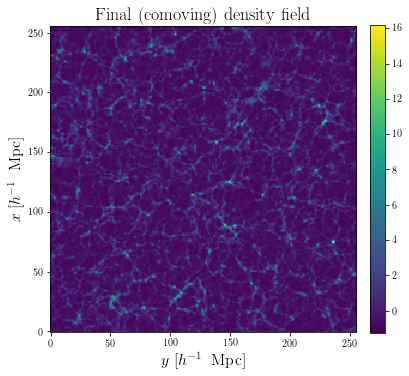

In [3]:
slice_thickness = 128

fig, ax = subplots(1, figsize = (6,8))

#a = ax.imshow(np.sum(np.log(1. + δ_ref_com[:,:,:slice_thickness]), axis=2), origin="lower")#, vmin=0, vmax=60)
a = ax.imshow(δ_ref_com[:,:,64], origin="lower")#, vmin=0, vmax=60)
ax.set_title(r"$\mathrm{Final \ (comoving) \  density \ field}$", fontsize=18)
ax.set_xlabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax.set_ylabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
plt.colorbar(a, ax=ax, fraction=0.046, pad=0.04)

### Compute power spectrum, $P(k)$

In [4]:
pred_size = grid_resolution

nbins = 100
lx = np.fft.fftfreq(int(pred_size), d = box_size_Mpc/grid_resolution)[:, None, None] * 2. * np.pi
ly = np.fft.fftfreq(int(pred_size), d = box_size_Mpc/grid_resolution)[None, :, None] * 2. * np.pi
lz = np.fft.fftfreq(int(pred_size), d = box_size_Mpc/grid_resolution)[None, None, :int((pred_size/2)+1)] * 2. * np.pi
l = np.sqrt(lx**2. + ly**2. + lz**2.)
P_w, l_bins = np.histogram(l, bins = nbins)
l_c = 0.5 * (l_bins[0:l_bins.size-1]+l_bins[1:])

def compute_power_spectrum(δ_slice):
    
    a_l_δ = np.fft.rfftn(δ_slice)*(box_size_Mpc/grid_resolution)**3.
    a_l_δ[0,0,0] = 0.
    C_l_δ = 1. / ( (box_size_Mpc/grid_resolution)*pred_size )**3. * np.absolute(a_l_δ)**2.

    P_δ, l_bins = histogram(l, weights = C_l_δ, bins = nbins)
    P_δ /= P_w
    
    return P_δ

Pk_δ_ref_com = compute_power_spectrum(δ_ref_com)

## Construct forward model (comoving-redshift space transformation + triquintic interpolation)

### Some physical constants & box/interpolation specs

In [5]:
# Some physical constants (useful for units)
H100 = 100. # km/s/Mpc
M_IN_KM = 1000. # number of metres in one kilometre
cosmo_clight = c.value # speed of light in m/s
cosmo_clight2 = spc.speed_of_light # speed of light in m/s
Qfactor = (H100*M_IN_KM)/cosmo_clight # Q has units h100/Mpc
cosmo = FlatwCDM(H0=67.75, Om0=0.3089, w0=-1)

# 3D interpolation specs
#n_order = 2 # Trilinear interpolation
#n_order = 4 # Tricubic interpolation
n_order = 6 # Triquintic interpolation
x_inter = np.zeros(n_order, dtype='int')

# Box specs
N0 = pred_size
N1 = pred_size
N2 = pred_size
pred_size_Mpc = 1000 #4000

### Specify comoving box

In [6]:
L0 = pred_size_Mpc
L1 = pred_size_Mpc
L2 = pred_size_Mpc

corner_c_0 = -pred_size_Mpc/2
corner_c_1 = -pred_size_Mpc/2
corner_c_2 = -pred_size_Mpc/2

# The box is shifted by some redshift z_min (chosen value)
z_min = 4000

delta_c_0 = L0/N0
delta_c_1 = L1/N1
delta_c_2 = L2/N2

### Computing redshift for comoving distance (given a cosmology)

In [7]:
# Convert comoving distance to redshift
# This requires inverse of a complicated function. Quicker way is to do a tabulated function and interpolate
# Input: z [dimensionless], Output: comoving distance [Mpc]

def interp_comov2z(cosmo):
    
    z_range = np.linspace(0, 10000*Qfactor, 15000)  # Choice a redshift range (dimensionless)
    comoving_distance = cosmo.comoving_distance(z_range)*(cosmo.H0.value/100)
    comoving2z = interp1d(comoving_distance.value, z_range, bounds_error=False)
    
    return comoving2z

comoving2z = interp_comov2z(cosmo)

### Build redshift box

In [8]:
L_z_0 = L0
L_z_1 = L1
L_z_2 = comoving2z(L2)/Qfactor # Divide by Qfactor to get cosmological redshift in units of [Mpc/h]

corner_z_0 = 0
corner_z_1 = 0
corner_z_2 = -z_min #-L_z_2

delta_z_0 = L_z_0/N0
delta_z_1 = L_z_1/N1
delta_z_2 = L_z_2/N2

### Build matrix of interpolation coefficients (and its inverse)

In [9]:
def prepareMatrix(interpolation="Triquintic"):
    
    M_matrix = np.zeros([n_order**3,n_order**3], dtype='float') # matrix of interpolation coefficients
    
    # Declare variables required for trilinear/tricubic/triquintic interpolation
    if interpolation == "Trilinear":
        x_inter = [0,1]
    
    if interpolation == "Tricubic":    
        x_inter = [-1,0,1,2]
    
    if interpolation == "Triquintic":    
        x_inter = [-2,-1,0,1,2,3]

    # Construct the M_matrix that encodes the interpolation coefficients
    for (alpha,beta,gamma) in itertools.product(range(n_order),range(n_order),range(n_order)):
        for (i,j,k) in itertools.product(range(n_order),range(n_order),range(n_order)):
            M_matrix[n_order**2*alpha + n_order*beta + gamma,n_order**2*i + n_order*j + k] = (x_inter[alpha]**i)*(x_inter[beta]**j)*(x_inter[gamma]**k)

    # Compute the inverse of M_matrix
    M_inverse = np.linalg.inv(M_matrix)

    return M_matrix, M_inverse

M_matrix, M_inverse = prepareMatrix() # Compute M_matrix only once

### Visualize matrix of interpolation coefficients

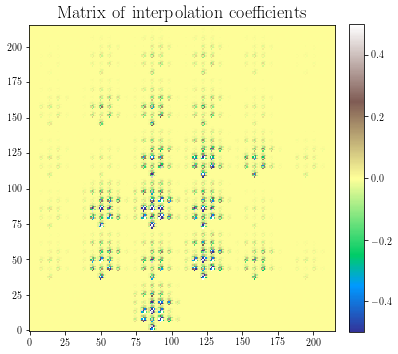

In [10]:
fig, ax = subplots(1, figsize = (6,8))

a = ax.imshow(M_inverse[:,:], vmin=-0.5, vmax=0.5, cmap="terrain", origin="lower")
ax.set_title(r"$\mathrm{Matrix \ of \ interpolation \ coefficients}$", fontsize=18)
plt.colorbar(a, ax=ax, fraction=0.046, pad=0.04)

### Update coordinate system (for a given cosmology)

In [11]:
#@njit(parallel=True)
def update_coordinate_system(Omega_m=0.3089, w_0=-1):
    
    grid_transform = np.zeros([N0,N1,N2,4])

    # Load cosmology using astropy
    cosmo = FlatwCDM(H0=67.75, Om0=Omega_m, w0=w_0)
    # Update accordingly
    comoving2z = interp_comov2z(cosmo)

    for n0 in tqdm.tqdm(range(N0)):
        for n1 in range(N1):
            for n2 in range(N2):                
                c_x = (n0*delta_c_0) + corner_c_0
                c_y = (n1*delta_c_1) + corner_c_1
                c_z = (n2*delta_c_2) + corner_c_2

                # {z_x, z_y, z_z} in Mpc/h
                #denominator = comoving2z(z_min)/(1 + z_min*Qfactor) # dimensionless
                d_A = (cosmo.comoving_distance(z_min*Qfactor).value*(cosmo.H0.value/H100)) / (1 + z_min) # dimensionless

                z_x = c_x/d_A
                z_y = c_y/d_A
                z_z = comoving2z(c_z + z_min)/Qfactor
                z_r = np.sqrt(z_x**2 + z_y**2 + z_z**2)
                r_c = cosmo.comoving_distance(z_r*Qfactor).value*(cosmo.H0.value/H100) # z_r*Qfactor = adimensional;r_c has units Mpc/h100

                if r_c == 0:
                    c_x = 0.
                    c_y = 0.
                    c_z = 0.

                # Shift z_z back (subtract z_min) ### FIXME
                ###z_z -= comoving2z(z_min)/Qfactor
                ###z_r = np.sqrt(z_x**2 + z_y**2 + z_z**2)
                
                E_z = cosmo.H(z_r*Qfactor)/(cosmo.H0.value) # E_z is dimensionless
                del_z_del_x = E_z.value
                Jc = del_z_del_x - (z_r/r_c)

                # Compute all 9 components of (3x3) matrix J for each voxel
                J_00 = ( (Jc*c_x*c_x)/(r_c*r_c) ) + (z_r/r_c)
                J_01 = ( (Jc*c_x*c_y)/(r_c*r_c) )
                J_02 = ( (Jc*c_x*c_z)/(r_c*r_c) )
                J_10 = J_01 # Symmetric about leading diagonal
                J_11 = ( (Jc*c_y*c_y)/(r_c*r_c) ) + (z_r/r_c)
                J_12 = ( (Jc*c_y*c_z)/(r_c*r_c) )
                J_20 = J_02
                J_21 = J_12
                J_22 = ( (Jc*c_z*c_z)/(r_c*r_c) ) + (z_r/r_c)
                
                # Compute determinant of (3x3) matrix J -> Jacobian(voxel)
                Jacobian = J_00*(J_11*J_22 - J_12*J_21) - J_01*(J_10*J_22 - J_12*J_20) + J_02*(J_10*J_21 - J_11*J_20)

                grid_transform[n0,n1,n2,0] = (c_x - corner_c_0)/delta_c_0
                grid_transform[n0,n1,n2,1] = (c_y - corner_c_1)/delta_c_1
                grid_transform[n0,n1,n2,2] = (c_z - corner_c_2)/delta_c_2
                grid_transform[n0,n1,n2,3] = 1.0/Jacobian

                if r_c == 0:
                    grid_transform[n0,n1,n2,3] = 1.

                if Jacobian <= 0:
                    assert (Jacobian >= 0), ("Jacobian issue")
                       
                # The following assertions ensure we do not go outside of box
                assert (grid_transform[n0,n1,n2,0] >= 0), ("Underflow lower bound 0")
                assert (grid_transform[n0,n1,n2,0] < (N0)), ("Overflow lower bound 0")
                assert (grid_transform[n0,n1,n2,1] >= 0), ("Underflow lower bound 1")
                assert (grid_transform[n0,n1,n2,1] < (N1)), ("Overflow lower bound 1")
                assert (grid_transform[n0,n1,n2,2] >= 0), ("Underflow lower bound 2")
                assert (grid_transform[n0,n1,n2,2] < (N2)), ("Overflow lower bound 2")

    return grid_transform

### Generic 3D interpolation routine ($n^{\mathrm{th}}$ order)

In [12]:
#@njit(parallel=True)
def interpolate_3d(s_field, grid_transform):
    
    interp_coeff = np.zeros([n_order**3], dtype='float')
    
    # vector that encodes values of (n_order**3) voxels that will contribute to interpolated value
    rho = np.zeros([n_order**3], dtype='float')
    z_field = np.zeros([N0,N1,N2], dtype='float')

    for n0 in tqdm.tqdm(range(N0)):
        for n1 in range(N1):
            for n2 in range(N2):
    
                t = grid_transform[n0,n1,n2]
                out = 0.
            
                ix = int(np.floor(t[0])) # input x-coordinate
                iy = int(np.floor(t[1])) # input y-coordinate
                iz = int(np.floor(t[2])) # input z-coordinate

                rx = t[0] - ix
                ry = t[1] - iy
                rz = t[2] - iz
    
                # Construct rho to evaluate store the value of s_field at all vertices of interest ->
                # vector of dimension n_order**3
                # We use periodic BC here -> Add N0/N1/N2 to prevent negative values
                for alpha in range(n_order):
                    r_alpha = int((ix + x_inter[alpha] + N0) % N0)
                    for beta in range(n_order):
                        r_beta = int((iy + x_inter[beta] + N1) % N1)
                        for gamma in range(n_order): 
                            r_gamma = int((iz + x_inter[gamma] + N2) % N2)
                            rho[n_order**2*alpha + n_order*beta + gamma] = s_field[r_alpha,r_beta,r_gamma]
                            
                # Construct interp_coeff via matricial operation -> vector of dimension n_order**3
                for m in range(n_order**3):
                    #interp_coeff[m] = M_inverse[m,0]*rho[m] + M_inverse[m,1]*rho[m] + M_inverse[m,1]*rho[m] ### For Numba
                    interp_coeff[m] = (M_inverse[m,:]*rho[:]).sum()

                # Core of generic nth order interpolation
                ax = np.zeros([n_order])
                ay = np.zeros([n_order])
                az = np.zeros([n_order])

                for i_tilde in range(n_order):
                    ax[i_tilde] = rx**i_tilde
                    ay[i_tilde] = ry**i_tilde
                    az[i_tilde] = rz**i_tilde
                
                for (i_tilde,j_tilde,k_tilde) in itertools.product(range(n_order),range(n_order),range(n_order)):
                    out += interp_coeff[n_order**2*i_tilde + n_order*j_tilde + k_tilde]*ax[i_tilde]*ay[j_tilde]*az[k_tilde]

                # Since interpolation on delta and not rho
                z_field[n0,n1,n2] = t[3]*(1 + out) - 1
                if z_field[n0,n1,n2] < -1:
                    print(z_field[n0,n1,n2])

                #assert (z_field[n0,n1,n2] > -1), ("z_field not positive")
                
    return z_field

### Compute the ground truth: $\delta_{\mathrm{z}}^{\mathrm{ref}}$ and $P_k^{\mathrm{ref}}$

In [ ]:
grid_transform_ref = update_coordinate_system(Omega_m=0.3089, w_0=-1)

δ_ref_z = interpolate_3d(δ_ref_com, grid_transform_ref)

Pk_δ_ref = compute_power_spectrum(δ_ref_z)

  0%|          | 0/256 [00:00<?, ?it/s]

-1.0141006774990697
-1.0009323361952194
-1.0024130348897675
-1.003948204289656
-1.0094972795200285
-1.0054742290038141
-1.0069331142887772
-1.0023252518627164
-1.0058679252149656
-1.0181954117215826
-1.004834583969007
-1.0004740136340529
-1.0013041561253426
-1.002372270828621
-1.003623515047358
-1.000246256112085
-1.0050540302470414
-1.0009188090627787
-1.006476212392244
-1.0004653246411876
-1.0065294039621926
-1.0009887537695168
-1.000803306089435
-1.0078192717606291
-1.0178781980656373
-1.000059861604523
-1.0004888444378437
-1.0164763909298267
-1.0033607162512352
-1.0006772528526302
-1.0161251859859057
-1.0076780560259588
-1.0165819339788555
-1.0024599752684336
-1.0033904914969671
-1.0069244076996589
-1.0026528721742356
-1.0037773094229314
-1.0001560691074047
-1.014389989761606
-1.000653539677756
-1.0450803541841067
-1.039857549448888
-1.0036166829361939
-1.0013549306802587
-1.0007696249105693
-1.0011605716689624
-1.0074707408877706
-1.0096759546755787
-1.0013283073784625
-1.00759130

-1.0033606574636627
-1.0047717766990867
-1.011030369472111
-1.002841996048433
-1.001804448477282
-1.001584150155218
-1.010877302070392
-1.0062647638005497
-1.003958154490595
-1.000598732482259
-1.0060639541340488
-1.0001658741402797
-1.0080534194524862
-1.0014934931394126
-1.0025920208508325
-1.0146914430442942
-1.0004894208329922
-1.0008828078529848
-1.0158356029096067
-1.008011426683002
-1.0046256735993537
-1.0091984381254966
-1.0101168228640072
-1.0062386908869316
-1.0006940201718086
-1.004190328326434
-1.0043107284721051
-1.0038311485231175
-1.0119652180051666
-1.0050997881663728
-1.0041454110242616
-1.0010710589394358
-1.006542750402413
-1.007281706665796
-1.00256427285605
-1.0008555178365226
-1.0118133288173685
-1.0180626949890124
-1.011640859685074
-1.006189305274411
-1.000201858536562
-1.0008249658357251
-1.006114176574169
-1.0050718902111082
-1.0253663659027124
-1.0146609670016316
-1.0054851368002584
-1.0007233647073768
-1.0064727009914425
-1.0002855231073577
-1.00585294153852

  0%|          | 1/256 [01:36<6:50:26, 96.58s/it]

-1.012832230156693
-1.0018352131338235
-1.001070110479767
-1.0011936804915
-1.0035657031946768
-1.0041237763344242
-1.0061147772540777
-1.00518673233431
-1.001781731049363
-1.0074806682538133
-1.0000296511399607
-1.013129040755254
-1.0004029657644349
-1.001807783262719
-1.033434062375584
-1.0058713216926405
-1.0066464705073421
-1.0094202188452843
-1.0060031099075297
-1.0007297594068385
-1.0073928456146404
-1.000090284454923
-1.0011098217539893
-1.0055786382441374
-1.0024755021475937
-1.0220300640170188
-1.0041599389691866
-1.0028525333773126
-1.0003822528209596
-1.0017465355521786
-1.000625475745899
-1.0004834511423153
-1.0003685379952492
-1.0043421847899057
-1.0090967016514112
-1.0001859390889434
-1.0036751855983348
-1.0032534068880585
-1.0026809594001747
-1.0007749222043307
-1.0018174511581648
-1.002938603144495
-1.0018339897250148
-1.0003140904906769
-1.0092094696756495
-1.007710488516866
-1.0014311276433492
-1.0057901639765336
-1.0012821928605655
-1.0066583835334915
-1.006773855673

-1.0068548947988394
-1.0004191628096963
-1.0124720363389128
-1.0028149951762317
-1.0065707563118194
-1.0080141681998909
-1.0063692792386536
-1.0034377553020448
-1.0069361462127009
-1.016964252303318
-1.004651886968438
-1.014696229591751
-1.0121109904624965
-1.010185350610408
-1.010298267900594
-1.0038707649775398
-1.0024057078048343
-1.0071310172807384
-1.0046143838565842
-1.0088126728312823
-1.0010445355972566
-1.00123963161666
-1.0062708884209586
-1.000883567271589
-1.0103342332357907
-1.006904097828748
-1.000578899735604
-1.0009816653206802
-1.0000288732844766
-1.0010465281685186
-1.001134103126435
-1.003501916787283
-1.0031332986690193
-1.0079345958817763
-1.0014859644196548
-1.006144650184125
-1.0005554477598841
-1.012002571423011
-1.0059973324288907
-1.0004770578261635
-1.006270787312715
-1.0022223183755272
-1.0009893437559976
-1.010641788920877
-1.0045464103566288
-1.0051951240534056
-1.000769784477803
-1.001543173904622
-1.0003053241620044
-1.0001117178414902
-1.004781957062908

  1%|          | 2/256 [03:14<6:51:02, 97.10s/it]

-1.0015929306800924
-1.0008704086306488
-1.0002685768658897
-1.00016950659399
-1.0033139517257634
-1.010429111259151
-1.0029326391091844
-1.0010555371274799
-1.0138188627381142
-1.016579606649705
-1.001681296384554
-1.0185080185220834
-1.0021350856826878
-1.0004801494901365
-1.0058416127882426
-1.0013901480582705
-1.0009044839001098
-1.0043801966152022
-1.0017385952440578
-1.005119106449901
-1.0065411618873699
-1.0117588495958452
-1.01382896474961
-1.0003718939284518
-1.0017529357109645
-1.0007034625229605
-1.002164504998363
-1.0053150008574283
-1.000222592818114
-1.0006302441606076
-1.012623921874256
-1.0015455495905867
-1.0067374797531736
-1.0016705783113424
-1.0066718481218488
-1.0019672724864623
-1.0015631144806696
-1.0102327492387164
-1.008123187966726
-1.0278804957279002
-1.008726876479233
-1.0170172854443331
-1.0003131061509194
-1.0037287836705653
-1.0149955820860448
-1.0029729517825725
-1.0090038940979031
-1.0001216104142885
-1.0086482785211033
-1.0057998102846804
-1.0023816236

-1.0133411495882918
-1.0002145911142255
-1.00226090541023
-1.0013608759487034
-1.002007629352313
-1.0034949803946145
-1.0026437514377708
-1.005308088336183
-1.0109940515021083
-1.0002249540331198
-1.0100963066111313
-1.0129665293864363
-1.0037697520229514
-1.0063317940371153
-1.0030162106949052
-1.0158675672265154
-1.0152558064206678
-1.0048071254530815
-1.0003764500518035
-1.0138725792040029
-1.0013335552362066
-1.000279328051552
-1.0025385757807954
-1.0070732217621787
-1.0010204497455217
-1.0098830650247952
-1.0017190031990884
-1.0030164634072598
-1.0018601547055246
-1.0003017104776657
-1.0045979112924286


  1%|          | 3/256 [04:52<6:49:28, 97.11s/it]

-1.0060304084058083
-1.0063285398698696
-1.0074331157546408
-1.0001112245709654
-1.0081945131459038
-1.0217212123150439
-1.0044422514721478
-1.0045070305035608
-1.000083125825639
-1.0055313741973997
-1.0038001547858153
-1.0082289526552732
-1.0027544403270099
-1.0032195993692778
-1.0083826737134078
-1.0092047942955609
-1.0024212020760241
-1.002024974989419
-1.0073774345639934
-1.0001285234022574
-1.0014085244346143
-1.0061806805730995
-1.002936356775531
-1.0131317038336436
-1.0078185064874237
-1.0166611500123728
-1.0065958355363545
-1.0018791230008464
-1.0000710523934189
-1.0016632186071392
-1.0118205790186212
-1.0075298764286185
-1.0001406826476562
-1.003823586376402
-1.0053746528445422
-1.0010382448864656
-1.0011703683647684
-1.0114787134647654
-1.0033711272520718
-1.0105931401079937
-1.0043136828329642
-1.000543760396301
-1.018508281678761
-1.00596660057677
-1.0002168769069817
-1.0027828629178088
-1.024880816489222
-1.0057514618005015
-1.0033239589732121
-1.0052835647531146
-1.001051

-1.0021171090028416
-1.0014302115855431
-1.0011191454389121
-1.0040058178395266
-1.005538711564252
-1.0000404236119038
-1.0052896614639943
-1.0015449365755165
-1.001324960447866
-1.0029610379282967
-1.0030694106460716
-1.0045186034695641
-1.0044330349252082
-1.0122222933570986
-1.0055993139196973
-1.0005810159755615
-1.0094865998184333
-1.0018559401788905
-1.0362903175430858
-1.009422893464222
-1.0045867338753376
-1.0020066849756688
-1.000212316909396
-1.0096581969321456
-1.0021255359302341
-1.0070957256988233
-1.000573314288872
-1.0013833437799968
-1.0128858944047352
-1.0024539379925423
-1.0233865280253869
-1.0006704707651604
-1.0062836628290148


  2%|▏         | 4/256 [06:30<6:49:10, 97.42s/it]

-1.0002165271008607
-1.0059490718094661
-1.0037682892917577
-1.0072088579345466
-1.0065057083110365
-1.008380607020825
-1.000978239839979
-1.001511449401081
-1.0016666978011768
-1.0013763504737296
-1.0058811014953173
-1.0088478893737753
-1.0011537937801218
-1.0000201897473429
-1.0216106958849023
-1.0002629834026886
-1.0033222325685465
-1.0167337661499094
-1.0137035300660378
-1.0044874573407252
-1.0000093340104041
-1.0137658339233877
-1.0053918943289788
-1.0042940664997495
-1.0010212508905405
-1.0000487808928982
-1.0040502581252737
-1.0000806577412449
-1.005910477196757
-1.0092553407601283
-1.0041310423600387
-1.000268889973038
-1.000689838495562
-1.0085662994079796
-1.0146236115956924
-1.0005183925402406
-1.0011350366538239
-1.0014944962902126
-1.0025970010943088
-1.0057306131803758
-1.0011236466360862
-1.0041071022796588
-1.0079830290461744
-1.0166699756626387
-1.0046500674601238
-1.006647815942248
-1.0031813686349274
-1.031626399922152
-1.0066386330839283
-1.0014108138175475
-1.00957

-1.0021126559903772
-1.000185157350334
-1.0000483813146162
-1.0027612438265474
-1.007078061591035
-1.0026611174466793
-1.0038709261377174
-1.001699864307257
-1.0023208881213768
-1.003399593666771
-1.00022129164986
-1.0020422734960384
-1.0034764532951832
-1.0061043695864793
-1.0013558808077327
-1.0002172655084633
-1.0016124961145232
-1.005427154128747
-1.0035525541477603
-1.001034494157964
-1.0006551140260462
-1.000207969286561
-1.0020062863998103
-1.003958493949939
-1.0051469161160955
-1.0001213707357155
-1.00939459704871
-1.0060905294560551
-1.0017305651362451
-1.0018338355915077
-1.0082554206792707
-1.0010996243498895
-1.0074154399036692
-1.0070339250674496
-1.0101839748106818
-1.0053647558002359
-1.0014718228999338
-1.0077284518275003
-1.0038343882161747
-1.0247966961470218
-1.0010199790724035
-1.0015003915408718
-1.0079529809081544
-1.0037721420838184
-1.0158058518718174
-1.004569091693693
-1.0000177991316246
-1.000219188960811
-1.0113294124856271
-1.0019261342723158
-1.00368936067

  2%|▏         | 5/256 [08:07<6:47:18, 97.37s/it]

-1.0036891646689288
-1.0066722489988305
-1.0013220804695218
-1.0003111093343275
-1.005361593788326
-1.0014283648160796
-1.0007606277762044
-1.000599325798645
-1.0111860923898113
-1.0017834909920171
-1.0001847304221967
-1.0040536604347485
-1.000132684351371
-1.004462536794799
-1.0000056850997394
-1.0122695673840623
-1.0034336472412038
-1.0041915942536745
-1.00164614869326
-1.0000548784244294
-1.0033187523601417
-1.000343121702708
-1.0054872045706722
-1.0018962642076379
-1.0047922667942957
-1.0090729188915895
-1.0014877834374707
-1.0049781521291625
-1.004036282023598
-1.0011286256778564
-1.0099340140279764
-1.004024665853405
-1.008879815240056
-1.0068389268687068
-1.0091145982925958
-1.020616913429351
-1.0002970295184992
-1.0002444786101654
-1.0009840513000632
-1.0031435710481766
-1.0028269397997525
-1.0013112837562672
-1.007762926038001
-1.0100951585877873
-1.010743624732649
-1.0080966914648117
-1.0027122974830252
-1.0031442083882007
-1.0061189498713712
-1.0046218243554264
-1.0031814043

-1.0048425473991764
-1.0076922073443724
-1.0075051312100023
-1.000578322452054
-1.000133279857487
-1.000414580454571
-1.0036866565999987
-1.0003038410847827
-1.0089970268127526
-1.00384545305405
-1.01305856173723
-1.000448266858782
-1.0018657295040818
-1.0031627694675345
-1.0005836158836858
-1.000877332680132
-1.0055494354036911
-1.0006204212489145
-1.0025281063215303
-1.0167043794279926
-1.0064523679577493
-1.0004238981295381
-1.0042155029389794
-1.007587570627248
-1.0028632560022905
-1.0166796604951351
-1.017783776863585
-1.0026663290937603
-1.0057107631353517
-1.009091536879804
-1.0020219380017796
-1.0093550349859028
-1.0045243484367767
-1.0001108015396334
-1.0031555272355337
-1.002713678172721
-1.0012737905719211
-1.0040918866260278
-1.006355495909363
-1.0073715040378668
-1.0033173492105982
-1.001146298543673
-1.0027982618809812


  2%|▏         | 6/256 [09:44<6:45:15, 97.26s/it]

-1.011015632041604
-1.0004872432138745
-1.0033185736964043
-1.0000497901945433
-1.008655405164896
-1.0018487042354787
-1.0034722562605607
-1.0038300385929113
-1.0111641405533902
-1.0009677643214265
-1.0037482894772074
-1.0101069476914624
-1.0044806916064313
-1.0036990594557758
-1.0013063975215784
-1.0012824688177266
-1.0008305574365504
-1.0044023212177813
-1.0112545917414297
-1.0079959251009167
-1.01030964847044
-1.009235757879159
-1.0147261844544897
-1.0146166942057664
-1.024932433025951
-1.0001710809798994
-1.0084318514750739
-1.0139232775002163
-1.0040669268767355
-1.0101004660234039
-1.0078638753885891
-1.0036761241125003
-1.000147917950502
-1.0036147344877833
-1.0044132946390247
-1.0034570608191582
-1.001015852873331
-1.0013521772678968
-1.0042793391559486
-1.0146396906340236
-1.010384284646026
-1.0095224242408298
-1.001294056917992
-1.0069305806091478
-1.002142903724399
-1.0028765944150424
-1.0090007526388594
-1.0015986737254177
-1.0008500357149437
-1.0009111281348144
-1.00001938

-1.0057517441435622
-1.0118366227606364
-1.005091218069371
-1.0087889387968232
-1.0004532846393945
-1.0004734930241654
-1.0009385651851312
-1.0009129828339975
-1.0141516063723521
-1.0024549840946784
-1.00411776803035
-1.002936479323895
-1.002038026852461
-1.0045226939868657
-1.0026274776526334
-1.0002981367120451
-1.009797152737618
-1.0016517551515278
-1.010386540095327
-1.0053577288999154
-1.0075993364773583
-1.0050933281138246
-1.0012052472969537
-1.0011974326804676
-1.0138152126672968
-1.0030058151046704
-1.003192324269303
-1.001263510335852
-1.0019418924545007
-1.0189542274841548
-1.0244647558822537
-1.001853633244296
-1.0056778278069411
-1.0068439087619692
-1.0033611358659453
-1.0160542638469339
-1.0000409549138987
-1.0031985755896067
-1.004604971749208
-1.005940752188057
-1.0018401948772993
-1.0008949769471902
-1.0108449286709567
-1.0222592706958171
-1.0006207855871367
-1.0041576473041718
-1.0089187719035415
-1.0002208083893103
-1.0026962150526382
-1.0137864641585375
-1.000610223

  3%|▎         | 7/256 [11:23<6:46:13, 97.89s/it]

-1.0158101278754532
-1.0004624837409923
-1.0028530201015478
-1.0099928499962214
-1.002089911786385
-1.0021836692373014
-1.0044635932483135
-1.0007765564450597
-1.0032182757786203
-1.0032794875343258
-1.0043164565757299
-1.0035842428076711
-1.0128865319722744
-1.00325231356701
-1.0018489267414306
-1.0048198321197295
-1.0093213223650441
-1.018445132408055
-1.012226079470598
-1.0018735423504064
-1.0076074777741446
-1.0005404275142773
-1.0013373346281402
-1.0189440762611346
-1.0009861541226517
-1.0047998341054225
-1.001261037834804
-1.002734158614386
-1.006959538166363
-1.0029800289284065
-1.00070417701508
-1.0014350859526564
-1.0002191179286184
-1.0018061378633125
-1.0013453823154774
-1.0150929289820079
-1.0016260798750096
-1.0153283717734671
-1.0026658962071406
-1.0037476535386092
-1.0006612237299757
-1.0155941184587618
-1.0231915882132943
-1.0044684049447723
-1.0069409603276964
-1.003695178107894
-1.0096927102363389
-1.003022908610305
-1.0078351665976761
-1.0004602890428769
-1.012550854

-1.0018193967716387
-1.0001447895808526
-1.0219126111991563
-1.0007564851703228
-1.0015769134612649
-1.0127958487051945
-1.0009748259974423
-1.002657150092685
-1.011613763917168
-1.0070351599189096
-1.0005521108164477
-1.0028917290692598
-1.0060406772790758
-1.0000551978374748
-1.0152971272631908
-1.0003777816102872
-1.0004898479307145
-1.0109843347927068
-1.0036464993086418
-1.0010728996059255
-1.0017201462745124
-1.0011614193533576
-1.0016637996290345
-1.000619734680638
-1.0033337081812768
-1.0095387926252577
-1.004523937036219
-1.0013721847538541
-1.0004336164748613
-1.0121808978114297
-1.0024820087721977
-1.003638103496493
-1.0064367115227477
-1.0061308329719085
-1.0024502626250045
-1.0006088680083052
-1.014536188791519
-1.0008386242960812
-1.001052209887696
-1.0029719190617294
-1.0011041284382052
-1.0016852322291216
-1.0107687489356108
-1.0000042084352074
-1.00805465427758
-1.003164254162794
-1.0014355586141936
-1.0056153689086471
-1.0028343202162933
-1.004629242194463
-1.00212443

  3%|▎         | 8/256 [13:03<6:46:33, 98.36s/it]

-1.0036733381991907
-1.0042169611615228
-1.0036280824485202
-1.0025291123754996
-1.0004434159108169
-1.0075051729014415
-1.0066216916452984
-1.0058171883152622
-1.009812678143379
-1.010377937055044
-1.003016894752905
-1.008323416585
-1.004239115199237
-1.0079508137226392
-1.0036608751946767
-1.0197289747630442
-1.0055326060139036
-1.0055131071050258
-1.0030592296345426
-1.0046105582474
-1.0038017142153484
-1.001159501882558
-1.0067672297583925
-1.0042608850655095
-1.002590237823175
-1.0100431830701297
-1.004093914759041
-1.0000015862780218
-1.0034045102120757
-1.0012569167189145
-1.018598744462142
-1.0023223831620975
-1.00105705936418
-1.0205308214920716
-1.0090280019447753
-1.0010215391125477
-1.0059567310712274
-1.0046340537138698
-1.0170228016233618
-1.0104773492658825
-1.0015495867286004
-1.0424296053164797
-1.0227069867147875
-1.0031679698100602
-1.0126586034566503
-1.0058292088012908
-1.0019534894488946
-1.0027900754585337
-1.0482261917900193
-1.0001681031311123
-1.00207047104102

-1.0077864974362782
-1.0044842151773359
-1.0047714896824083
-1.0044151356865931
-1.009394846893661
-1.0203086460870603
-1.0007311089199347
-1.0046858384123334
-1.0017436439935359
-1.0184944178839674
-1.0008488604518841
-1.0107528342767431
-1.0030728820142103
-1.0020048559280086
-1.0157094526585082
-1.0055871251991721
-1.0019962984591082
-1.0002473994684251
-1.000711685637223
-1.0006139482990986
-1.0043886843247536
-1.0033763920253185
-1.0001362732033245
-1.0017442859950505
-1.0009093639992366
-1.0000969083125277
-1.0039741972428058
-1.0090090523605642
-1.0000685193561185
-1.009772392001456
-1.002064366617458
-1.0035221990338505
-1.003758504169999
-1.0037235519305425
-1.0070012185188564
-1.0074691686387907
-1.0041488335771105
-1.0070853992242061
-1.003907320060709
-1.0046829492062677
-1.0065551749294765
-1.000499586970991
-1.0123335466075192
-1.004285856287824
-1.000354328189249
-1.0004049095185297
-1.0044083357034665
-1.002229193635936
-1.015994541776408
-1.0026454084348109
-1.00005926

  4%|▎         | 9/256 [14:41<6:44:42, 98.31s/it]

-1.0098660341739734
-1.0015159288057902
-1.001222954807967
-1.0022386812948807
-1.0044994695660394
-1.0008078670495106
-1.0120147711586167
-1.0048964654986134
-1.003345630986392
-1.009304938887884
-1.0120383552129153
-1.0080278936477909
-1.0033651087404436
-1.0017333029585573
-1.002543601163758
-1.0037469915051003
-1.002616868940921
-1.0014762285399046
-1.0040444357738787
-1.0063723333570125
-1.0015476764091111
-1.0047210731312457
-1.0031963188281328
-1.0004475604012937
-1.0064325191993588
-1.0046871269132494
-1.0029329341638165
-1.006788901724997
-1.0004005113303982
-1.0030733234579037
-1.0026595007431118
-1.0022101083909671
-1.0048847450287968
-1.0005692918590576
-1.0004996381823248
-1.0023109947196287
-1.0122417203776501
-1.0014449486296106
-1.0010701337483803
-1.0095554039747816
-1.0116093375089301
-1.0001312310052264
-1.0036349809709906
-1.0027342208264596
-1.0013539035352987
-1.0097174405948206
-1.0025581888362705
-1.0083337413334668
-1.0143672947446842
-1.015137047792971
-1.0056

-1.019929701029059
-1.0042173583884264
-1.0004311815784486
-1.0010242406392191
-1.0172339900230858
-1.0002169451562284
-1.0010687282597057
-1.0072150529003157
-1.0009203454258668
-1.0025400656961991
-1.0080591195067157
-1.0072538958254211
-1.0082230459634733
-1.0024583397066553
-1.007664458648132
-1.0025000002522508
-1.0008043350035563
-1.0006664269831436
-1.0088832770569403
-1.009896755449165
-1.0019041189285927
-1.005207174751883
-1.004000942082533
-1.0081187090070767
-1.0046296893512119
-1.0133669357836272
-1.017058426708003
-1.002208497842838
-1.0054623317945388
-1.0043197964400725
-1.0086454609540503
-1.0021898948152588
-1.0059965314201733
-1.002914804371611
-1.0074466567311378
-1.0031484572046923
-1.0098364444386827
-1.0024204255975437
-1.0022698387642468
-1.0028702356704147
-1.0001403422329984
-1.0004210484548295
-1.0032992964348577
-1.0100098508650517
-1.000047776884423
-1.0053607512298552
-1.0004135628259223
-1.006057818311288
-1.0008463116425266
-1.0023449070108794
-1.0014423

  4%|▍         | 10/256 [16:18<6:41:33, 97.94s/it]

-1.00541972179357
-1.004658478504139
-1.0027692424891004
-1.0188233604953267
-1.002300313923004
-1.0002288160285429
-1.0013296081271974
-1.0108411570440787
-1.0003255410812233
-1.003052906206533
-1.0109879630708654
-1.0057528560172944
-1.002409932234282
-1.0021110139591711
-1.0010027904678944
-1.001608697857853
-1.00251062537402
-1.0001712416473505
-1.0053125911775291
-1.0048826815924135
-1.0042888721682874
-1.0030533043862777
-1.0000559748215034
-1.0102539714804524
-1.0009827095639285
-1.0037932836519876
-1.0180915802075368
-1.001554225250625
-1.0005623826961876
-1.00289422395472
-1.000655987669698
-1.0006483288017893
-1.0012274988273222
-1.0004188680431734
-1.002631861616895
-1.0015523795533814
-1.0016223747924293
-1.0083004111967053
-1.0023831977376112
-1.0010401725661675
-1.0118307384615106
-1.0075375353661518
-1.000390851331162
-1.0073885556890572
-1.0003945372827707
-1.0048429420127616
-1.0044308532210902
-1.0009009175644468
-1.005609575394835
-1.000776605372323
-1.00240367027803

-1.0095637532357966
-1.003151740491861
-1.0189454216463036
-1.0027204007040227
-1.0038341718557289
-1.019098513545188
-1.006227092458285
-1.021682257024019
-1.0040062592806331
-1.0290986353049605
-1.0085123483192724
-1.0052378715228212
-1.0024813386966507
-1.000254204935666
-1.0024960340869284
-1.000010398825036
-1.0115668021757347
-1.001400024062864
-1.013379445016177
-1.0016143185854625
-1.0003940115189964
-1.0009059397065252
-1.0013791095907634
-1.0020709470163078
-1.0223947715119561
-1.0012209387774258
-1.0007168991236013
-1.0076435780360056
-1.004561482430451
-1.0122854341060685
-1.0001305531589735
-1.0058026499018649
-1.0104103873608243
-1.0201072153346435
-1.0133120946007002
-1.0033360495838333
-1.0001308087225609
-1.000339671671636
-1.0024275163465843
-1.002828028389235
-1.001975460686798
-1.0217400329470636
-1.006724394719201
-1.0037258561671953
-1.002237731977729
-1.003375238286717
-1.0013021860268039
-1.0034363632110537
-1.0005704106384072
-1.000793084985504
-1.0013435824775

  4%|▍         | 11/256 [17:56<6:39:41, 97.88s/it]

-1.000410891168754
-1.0000295734167295
-1.0008178035467208
-1.0082997492759154
-1.0020208506584145
-1.0148570792867861
-1.000163512012086
-1.0019659647333263
-1.0014963113513675
-1.0006204118062365
-1.000406280153613
-1.0001107679067238
-1.0056927307605064
-1.0151391331720232
-1.0102104979905455
-1.0039615039661904
-1.0043512471846006
-1.0064437120773466
-1.0092943297189498
-1.0039535204748666
-1.0023749934417931
-1.009769949296594
-1.001492412413217
-1.0004811059258756
-1.0027535048541811
-1.0285757580392396
-1.000314129694776
-1.0007565137248275
-1.0013188546357186
-1.003863962754646
-1.0055270473343132
-1.0015509902265103
-1.0050404434944906
-1.002210111311852
-1.0016900860235152
-1.0008957504859688
-1.0021321002002144
-1.008372212718505
-1.0109652085604521
-1.0050888287482604
-1.0000783268125157
-1.0014662854716851
-1.0057835666712365
-1.0016740444689738
-1.0050346403083452
-1.0040797057736255
-1.0048534558250175
-1.0104281383446438
-1.0193502971390973
-1.0008608120051667
-1.005910

-1.0060936174108668
-1.0316918166521352
-1.014565038877497
-1.0062957895134184
-1.0047733184457244
-1.0233730316063836
-1.0070838068211392
-1.0018481380589477
-1.0042439446632885
-1.0017121046180726
-1.0154037531610391
-1.0054832231509852
-1.00180001897038
-1.0013622873601216
-1.0004706249472965
-1.0008465510917024
-1.0069318439863753
-1.0072876333844138
-1.0055550656841334
-1.0061699480348736
-1.0000869015905762
-1.0047020859829996
-1.0058608708452552
-1.0085201604887992
-1.0010357194633641
-1.0001173482020504
-1.0087685875737147
-1.0088319002735515
-1.0029373225823663
-1.0015560559378862
-1.000931993427642
-1.0007488317058464
-1.0101074033811268
-1.0025677235639474
-1.0033955923085995
-1.001512989765756
-1.0034146414769995
-1.0027657409801847
-1.000977631035355
-1.0008633837323544
-1.002115774269744
-1.0019812067876572
-1.0113630218211773
-1.0020144222568022
-1.002556289298673
-1.0019825019831465
-1.0001228917585552
-1.0052651286035668
-1.0017062701583188
-1.0063611582644847
-1.04060

  5%|▍         | 12/256 [19:33<6:37:33, 97.76s/it]

-1.0019221480077831
-1.0001079353823863
-1.0025136432878745
-1.0003718762607954
-1.0124090734359614
-1.0037649625541853
-1.0021567487698277
-1.0049719322950519
-1.0048511032738718
-1.0026828047307237
-1.0039631318478042
-1.0076632736155164
-1.0004105595004784
-1.014357909664129
-1.0017280493117153
-1.0022573453670056
-1.0102385704917276
-1.0017528442100814
-1.0019173266396733
-1.004589455687172
-1.0222470894914428
-1.0021912081704412
-1.0041667047411449
-1.010037840177292
-1.001551079025575
-1.0081894374320046
-1.000970494071981
-1.0089681254709237
-1.0047055375575993
-1.000302379530343
-1.0032122940310435
-1.0055139773520276
-1.0060805453331279
-1.0007479420766605
-1.0185038642948445
-1.0007953248862194
-1.003872869381909
-1.0001017621012886
-1.000328378091977
-1.0003251965555662
-1.0038638799344444
-1.0018507720351708
-1.0012334286746203
-1.0026804392573154
-1.0021823391491176
-1.0019561428203168
-1.0001399929236228
-1.0013797458355278
-1.002568332718878
-1.0036826677608688
-1.001707

-1.0046427330767085
-1.0006427325326306
-1.002099877328632
-1.0024920906241168
-1.0111771179479216
-1.0137466290268513
-1.0000775498447192
-1.0005070838887584
-1.013298263757719
-1.000982659651426
-1.0013225145431024
-1.011423947392293
-1.0030513779213177
-1.0034702185483486
-1.0003969414200373
-1.0010559190228592
-1.000416361724963
-1.0011229643824309
-1.0083554768635978
-1.0016983769938597
-1.0041831344396324
-1.0096857706253042
-1.0013302787037435
-1.00133887346743
-1.00650440397277
-1.005615934207606
-1.0020917086173926
-1.0007836328320994
-1.0015690018649193
-1.001161727415303
-1.015951716770979
-1.003414933529543
-1.001559581688153
-1.0054866666952438
-1.0027314257647615
-1.0017687590676627
-1.0003356500591032
-1.003272282138375
-1.0008694581125979
-1.0018654483355252
-1.0064631989398294
-1.0090234862549998
-1.0007840395648797
-1.0006727598253395
-1.000361438038963
-1.0011463066156363
-1.0011432637879678
-1.020468417683483
-1.003229003930626
-1.0015661360033812
-1.002728115831004

  5%|▌         | 13/256 [21:11<6:36:22, 97.87s/it]

-1.0033411957086849
-1.012856038802458
-1.0012129116793156
-1.0002086238835604
-1.003865454209562
-1.008159263530101
-1.0026081391008932
-1.0059134645020118
-1.004529855768093
-1.0022756133316433
-1.0014722885308032
-1.0154677345400656
-1.0187494590002997
-1.0049988437578548
-1.0134674589091486
-1.0226285433749795
-1.0037164187270293
-1.0069322581848321
-1.001545506145497
-1.0023503702126408
-1.0006025288285512
-1.0064572498945255
-1.0017030804383154
-1.0004145889105414
-1.008919057908073
-1.016322282008248
-1.0036633422472137
-1.0027753526998466
-1.002812478748823
-1.0050508317934213
-1.0164815203193822
-1.0026119014708466
-1.0001688546437666
-1.0014436513689315
-1.0054935623531969
-1.010406310508788
-1.0047978657945709
-1.003577625387113
-1.0021379027221653
-1.002239276330672
-1.0008528596312973
-1.008080689244068
-1.006535988107391
-1.0052865858513003
-1.001402765840269
-1.0049028566365417
-1.0015130998695363
-1.0019480158107215
-1.003457691093276
-1.0073626629665493
-1.005070991205

-1.0042449465884178
-1.0063492829639402
-1.0015535196808698
-1.005971853589422
-1.002430691327115
-1.001554161376794
-1.0242529799314524
-1.003886815637996
-1.0002126212909617
-1.0080083163662326
-1.0009097235522404
-1.0053984607607627
-1.0125798523729117
-1.0000038466788468
-1.0006087527314376
-1.0015400251284623
-1.0019784201978055
-1.0001339113242977
-1.0023670158795228
-1.0050510090640525
-1.000412459999219
-1.0006426260478598
-1.002573119003392
-1.0008176904618338
-1.003787027631797
-1.0028183440919332
-1.0024842214168141
-1.012286332045882
-1.0003127177811633
-1.0192608076743972
-1.005146819545799
-1.0038059644462867
-1.0107636441681074
-1.0078424166260986
-1.000476399205402
-1.0035445230926072
-1.0004594713696462
-1.0003704104591404
-1.0033355518447955
-1.0005391138729245
-1.0002164433099983
-1.003898695071645
-1.0065312996051927
-1.0014766403071902
-1.0072726493994881
-1.0069611924324908
-1.002450158880064
-1.0009795407363757
-1.0004526974872239
-1.0020505554905066
-1.005894498

  5%|▌         | 14/256 [22:48<6:33:32, 97.57s/it]

-1.0366005374633736
-1.0207509119427656
-1.0018833694046096
-1.010871321060181
-1.0123660824328542
-1.0011901641629806
-1.0053813298329881
-1.0093592151403774
-1.0227393984985818
-1.000076150303325
-1.0003959851368487
-1.0038614269026551
-1.0055652728528248
-1.0033372406781167
-1.00223167661804
-1.0035463247611534
-1.0101490924881633
-1.0004807580291157
-1.000327601474005
-1.0003781479585132
-1.0174834074140755
-1.0065097461351717
-1.0046340512612502
-1.0009589501371772
-1.0133249458625109
-1.006570258458169
-1.000724930357992
-1.0018478575992296
-1.0001057351243852
-1.0006080756432736
-1.0075779677216594
-1.014251341778687
-1.0029333970296108
-1.0094018332955106
-1.003027662145985
-1.0029761790635174
-1.0014729702336267
-1.0002567793498163
-1.002790563847571
-1.0034756559076203
-1.0213621539205162
-1.0099450546511504
-1.0019729070977477
-1.0054574319610625
-1.0015705431444755
-1.0002798678826643
-1.000609719934085
-1.003373986032373
-1.008344037268334
-1.0011101561442832
-1.0006913521

-1.0087518203232129
-1.01165076435546
-1.0022461509997902
-1.0063075279149272
-1.0021760642684039
-1.0089026535170023
-1.0062759781525275
-1.0111605313973548
-1.0175115457058566
-1.000264101820891
-1.0002207046596696
-1.000055570505249
-1.0073382943039468
-1.0016129316135058
-1.000900249774937
-1.0042029812074424
-1.003584264479532
-1.002457646286931
-1.0070001847509178
-1.0038613198743367
-1.0039204587201214
-1.0241861263486902
-1.0064843521374045
-1.004165437449284
-1.0015199004936721
-1.0017136565698062
-1.0224832369943515
-1.0054045139512457
-1.0022566688079615
-1.0068756682842726
-1.0009704440529428
-1.0020194576156212
-1.0093220685993363
-1.0014567987526528
-1.0018667659097653
-1.0004378002042251
-1.006962271432351
-1.0392309910244475
-1.0031417955544566
-1.009344188628219
-1.0021458082384518
-1.0021576821155584
-1.0108773214901223
-1.0034983349302105
-1.0016775990733786
-1.0008886511481172
-1.00017971600836
-1.0032836079215874
-1.0037417239493764
-1.010946543480321
-1.0010457144

  6%|▌         | 15/256 [24:25<6:30:23, 97.19s/it]

-1.0062602828757898
-1.0010669265953525
-1.0045117138591537
-1.0013633506387727
-1.0001453393048447
-1.0010957672723466
-1.0059315089246372
-1.0021184575526754
-1.000677536032
-1.0007289322642852
-1.0159845477410223
-1.0062763357614277
-1.0009110408293553
-1.0037771687313193
-1.0006550760594175
-1.0022239820179373
-1.0004285431899052
-1.0005409933709548
-1.0015017105003463
-1.0007669969553077
-1.0006339713715193
-1.0162984556846746
-1.008607283974537
-1.0066255034233216
-1.0021626211807775
-1.0013563221249178
-1.017903580966971
-1.0055937992295205
-1.0006227837210298
-1.0003779970912139
-1.006444563106802
-1.0017216154328004
-1.0039091700144243
-1.0004810938302915
-1.0015531698573454
-1.0015697359800249
-1.001677407374013
-1.0004196340635936
-1.0080234243435966
-1.0011808475495356
-1.0011427369218104
-1.0056779466817765
-1.0028902888179894
-1.0114665248003363
-1.0043274192532858
-1.0011477316314195
-1.0060011274900418
-1.000339005353115
-1.0254428263894173
-1.0115680426921947
-1.001803

-1.0020511260150278
-1.0125607318117469
-1.0001124150147944


  6%|▋         | 16/256 [26:01<6:27:47, 96.95s/it]

-1.0016808078568133
-1.0052925909786994
-1.0033927447248048
-1.0003996935003525
-1.0008836348683638
-1.004023188879039
-1.0059475881748767
-1.0112276944745595
-1.0018704543090367
-1.0098767602950265
-1.0159425586181552
-1.0049997460126159
-1.0092070081646214
-1.000462907421431
-1.0082698933808223
-1.0020597056469982
-1.0024185414794589
-1.0000838094602382
-1.00425381802981
-1.0000454291413143
-1.0186181553843556
-1.0021824840091789
-1.003157574926416
-1.0006202507408695
-1.0101980787510698
-1.0220755126036627
-1.018949450802207
-1.009390653604368
-1.000123746347954
-1.0165157141565186
-1.008791494887716
-1.0001207266709808
-1.002805785581994
-1.0233474552640829
-1.0038826152528646
-1.0003593010210254
-1.002129743241468
-1.0045499082038962
-1.0091085316386526
-1.0088232686401302
-1.0118176873192617
-1.0065331374604756
-1.0015180165787572
-1.0194365226492343
-1.003636876081111
-1.0145900459776367
-1.0059280954284617
-1.000088657894192
-1.0103263207735766
-1.0062372846075336
-1.0031544777

-1.0000027609657067
-1.0006057524440484
-1.0058446291158938
-1.0109125968261783
-1.0127546572126291
-1.0038214182893028
-1.0072833413776952
-1.0011012536053208
-1.0036275359417506
-1.0016872421378726
-1.0037522066283913
-1.0099672538689093
-1.0006436682100472
-1.00266252336307
-1.0037523655655423
-1.0034413162499394
-1.0148079337636284
-1.0003155618823527
-1.0136758712407172
-1.0014634390797084
-1.0093088745046768
-1.0129023665769614
-1.0055298766822662
-1.0022016905050823
-1.002466637737813
-1.0017886404495757
-1.0051759906242936
-1.004984871455521
-1.0010827850802881
-1.0112479683617215
-1.0082156240043032
-1.0002035728054954
-1.0000652939611678
-1.0005674193373333
-1.005296319151295
-1.0029237660989325
-1.0009377314791041
-1.0032672094877555
-1.002991470926367
-1.0104862206660261
-1.0029900728816061
-1.0076271031132324
-1.0005394068343183
-1.000521819206074
-1.0016786607946544
-1.0018653752944768
-1.000356992301507
-1.0087928327394045
-1.0001301891301457
-1.007837360133834
-1.002707

  7%|▋         | 17/256 [27:38<6:25:52, 96.87s/it]

-1.0033786214289817
-1.000961503067304
-1.0024320007888874
-1.001526152292189
-1.0091915728530085
-1.0036285610715985
-1.0075308768781304
-1.0003862901233982
-1.008393780482444
-1.0222789672032402
-1.0036958459789733
-1.0047291814832675
-1.00771437711611
-1.0053475229601276
-1.0036544475533538
-1.0074851091840646
-1.0030376704478827
-1.0007420851850704
-1.0075238638674153
-1.007203084652061
-1.0015866235476298
-1.0009015035483457
-1.0067838644803089
-1.0021668129163666
-1.0131134075306676
-1.0070063897061716
-1.006257303108781
-1.0202320060763022
-1.0089796264438657
-1.000123985925915
-1.001966436650504
-1.0019628600147563
-1.001709845516645
-1.0090082249275494
-1.0013836859909597
-1.0018190433926453
-1.0010390058918397
-1.0043441440288001
-1.011616059888426
-1.0004384490046
-1.0033145719388343
-1.015788547113835
-1.0026242591247698
-1.0007705156115887
-1.0017162844082033
-1.00225582315191
-1.0063400504459863
-1.0004737660072742
-1.0018445175496153
-1.0024778486139876
-1.00438337693689

-1.0142693079898644
-1.0103790012200469
-1.0075247434565815
-1.0196437810858372
-1.002537814878738
-1.0050102950985917
-1.0006270320382427
-1.0062078998822341
-1.0011480214011874
-1.0001870953236038
-1.001457101821083
-1.0020409682783238
-1.0004874379412387
-1.0050804600758023
-1.0002829179663202
-1.004611074268165
-1.003035787453194
-1.0017132172230496
-1.0036540104903584
-1.005236199972754
-1.0026618440449158
-1.0037648910903119
-1.0010972581848057
-1.0018488029698713
-1.0104157056556815
-1.0051225181871273
-1.0049443380634082
-1.0039645780948037
-1.014326168589702
-1.0042666396980302
-1.0051358500550718
-1.0004122994823774
-1.059683226290867
-1.0034421509867144
-1.0002824349361916


  7%|▋         | 18/256 [29:14<6:23:56, 96.79s/it]

-1.0042873690841643
-1.0019530890688388
-1.0059591583191574
-1.0014238834270708
-1.0129135363631507
-1.0019435668664856
-1.0060601036312011
-1.0022299004174757
-1.0126212021034733
-1.0208713753683059
-1.002683071605773
-1.000425731628128
-1.0126810663808223
-1.0017354159677054
-1.0038810749131934
-1.0023229233841306
-1.0017878714784754
-1.0009108329807241
-1.0021055797665481
-1.0017639866900938
-1.0173413839820955
-1.0074373917301822
-1.0020971016847193
-1.0113205037112942
-1.0039797798793573
-1.0034191882794836
-1.0028987497643944
-1.001029470187195
-1.0003671116062007
-1.0010846608485136
-1.0004862315524716
-1.001908306937891
-1.0005320483400895
-1.0118161008352902
-1.0062593199614667
-1.0058019521674697
-1.0038990431260186
-1.0013287819245351
-1.0064835098101832
-1.0006698682315371
-1.0020187599133799
-1.0017035475162208
-1.0000196158464238
-1.0040530474594516
-1.0121275042205562
-1.0057897528927566
-1.0078516127661135
-1.0018483876126523
-1.0040520054486946
-1.0047308383625158
-1.0

-1.0021111173338038
-1.0380070822937686


  7%|▋         | 19/256 [30:51<6:21:54, 96.68s/it]

-1.0044444309458636
-1.002337082011633
-1.003011952996546
-1.0010572160385718
-1.0021310407073964
-1.0005371834537526
-1.0062450834459287
-1.0030663739096057
-1.0009320774348083
-1.0025370920124554
-1.0032870647054224
-1.0035234288919725
-1.00704951059317
-1.0056700206472895
-1.0104935646416264
-1.0023030834537092
-1.003680015807257
-1.015453808220492
-1.0149293354629325
-1.0022321702688466
-1.0001520571445752
-1.0023667359644448
-1.007625751054617
-1.0072505233439208
-1.01284133726908
-1.0065213776413275
-1.025179187315284
-1.004651432155028
-1.0008757209083814
-1.000319494176873
-1.0050465127814499
-1.0019478232054766
-1.0027850721401008
-1.0004971739516373
-1.0014986067706806
-1.0067844226848692
-1.001939916369893
-1.0030270959778897
-1.0065649597950934
-1.0051480101575418
-1.0142449032848277
-1.0106312360380627
-1.0033397753900724
-1.0043556267249112
-1.0000645674592241
-1.0063514169132612
-1.0069777629165007
-1.0003312172041536
-1.0154292601754331
-1.0007458069773978
-1.0008380053

-1.007669547795435
-1.0061534600593054
-1.0005945392673385
-1.0000768523993104
-1.0381031483699132
-1.0030578172802809
-1.008302623208659
-1.0002557065699635
-1.0136237766666447
-1.0098390157833517
-1.010707966468553
-1.0041291551719942
-1.002350502754357
-1.010391973629632
-1.0040362137692442
-1.013747474274115
-1.0001288005150137
-1.0034774916215417
-1.0031039619677595
-1.003235915048365
-1.0003904201783558
-1.0028266002278947
-1.0054146634684098
-1.0026347714588082
-1.0005322306850564
-1.0024111827803586
-1.0060263805591847
-1.0009193326601615
-1.0043989848983532
-1.0229167134580956
-1.0022506765463945
-1.0038732787055322
-1.012325228492559
-1.0041295775758232
-1.0028041382714052
-1.0006233485015592
-1.0002048064962161
-1.0076787624397978
-1.0047088678715062
-1.0093528290271705
-1.0048586386656566
-1.0095177426920403
-1.0099814471542727
-1.0142901981066061
-1.0100175304072216
-1.003046826455717
-1.0266858142234692
-1.0023341784518671
-1.030746064773259
-1.0004736493625908
-1.0013776

  8%|▊         | 20/256 [32:28<6:20:35, 96.76s/it]

-1.0029044111292154
-1.0151749667380991
-1.0195545343994907
-1.0012736976722858
-1.0021886578376429
-1.000919924741043
-1.0107466120249324
-1.015874882398646
-1.007980738434802
-1.0014128296212477
-1.0115001503189567
-1.0007762247670078
-1.0054303748893887
-1.0066517102203987
-1.002483236053533
-1.0087404245996199
-1.0115843421426671
-1.0010105084703267
-1.0049971850581114
-1.002317579065441
-1.0030493561276734
-1.017102028592436
-1.0247410708606133
-1.0122803568390395
-1.010407519915407
-1.0010610113402283
-1.0007501959837488
-1.0004410139478923
-1.004726036225087
-1.0073066564751154
-1.0037747444043943
-1.0192897440006994
-1.0018923454712603
-1.002786260931762
-1.0022862138352668
-1.0029843435300634
-1.0008586604813838
-1.0003044065814215
-1.000708083416749
-1.0327976077956784
-1.0305179504413085
-1.0099522986675429
-1.0015910217838686
-1.0135770600709764
-1.0044451512265833
-1.0004434872646164
-1.0007752357636472
-1.0003404797711304
-1.0027953569387031
-1.0011802471553293
-1.0124848

-1.0021163145024308
-1.0206075742327139
-1.0078053088336765
-1.0126614902933424
-1.0014257478572395
-1.0013004953230733
-1.0045491766779029
-1.0069069838798415
-1.0053673594993129
-1.0039687402844593
-1.0065571510800433
-1.015961659499279
-1.010726817369685
-1.000389479443042
-1.0034388690629235
-1.000213726765044
-1.000051752365867
-1.0095855941979561
-1.000317489102975
-1.0017778530637134
-1.001753852743531
-1.0026216150529006
-1.0040940775420093
-1.0008227916678185
-1.0025135499505478
-1.0016497679418241
-1.005081974152295
-1.00477086856983
-1.0003152976460818
-1.002294752514055
-1.0015005843357832
-1.0095436404468816
-1.0018594689571976
-1.0008398689274545
-1.002786512219937
-1.0021451522396725
-1.0019302031365467
-1.0107561718548426
-1.006270172873637
-1.0031479628866988


  8%|▊         | 21/256 [34:04<6:18:48, 96.72s/it]

-1.0161061065736559
-1.00077393079226
-1.02030985603247
-1.0072183368738057
-1.0022749510262914
-1.0008559851732168
-1.0194838503709802
-1.0113827970836236
-1.0219907795977017
-1.0192808241685478
-1.0004198529644248
-1.0095698114328493
-1.0028870228555429
-1.0050264680062422
-1.0064434494810035
-1.0079035289106473
-1.0017357143814567
-1.0286749667927448
-1.015646509067958
-1.0050800182403583
-1.007279694163628
-1.008917091107397
-1.011425738076157
-1.0001944436155732
-1.0064803940927585
-1.0015165937773267
-1.0196997383854387
-1.0432378387606793
-1.0032729737918327
-1.0214074070194987
-1.0005238427848524
-1.0007980208508087
-1.0026829384305833
-1.000971800175289
-1.0362439707228561
-1.0014411132830043
-1.0050934380570529
-1.001067542530664
-1.0065590236474138
-1.0007110872202554
-1.0179099563809737
-1.0053818451161538
-1.0010236221296889
-1.001890100301924
-1.0033146050736443
-1.0030942103795697
-1.0068060497774054
-1.000848848690176
-1.0025197972856321
-1.0002914908935956
-1.000210761

-1.004784833274925
-1.0028971439495356
-1.0095777727705564
-1.000479350728187
-1.003035852267724
-1.0144028924145512
-1.0034658494748292
-1.0028422112569153
-1.000242696733164
-1.0003958651685154
-1.0004291115849144
-1.0000707638443653
-1.0009898010175013
-1.001194600470184
-1.0019074612955239
-1.000907027690582
-1.0015772632180309
-1.0028781305285426
-1.005370934494386
-1.0017358205231504
-1.001661044782325
-1.0041740996341078
-1.007683061205754
-1.0054946814721542
-1.0110260433656013
-1.0000148869937389
-1.0003751832202916
-1.0002304583611472
-1.0048946933052616
-1.0150040035959706
-1.0038494159070752
-1.0016022469953352
-1.0031180091220788
-1.0073558502290925
-1.0087199384178034
-1.008874312665488
-1.0009169256714934
-1.0154364489983272
-1.0155034925480388
-1.0098007316772235
-1.007981509524571
-1.0014949837579603
-1.007883285945997
-1.0009124215331981
-1.0127524411927669
-1.01465426464317
-1.0013432036875733
-1.0130625242786333
-1.009719983381652
-1.0026254630344609
-1.000841555962

  9%|▊         | 22/256 [35:40<6:16:40, 96.58s/it]

-1.0036642014034332
-1.0163314122178264
-1.0049424549962023
-1.0124282683060295
-1.0099605310024067
-1.0069178141179533
-1.006173932852764
-1.0136028120451388
-1.011992026668216
-1.0204589573493619
-1.0047254465981332
-1.0121970177731319
-1.0027157788287284
-1.0009053244955606
-1.0002359661042388
-1.0011776907238894
-1.0071553547176677
-1.0020099182268796
-1.0026664911599188
-1.0009075765156974
-1.001954114019346
-1.0023849520192099
-1.0033904082950351
-1.0330586459403477
-1.0080720935466458
-1.0017449562813798
-1.0015573266218682
-1.0000964252341378
-1.0018742262129354
-1.005345875660799
-1.0085889845067482
-1.005552795597446
-1.0101316934266338
-1.0097635569983623
-1.007417124390017
-1.0016916383288754
-1.0004616162751905
-1.0059502272164191
-1.0036170547013643
-1.0015880323238329
-1.0106054972117415
-1.0003261614663403
-1.0041585734248437
-1.001425815876648
-1.0009163507831638
-1.002351066314202
-1.0079244035563322
-1.0017848634033666
-1.0043025133083823
-1.0068350559276515
-1.01346

-1.0093883073141325
-1.0072501046925733
-1.0085605922317438
-1.0104492967092167
-1.004274761500343
-1.0172791755465307
-1.0050000390278127
-1.000637086538823
-1.0058484199666076
-1.0058726910348486
-1.0000651047679854
-1.0018584809724185
-1.0039219754205548
-1.002550056917969
-1.0024160669516664
-1.0043874074655803
-1.0002591199756978
-1.007688703161517
-1.0119215893023612
-1.0028527270548009
-1.0028567575050304
-1.0014989321589325
-1.0012867704994615
-1.0019868505468241
-1.0026080241662876
-1.0077254570923653
-1.0277980400290574
-1.0019734672463094
-1.0329349263836891
-1.0176721566433267
-1.0303821356369673
-1.0143663360916633
-1.0148440808028143
-1.0013934058541094
-1.0069316213779405
-1.0099039995475632
-1.0006574807077395
-1.0082179983838118
-1.0028415431204614
-1.0102210903339595
-1.0007059160376444
-1.0068907700176652
-1.0126808964128227
-1.0719680123201147
-1.056704083061379
-1.0010923113663022
-1.0022000644571694
-1.0001729390360505
-1.001629502734944
-1.0008874687366058
-1.009

  9%|▉         | 23/256 [37:17<6:15:21, 96.66s/it]

-1.0033569735535988
-1.0154775905995623
-1.0223065953108352
-1.0004265649696198
-1.0037150769422267
-1.0009854185016445
-1.0048081353487408
-1.0041184952542652
-1.0029111598529539
-1.003311023885923
-1.0095556446217386
-1.0032404297385977
-1.0021805419750658
-1.0035234810728604
-1.0032705619771278
-1.000579300905292
-1.0036351825668957
-1.0031674955448007
-1.0061226920513657
-1.0059791339782438
-1.015359155720209
-1.0024744709181912
-1.0008309526895847
-1.0003432459195474
-1.0167622576548079
-1.0262604981151744
-1.0038121693059605
-1.0004404954066497
-1.0068820271076142
-1.01636140279165
-1.0049557857072182
-1.0010130718877899
-1.007207253226808
-1.01068052474284
-1.006738069893294
-1.0032842472497867
-1.0126971918590708
-1.0070285648109851
-1.011897904072023
-1.0018240893032773
-1.0063462886003434
-1.0003290320597717
-1.0007412539896714
-1.00114982992977
-1.0096894799037694
-1.0028876461039147
-1.0023810604735395
-1.0011188706874652
-1.0101502455673157
-1.002815891353088
-1.0079063532

-1.0025459477751106
-1.003031578110558
-1.0057347651264388
-1.0009549658390091
-1.0043770728387988
-1.0004590117174919
-1.004790654587201
-1.0074009238320711
-1.0180818161412284
-1.0003528819517176
-1.0025437588055714
-1.0022929585365712
-1.0157902122529767
-1.0020051747222114
-1.019629399517935
-1.0000768008079648
-1.0023997056509053
-1.0011035790064202
-1.0073121372558773
-1.0060919241807436
-1.0025293784256
-1.0060749526703276
-1.0023927718909644
-1.007683206528098
-1.003333534399007
-1.0080139459568889
-1.00506094817097
-1.0132109552568722
-1.00135616444703
-1.0005608615456083
-1.00300020727869
-1.0018798260206303
-1.0100734866135213
-1.0003890668162003
-1.00586678736958
-1.0155211728796558
-1.000436890478858
-1.0212999827616382
-1.0041610811953148
-1.0042761966070664
-1.0053473382812157
-1.0019592719327988
-1.0012924548563342
-1.0063846796014269
-1.0027286835271945
-1.0018176849516465
-1.0002125647340034
-1.0004078005611685
-1.0008363723910985
-1.0110384100286376
-1.00344936058664

  9%|▉         | 24/256 [38:54<6:13:42, 96.65s/it]

-1.0059647203483768
-1.0196370673956812
-1.00216227392041
-1.0122896710044047
-1.0100327350130087
-1.0226671179507119
-1.0017987513135422
-1.0003180468613002
-1.0166836704291615
-1.000166506878043
-1.0019596975302707
-1.0008091363820988
-1.0060475435350722
-1.0127160788054603
-1.010233313652561
-1.005379070297528
-1.0090157461754918
-1.0197447472630758
-1.01765898721364
-1.000370351314237
-1.0031997678515316
-1.00924151136331
-1.0007739232834374
-1.002702084379684
-1.007820726422523
-1.0087161981101185
-1.0090721213151426
-1.0046755836827526
-1.0022107741395092
-1.0033919150360893
-1.0027302301024097
-1.005438112528637
-1.0000447985039616
-1.0173346325566068
-1.012994235337768
-1.010185168585247
-1.0038710239061823
-1.0001167695806952
-1.0140072928573074
-1.0017600414252212
-1.0054258055239598
-1.0004737507715384
-1.0025400068214585
-1.0016060660058752
-1.0007208975499466
-1.0017826498207791
-1.008273776377798
-1.011410279963055
-1.018995695281675
-1.0143888501562779
-1.001893645836143

-1.0002060674625328
-1.0110864211392443
-1.0005073439460357
-1.0011694516792036
-1.0011341882929052
-1.0059060430540043
-1.0010664470380939
-1.0034610462434854
-1.000508819237363
-1.0001898419934412
-1.0031581928894775
-1.0040094321879365
-1.0063351342714262
-1.0041867686047268
-1.024779489350632
-1.0112325398896
-1.0129053319400008
-1.003510615455423
-1.0064377477067088
-1.0002017144043582
-1.0021286184633988
-1.0157407963039784
-1.0000094051800281
-1.0070769735118759
-1.0018660765821314
-1.0018184848655423
-1.0004200480112766
-1.0044679344745524
-1.0065486204182867
-1.0056632719246714
-1.0122932488471867
-1.0002903985665141
-1.0044493088745188
-1.0006290552021444
-1.0148240239023913
-1.0015247594953678
-1.0012304145303228
-1.0325114119280654
-1.0151189479991831
-1.0000447477824428
-1.0033900949466528
-1.0004005654469263
-1.004324264179894
-1.0127836145258928
-1.0103512921802436
-1.0061280353106554
-1.0000716210611913
-1.002714289131663
-1.0020908046422687
-1.0002946108530852
-1.00012

 10%|▉         | 25/256 [40:30<6:11:54, 96.60s/it]

-1.0110237679511922
-1.0188976589448202
-1.001396295023285
-1.0131421892219235
-1.017939649873039
-1.0644758074553962
-1.019499365595996
-1.007536905581108
-1.0195090388485364
-1.024881448357051
-1.0012976068406223
-1.0052167634376732
-1.00124562467267
-1.013795584673667
-1.0083626304849438
-1.0340708550499995
-1.0014989337042195
-1.0036277398432578
-1.0057971900671288
-1.018601107804236
-1.0044388127640171
-1.0034403980509101
-1.004088422888595
-1.0038114585897746
-1.011578953878751
-1.0017570869051098
-1.0078034342852944
-1.0082853732260761
-1.0004536935374508
-1.0017164916632968
-1.0035675017533812
-1.0012261107756255
-1.000797314155957
-1.0043789056162205
-1.000849710363568
-1.0036274649456176
-1.0042362174458705
-1.010177778489202
-1.000377321115349
-1.001639398019453
-1.005071978779456
-1.010922679615913
-1.010710746566052
-1.0151413610713338
-1.0138025488098525
-1.0015563000902716
-1.0008131046013242
-1.0008356148007833
-1.013195595955788
-1.0025877236012077
-1.004911046695559
-

-1.004324225792494
-1.0034859132450935
-1.001427432815957
-1.0027231676561688
-1.0080489347017578
-1.0103553393634683
-1.0074644364772984
-1.0052615253307116
-1.0118527638197246
-1.0064751251808504
-1.005255345782599
-1.010276914846673
-1.012773391285559
-1.000875508866119
-1.0015270245265044
-1.0059955964968408
-1.0000674194250914
-1.0076068600498032
-1.0039436528006505
-1.0004424543818433
-1.0038115889061427
-1.000963231039278
-1.0078132149735617
-1.0009452344239735
-1.0020665848172006
-1.0073466783252787
-1.0187044411119146
-1.0002447188828627
-1.0005027930077024
-1.0016677865034327
-1.0157766447305239
-1.0147870921281252
-1.0022622380219903
-1.0170703706604265
-1.0001513035557024
-1.0055074129316306
-1.0044323712189138
-1.007281162914056
-1.0008509933846186
-1.0071125429764105
-1.0050011435168353
-1.000203972010686
-1.0016212493009313
-1.0056030715064492
-1.0007332707847416
-1.0001737107326916
-1.0013393505986454
-1.0026306301127277
-1.0064132197118791
-1.0004182048820518
-1.000044

 10%|█         | 26/256 [42:07<6:10:37, 96.69s/it]

-1.001535866377717
-1.0011627691876308
-1.0001186270478595
-1.0125385988493458
-1.0087229467271857
-1.0042378197266246
-1.0080937433089248
-1.005420927212018
-1.0201648405802701
-1.0086737485710213
-1.0124432764430276
-1.000306869418619
-1.0092377874089233
-1.0160149806014718
-1.0002722410791343
-1.0059599203439784
-1.0004472628671077
-1.0028168336915027
-1.0012285491504502
-1.0006587933933253
-1.0005716516582908
-1.0043277714170529
-1.015714368145744
-1.0060836937956363
-1.0046549129235471
-1.017318022451205
-1.0006207374701828
-1.0014293933528364
-1.00093424514419
-1.0014886934260154
-1.0131344866671468
-1.0074688463492252
-1.0079444716774253
-1.002952371303044
-1.002938109159773
-1.0047733412780815
-1.0005020050853515
-1.009064425507106
-1.0006242444172715
-1.0043262721077812
-1.0070775271911525
-1.014270200213714
-1.0046179567451354
-1.0026284530569556
-1.0060901249984973
-1.0005599682554138
-1.0219869019733032
-1.000242591560861
-1.001607807419913
-1.0027580788389236
-1.0004187331

-1.0136118816856086
-1.0018507869421651
-1.0050794501752764
-1.0019333612879173
-1.0146738683378715
-1.003499638555189
-1.0019686205092264
-1.0032202068627083
-1.0071617621728113
-1.013952064584463
-1.0002223151290728
-1.0141924104087359
-1.0008355772223885
-1.0003206374453781
-1.00010039719099
-1.0060448010206369
-1.002690342449849
-1.0110451544211203
-1.0007969410335735
-1.0036242725255318
-1.0019920748133615
-1.000474988570316
-1.0051780866624476
-1.0008716070641483
-1.0048953712338742
-1.0125339747484692
-1.0024196951294915
-1.0052775270273884
-1.0000071858495727
-1.0033087416489141
-1.0008619365185087
-1.0000979421650937
-1.0014048541655265
-1.0015699224270147
-1.0031265919314276
-1.0025400794520118
-1.0028977880415635
-1.0014511661033605
-1.0014530979275758
-1.0153793352384772
-1.0002422706236884
-1.002563189806993
-1.0066845172864596
-1.0010989627697138
-1.0076357697684242
-1.0043468400724203
-1.0017365479873497
-1.0062870886262878
-1.0063650540633795
-1.0080940452199267
-1.0073

 11%|█         | 27/256 [43:44<6:08:49, 96.64s/it]

-1.0057981224315162
-1.0096282889997144
-1.002685410480602
-1.0011722211956617
-1.0167384582961285
-1.0029014651464645
-1.0076442732521282
-1.0113235736196613
-1.0054428574999894
-1.0057783173001464
-1.0161091075342215
-1.0007980260167728
-1.0007097004246555
-1.0069872897903556
-1.0055581171326036
-1.0035558578342185
-1.00076964774595
-1.0062219539490003
-1.0003589310258545
-1.011051684840184
-1.001359412219823
-1.0055782550971641
-1.004060011312066
-1.0007854935525393
-1.0006290920037821
-1.0074103520489022
-1.0001747340271956
-1.0055155051276898
-1.0059370908153216
-1.0042065637660933
-1.0061802982230519
-1.0093727405152861
-1.0029982100483539
-1.0022308594634732
-1.0008347499566266
-1.0004590985348627
-1.0050525749448285
-1.002998979733996
-1.0000332641202836
-1.002415914624285
-1.0072838669158986
-1.0089974736081004
-1.0027234275705115
-1.0073349490632397
-1.005404398015433
-1.0267372048560761
-1.000515598816107
-1.0079175909675653
-1.0109721792817112
-1.0000731023638385
-1.0053295

-1.005739952092134
-1.0097776706199855
-1.0005809914529993
-1.0130341473488031
-1.0007240876428385
-1.0032285746857077
-1.0062098033986604
-1.0011253635752146
-1.0022326829594292
-1.0202552243357101
-1.0009723815580218
-1.0050046425011008
-1.0031933728142093
-1.0010214185104482
-1.0086874142052344
-1.0038078384473799
-1.0002826622250565
-1.0022165895995188
-1.0020726954773294
-1.005288719000874
-1.001177462266978
-1.0056711472513653
-1.0049960935282403
-1.0017822655322117
-1.0010990332869047
-1.0177222833611936
-1.0093807571221076
-1.0029424050620646
-1.0006276693720866
-1.0065968419595568
-1.001295877082278
-1.0002971261041227
-1.000036316587585
-1.001245080218892
-1.0082261168370863
-1.0043317259256357
-1.0073689799454506
-1.000469202221027
-1.0001289109443794
-1.0000254786312894
-1.001233802850593
-1.0007733065059123
-1.0033957485438323
-1.0004749060889593
-1.0111204931218771
-1.012731876103165
-1.0010563431449087
-1.0038383473349521
-1.0005781341418638
-1.0000003287848853
-1.000512

 11%|█         | 28/256 [45:21<6:07:25, 96.69s/it]

-1.0028141910247321
-1.0064164442051338
-1.0008514727273652
-1.0054613729264392
-1.000994703042788
-1.00414286063589
-1.0021156118077181
-1.007125493643436
-1.0034241468171383
-1.002596544235555
-1.024680246479313
-1.000474858056598
-1.001885713452448
-1.0091823291268047
-1.0020474696368606
-1.0024172723993372
-1.003058085429263
-1.0048496607022033
-1.0240530335577107
-1.002613371647407
-1.0000822584937288
-1.0051332218467692
-1.0003358178762152
-1.0009222198999128
-1.0011890454038632
-1.0035374497929928
-1.0078117334256615
-1.0048516475307012
-1.0050929777772344
-1.0121860484759924
-1.000715373851548
-1.0055947529715887
-1.0018836907581739
-1.0017739028864037
-1.0004289078693962
-1.0169033313651499
-1.0079541557963845
-1.0005440188316272
-1.0037638302626206
-1.000951392104433
-1.0077303915121059
-1.0090026904751346
-1.008100744269881
-1.0049199710433792
-1.008800577239546
-1.001218053986425
-1.002353582895524
-1.0034159751869074
-1.0011244112341295
-1.0055753338761209
-1.0001042432096

-1.0052017418594374
-1.0077230556675727
-1.0005616630672516
-1.004231451178826
-1.0006571529055324
-1.0022185569967363
-1.0039043761448696
-1.007303439003431
-1.0029350655750184
-1.0037591079826418
-1.0004469473022537
-1.0018963047854943
-1.0067093868781107
-1.003293199988103
-1.0050963630759882
-1.003808929590503
-1.0132111074708738
-1.0113216535098717
-1.0019307635044699
-1.0007027835655276
-1.0003526352928016
-1.001344736575658
-1.0130981210133443
-1.005738908792755
-1.0154243293329148
-1.0049476290664987
-1.0044872465373345
-1.0005389712305592
-1.002775737748067
-1.0037215177207865
-1.0065720697516016
-1.0017974606935078
-1.006119346680218
-1.0027209294791943
-1.0191760149234386
-1.0048145475975971
-1.0052412305291674
-1.0054281019468567
-1.0018626032698912
-1.001446050214797
-1.0009170531659253
-1.008931182328823
-1.0019364850978512
-1.0185031937700366
-1.0003495538394445
-1.0011622634519775
-1.0053608427867908
-1.0039291685375347
-1.0103108792938649
-1.003256854537025
-1.00471565

 11%|█▏        | 29/256 [46:57<6:05:38, 96.65s/it]

-1.001566434470987
-1.0004489362539877
-1.0039305114129737
-1.0032844087969195
-1.0014920128647438
-1.0006667702389158
-1.0030859941268946
-1.0014811653922076
-1.0045381633293426
-1.0032379401208193
-1.0231176235896176
-1.0059382901253262
-1.004609517979713
-1.004075717402515
-1.000085541166564
-1.001685584254368
-1.002964731977019
-1.0117571896060897
-1.0006788682677312
-1.0023112242283088
-1.0080577757867213
-1.002046112428948
-1.0012756259625546
-1.002217781878755
-1.0009098742074785
-1.0036794225686256
-1.0054199661082408
-1.0001129511289748
-1.0055420355793834
-1.0152320375457438
-1.018555454368717
-1.0069084104554769
-1.0019197967864077
-1.001836898651855
-1.0006413539839885
-1.0043152562306723
-1.0008175629929872
-1.0068954622016584
-1.0036331865839032
-1.0044743663638838
-1.0307465909200604
-1.0023062459030891
-1.005619528753908
-1.0116391784515457
-1.0002584459299613
-1.008115485663546
-1.0004701230056132
-1.0043320817816825
-1.004132811263153
-1.0107659731705871
-1.0029725769

-1.008116073058464
-1.0137567210100058
-1.011164945945565
-1.0007419323461115
-1.0080241914499386
-1.008938041334854
-1.0011932410166462
-1.0005383997764583
-1.0004574084339362
-1.0002924762656584
-1.0121988913842312
-1.000402961635581
-1.0004129318464965
-1.00521606775332
-1.0016176886445491
-1.0008205512054384
-1.0079949686515275
-1.00753512062606
-1.0221560493868653
-1.0019875858927283
-1.008138806741672
-1.0172503019912844
-1.0026605025877395
-1.0030135292471352
-1.0002346976136935
-1.0067607131906238
-1.0029453188098427
-1.0029643293449677
-1.015443329992274
-1.014225931500108
-1.0056300252485988
-1.0100942633502852
-1.0030073540817364
-1.0005031204920865
-1.0048540218844193
-1.0108424245251502
-1.0007356135668593
-1.0324987959018836
-1.0027258886439259
-1.0005181419548412
-1.0053727508833843
-1.0024214085561278
-1.000583976165224
-1.0044129004361817
-1.0172984772948404
-1.0016433219583383
-1.0000561835182737
-1.0091094022940832
-1.0075618769687813
-1.0011932175281932
-1.001145832

 12%|█▏        | 30/256 [48:34<6:04:02, 96.65s/it]

-1.0074857909495047
-1.0007826250478844
-1.0005625250633594
-1.0093396063932984
-1.0049760214367374
-1.0155255755757322
-1.0035876957292222
-1.0034511848427394
-1.0029825233846272
-1.0033799580190366
-1.0055309486359318
-1.0039475893084606
-1.0045499575353176
-1.0064858530243388
-1.0207222300666012
-1.0288728650326942
-1.0030031405287116
-1.0019214310431246
-1.0056777486785686
-1.004032690368909
-1.0038408225275197
-1.00046832797141
-1.0159886289064357
-1.0116497129563309
-1.0034961761699466
-1.0219047143325368
-1.0110098719490017
-1.0004727893945637
-1.0041402313999712
-1.026070189106347
-1.0159671844485465
-1.0033231134424314
-1.0028867167096123
-1.0088113678267412
-1.0051684335118565
-1.0070378338650658
-1.0161814969144038
-1.0388741816526081
-1.011610359985179
-1.0009732614547118
-1.0023621818775534
-1.0022580659740308
-1.0080768352093374
-1.002372754066436
-1.0018061758987016
-1.0010897115477027
-1.0158811925715687
-1.001716766472592
-1.0034780119550586
-1.002336079270136
-1.01103

-1.0000189269249586
-1.0095542540565277
-1.0050075775849965
-1.003291557575358
-1.0028812746073812
-1.0004940790171475
-1.0158422288987496
-1.0016547136952603
-1.0009543345721381
-1.001796906543372
-1.0159954089860628
-1.0031868895362028
-1.0147552057445894
-1.0046660019765994
-1.0044142169429682
-1.0154811274416207
-1.0059133774375033
-1.012390774379065
-1.013873182363296
-1.0078226893359725
-1.0113405555586283
-1.0011052054049954
-1.002718096826171
-1.0023459229009066
-1.000469195543341
-1.0197094838430867
-1.0108534345472378
-1.0100391094069638
-1.0009789334970844
-1.001338644962565
-1.0002407087735519
-1.0035595080375714
-1.0043952586053024
-1.0039314425959558
-1.009783470361986
-1.0025005072668092
-1.002910042602557
-1.0120478029957574
-1.001233295217498
-1.0034925041308442
-1.0102462668720864
-1.0003997705589993
-1.0126316750260465
-1.0133462495529935
-1.0000406161637287
-1.0024782312894382
-1.007521069266952
-1.0004051328595358
-1.002899489906476
-1.0006580214003415
-1.012270026

 12%|█▏        | 31/256 [50:11<6:02:46, 96.74s/it]

-1.0116743251095464
-1.0003153140271803
-1.0066153744025992
-1.0002129488381308
-1.0025967726425982
-1.001642286797267
-1.000326769755554
-1.0212556451160189
-1.0032044618095146
-1.0007458311528585
-1.0124467081071402
-1.0050415093353406
-1.0013527106471451
-1.017236168840687
-1.0042950197511649
-1.0047177922505304
-1.0276598046173644
-1.0044070708407842
-1.0009733464013826
-1.0008676869571203
-1.0017866775892221
-1.0147061929116827
-1.0149182775294323
-1.010166366694773
-1.0020985515075824
-1.0000315055137583
-1.0059302819194054
-1.0243830021337659
-1.0023672842262543
-1.0013781415035246
-1.001962645287526
-1.017998680960359
-1.0212563137388908
-1.0087717735016906
-1.000868989374761
-1.0058386408837727
-1.0065203163374792
-1.0026513892807443
-1.005639761695851
-1.004837178452034
-1.0020729876256596
-1.0001718039560503
-1.0020935751280664
-1.0001410269903122
-1.0008387984280185
-1.0069534341053719
-1.0042896011048583
-1.0011904485907988
-1.0021990775716942
-1.0043641313583338
-1.009015

-1.0014170199995172
-1.0004459944049584
-1.001814873057087
-1.0026621498071775
-1.0065631789375515
-1.0032274866239275
-1.0113244595675541
-1.0004414753741635
-1.0159582688197233
-1.0022102355984008
-1.0003690725517536
-1.0063808703123485
-1.0001841887715108
-1.000322225390628
-1.0003095215278854
-1.0076238930582788
-1.00645986916652
-1.0274718370363303
-1.0009703311124956
-1.0037258586274636
-1.0100632835093342
-1.0033811537943933
-1.0041719707129397
-1.00739366750699
-1.0017885863576965
-1.0008430449959531
-1.0037723069798796
-1.000638882009305
-1.0006315593561004
-1.001903759385662
-1.0019103468641657
-1.0082721142846411
-1.0013694289561026
-1.0057398138624443
-1.0215699913387923
-1.0021586038409929
-1.0071020511948536
-1.0131463756469932
-1.0044714547228655
-1.0005973659903862
-1.0064938443854716
-1.0009165039914625
-1.0001727796445659
-1.007624259129635
-1.0046206078230049
-1.0112355840364071
-1.004593164329126
-1.02161088447696
-1.008071340418625
-1.00012004207384


 12%|█▎        | 32/256 [51:47<6:00:37, 96.60s/it]

-1.0055058228972602
-1.002059884375501
-1.002280346369393
-1.0015357763866466
-1.0114511452229311
-1.000612576308368
-1.0032904906001214
-1.0044353152159105
-1.000508837798297
-1.0061877473825978
-1.010165549786224
-1.0021104030717636
-1.0041310302635564
-1.000903163023246
-1.0016982320027987
-1.013971498030179
-1.0093738345161345
-1.016253332563659
-1.0128194975290805
-1.0039638244280449
-1.0245926250281303
-1.0010642665224296
-1.0019795054637586
-1.0009198650465483
-1.0058767084181486
-1.0098618230474543
-1.0042823793230733
-1.0087348103372482
-1.0002413702294985
-1.007312883595297
-1.0032165968857647
-1.0102438066466186
-1.0040844264877558
-1.0122576323930437
-1.0044667972933377
-1.004388268894877
-1.0081323750672255
-1.005801498588749
-1.0013483564958165
-1.0025449646706783
-1.0038407224308064
-1.0014005156448593
-1.00049107781215
-1.0031580290753979
-1.001310318704886
-1.0030894713926397
-1.0046247621670286
-1.0017846015400105
-1.0049973557689307
-1.0099603595250686
-1.00084694472

-1.0014710317938034
-1.011635629151684
-1.0002799998912788
-1.0018983926341418
-1.0128904855540943
-1.0138551207526962
-1.000597362619982
-1.0102254270561997
-1.0016032791828775
-1.0038548383140036
-1.0038321096202023
-1.004367147102858
-1.0030990985336785
-1.0307238249380242
-1.002465423578466
-1.0020930162336845
-1.001034806751901
-1.002436575050834
-1.0018649640651163
-1.0058976188456858
-1.0003904872870297
-1.011691587873557
-1.0011009456425035
-1.0127972815352617
-1.005493452153377
-1.0020404553444384
-1.009722210960151
-1.0017310250230056
-1.008007560444827
-1.0001396348294134
-1.0037586126282148
-1.0228790362595848
-1.0027127263329774
-1.008885642749296
-1.0000456397151087
-1.0014654153372957
-1.0093242203929522
-1.0066005281153354
-1.0004337363869464
-1.0054156490855908
-1.0023971180425923
-1.0012621915192847
-1.0028698224845296
-1.0012599433391502
-1.009268868715392
-1.014254527950931
-1.0102056947620357
-1.0011240293718824
-1.005992075994109
-1.0019250343270365
-1.00065492344

 13%|█▎        | 33/256 [53:24<5:59:04, 96.61s/it]

-1.003596955827064
-1.005697189131313
-1.0001029966368957
-1.000421579706963
-1.0034835439839191
-1.0040241366509726
-1.0022041204099208
-1.0074533268704302
-1.001728610486667
-1.0030398038788455
-1.0009960001145397
-1.0067434210948911
-1.001473753362676
-1.000110820676806
-1.014937884916789
-1.0008248249234697
-1.005476545070827
-1.00897267825374
-1.0004163489589475
-1.001082885250009
-1.0021828636794154
-1.0061959468367034
-1.0234478926258272
-1.0056801876456134
-1.0008473736458823
-1.0170899328545184
-1.0035428629127545
-1.0132442675821403
-1.0151938270118526
-1.0087356250438195
-1.0002060488239757
-1.0024421107090815
-1.0003917852774837
-1.0164665945174007
-1.0006549061512744
-1.0087323275841915
-1.0006853863024812
-1.0124396268352736
-1.0032637340537778
-1.0146181959847234
-1.002731776263831
-1.0009846122387738
-1.002083514467895
-1.0135710876453334
-1.0032122266277395
-1.0001459105854755
-1.011737897252785
-1.0015770998882711
-1.0076074676802942
-1.0035074551795529
-1.00667932026

-1.0003952148397541
-1.0017096252524635
-1.003017730973902
-1.0050334299427335
-1.014071105749872
-1.0022676031702524
-1.0104539261930507
-1.0272303444327728
-1.005725738365435
-1.0071188352395644
-1.0010991010324912
-1.0089999647339818
-1.005548678720971
-1.0121268394829293
-1.0026263646474771
-1.0018413835626903
-1.000964628980877
-1.0034251873811886
-1.0036035552444507
-1.0033789470521077
-1.0076502676434627
-1.0205659180252489
-1.005041728859478
-1.000620814427553
-1.0006609850202204
-1.030687226742935
-1.0007665965164088
-1.0116165879759158
-1.001335237765231
-1.0127124872290183
-1.0104024054098595
-1.013934036942365
-1.0035134798516088
-1.0061954282029502
-1.0113911760706562
-1.0012285455886811
-1.0042023828004198
-1.0042755449709488
-1.0037376388147436
-1.0052456058503956
-1.0060249916914141
-1.008995747104504
-1.0033996855271823
-1.0008316309549798
-1.0031688044427312
-1.0045542285426028
-1.011025560449995
-1.016415922670721
-1.0071770871868866
-1.0057753515514904
-1.0409681418

 13%|█▎        | 34/256 [55:00<5:57:35, 96.65s/it]

-1.037428622113038
-1.0009621244547404
-1.005313162374127
-1.0014150395507868
-1.0003881118751123
-1.0008724704345835
-1.0125541264284963
-1.0032485122980221
-1.0076288928826875
-1.0100250923299865
-1.0032596863579002
-1.006799083055547
-1.0004041152278207
-1.0040216887557394
-1.0168927554265275
-1.012705183236661
-1.0035900753800304
-1.0013328851921506
-1.0044306502034557
-1.0058643447339501
-1.0019264566881052
-1.0005637378853551
-1.0001688853433293
-1.0014831878796546
-1.0013749418948255
-1.0033815044226768
-1.0105438309513708
-1.0209223450098803
-1.001104698783241
-1.0094724618755841
-1.0057660849089534
-1.0064196032136996
-1.0027866385232582
-1.0084357073192884
-1.0021243303121377
-1.003379219791502
-1.0003676529239158
-1.001376771829913
-1.0026922586723779
-1.009059346683892
-1.001854117874927
-1.0001694910079546
-1.0098958651937888
-1.00541670071604
-1.0154166080622407
-1.001512039949307
-1.0018706195477678
-1.0000201985948545
-1.0065086502639595
-1.0034259633670108
-1.000418011

-1.0085785335155766
-1.0009423883945905
-1.0012265070066513
-1.00041752844998
-1.01097756257495
-1.0066243684305156
-1.0017744074630057
-1.0028725553249713
-1.0011646432855723
-1.0323022640520572
-1.00743239967905
-1.0023862178009002
-1.0031197799033762
-1.0034191977695932
-1.0005935637820265
-1.002234097019457
-1.0029791505493784
-1.0061963587182892
-1.0042823617838392
-1.0007193729347248
-1.0079377398404805
-1.0111874904117466
-1.0067810194788411
-1.010332411805338
-1.0042760209264892
-1.0079378818400182
-1.0026076156070165
-1.008812772201641
-1.0041552399298683
-1.0034816676772362
-1.000474735219237


 14%|█▎        | 35/256 [56:37<5:55:57, 96.64s/it]

-1.0033251433451058
-1.001090472575431
-1.0013276214417568
-1.0062869109309331
-1.000025990513635
-1.0046075412974758
-1.000493166513169
-1.0202119293427188
-1.0067711729856317
-1.0032117843481008
-1.0086758447071853
-1.001348104533608
-1.0035084034683899
-1.0017477978605747
-1.0002854759969189
-1.0026033969165928
-1.001982582879287
-1.0058493771058754
-1.0011700137915605
-1.0040336353122878
-1.0004831373554346
-1.0046912413175468
-1.0036736917203157
-1.0003272347213528
-1.0235531862919185
-1.000124497491044
-1.0004344148452253
-1.0227903560780325
-1.0005972095531028
-1.0150777828113566
-1.0005417845293276
-1.0006652427292564
-1.0225710360253732
-1.0066839626356923
-1.0000715188936462
-1.0014348647587605
-1.0075480503111027
-1.0043711629241872
-1.0144381343113569
-1.0143424809757127
-1.0037309619859236
-1.0169787605443958
-1.0007851314097236
-1.0003575151700546
-1.0084107738132453
-1.0044159588696053
-1.0042297002996972
-1.0062329314999907
-1.0002099030783702
-1.007545805474585
-1.0007

 14%|█▍        | 36/256 [58:14<5:54:13, 96.61s/it]

-1.000581357355991
-1.0061821485431361
-1.0016323973176744
-1.001502846853718
-1.0102784596406902
-1.0116561457810929
-1.011004650589149
-1.0162126264184024
-1.0109189082885512
-1.003848995833573
-1.0023391826066952
-1.0021010197206417
-1.00674639101141
-1.022182437763061
-1.0000775783936764
-1.015588815941807
-1.0049892000828469
-1.0019385728077066
-1.000868519554411
-1.0020506710440353
-1.0060642267935054
-1.0029985797812964
-1.007194889512118
-1.0017627918750651
-1.0043874668480623
-1.0234080435819095
-1.020431392692622
-1.0021340210948775
-1.0008003167185422
-1.0002957623065023
-1.0131589559527736
-1.0004581646734347
-1.0002116745819594
-1.0011023612697394
-1.0008033271558665
-1.000326696519938
-1.0005747092406987
-1.0186453894227436
-1.004518481525364
-1.0010984390213875
-1.010440247354912
-1.0102025384620523
-1.0061399404140219
-1.0048860644176245
-1.0036877961723296
-1.0003081044330326
-1.0044140344780343
-1.0002176912266205
-1.0015693887130097
-1.001892009125961
-1.003714907548

-1.008131297594457
-1.0009894540039619
-1.002399587821075
-1.0062321881752623
-1.0046929520712373
-1.0008644118524714
-1.007509076706542
-1.0028472311530372
-1.001469770943689
-1.008695823722996
-1.0009654078884789
-1.0012621146524725
-1.0038775327858902
-1.0004750937638391
-1.0025472649973641
-1.0033552119921938
-1.011461580709615
-1.0046078336553232
-1.003121419471972
-1.0062569848574534
-1.0055061644243501
-1.006108383865379
-1.0025640135342588
-1.0150136047465441
-1.0026440368810825
-1.0024147296158623
-1.0095443463255933
-1.0054241760595817
-1.0028246471258364
-1.007689411530976
-1.0028298607461752
-1.0061625688227542
-1.0031374406720648
-1.00319519793631
-1.005377811016053
-1.0011551763935953
-1.0056998628266112
-1.0016376447423592
-1.0003667522458137
-1.007156630048685
-1.001332691291371
-1.001989863944507
-1.0003823558340306
-1.0040924779950782
-1.0014968289790882
-1.0028672826528349
-1.007199839049007
-1.0030547502233906
-1.0004476872926062
-1.0017963208243108
-1.0011523868125

 14%|█▍        | 37/256 [59:50<5:52:39, 96.62s/it]

-1.0003369523517538
-1.0021954621125497
-1.0009497331060802
-1.0011550879568938
-1.0009177736232282
-1.0005267400189357
-1.0007331125635113
-1.0064318419089922
-1.0030129172426294
-1.0046089878030593
-1.003626149216273
-1.0055848383594592
-1.0037627725084362
-1.0008910723329063
-1.0021519583024274
-1.0004931997642594
-1.006601078205117
-1.0035217226028803
-1.0001166250494615
-1.0023114266904083
-1.0003363554899871
-1.0007841710194811
-1.0012682062592233
-1.0065558138521051
-1.004654617732652
-1.0055839087132934
-1.0003886443877288
-1.0001518209006346
-1.0105926137887864
-1.0054212765357509
-1.0033216175700304
-1.0007037282845603
-1.0008777597463505
-1.0010429555416334
-1.0003738994430031
-1.0008830701673237
-1.0004599747568201
-1.0175180310202743
-1.0034569683126426
-1.00680257127379
-1.0050114415112845
-1.0002170839513347
-1.002725343934761
-1.0017350516824743
-1.0015911027090962
-1.0140062404053403
-1.0022914567269674
-1.0008728692069406
-1.0046514231233725
-1.0078578590647091
-1.003

-1.0004839901938798
-1.0012132852877889
-1.0013960652513172
-1.0044790494443205
-1.0042781610535827
-1.0170732358167285
-1.00186430032412
-1.017541880431129
-1.0186977088812872
-1.0012746495860916
-1.0121561662594245
-1.001971524041148
-1.0027094939366241
-1.0166180652527652
-1.002533804047555
-1.0017653802885678
-1.0029169666480788
-1.0034059017419033
-1.0039124620819053
-1.0000031258757083
-1.0081556560612992
-1.002613904676154
-1.0034633088525646
-1.0087345916948631
-1.0012778259869806
-1.0063681292129554
-1.001044439522986
-1.0020444759746252
-1.0055998388758354
-1.0074172764724527
-1.0022672684915384
-1.0051245690533215
-1.0085732871336859
-1.0115930204434034
-1.0025780120663017
-1.0097710110042815
-1.005819886314028
-1.009690112642808
-1.0063483122823311
-1.0022600159394945
-1.0006398595477
-1.0292019418200447
-1.0007817575791393
-1.0045788115688628
-1.0056351405563555
-1.0050332049668327
-1.0027109421914517
-1.0029283570431708
-1.0032062883011
-1.0011846512271798
-1.005264593724

 15%|█▍        | 38/256 [1:01:27<5:50:53, 96.57s/it]

-1.0007200447137035
-1.0076653803793352
-1.0002474039353828
-1.0180110598056542
-1.0053338678244663
-1.0108998886782101
-1.0019537960628575
-1.0043220392924683
-1.014392222733989
-1.0003015120166938
-1.0007071709758852
-1.0061208836303415
-1.00068993138539
-1.0076810089238712
-1.003183387829127
-1.013303356062421
-1.0006905934211205
-1.0051856080189658
-1.029841202829556
-1.0009018687997804
-1.0015152878513394
-1.000271473320074
-1.0046992920708742
-1.006139925346524
-1.0044670387871582
-1.0003043253297748
-1.003386562407044
-1.005326989998192
-1.0106395778333652
-1.001093871048132
-1.01393271512561
-1.0007717355642478
-1.0059729163462279
-1.0024813794564076
-1.0016942672442783
-1.009332457270926
-1.0027630772295146
-1.0077531819952392
-1.000608798011491
-1.0007082866046366
-1.0017094654169232
-1.002254869647103
-1.0028291321574898
-1.0017240833548235
-1.0009421739766688
-1.0081335572940286
-1.0228215698327172
-1.0100284935380692
-1.0116785266554735
-1.0025502502913706
-1.0040011312739

-1.0056904459756593
-1.0002721382771969
-1.0083028877410503
-1.0014842259619565
-1.0084030424036683
-1.0023026678658051
-1.0030442579969405
-1.0284303753012207
-1.0026034554154346
-1.0029276047811002
-1.0062036433928152
-1.000798283044971
-1.0000905949373373
-1.001794918652419
-1.0000109898731688
-1.0091370205652654
-1.002010530553557
-1.000419386960669
-1.0128791395436325
-1.000354411845023
-1.0033341762999224
-1.0001254225095302
-1.0041058092277697
-1.0012770511173579
-1.0100904076897002
-1.0019366059256507
-1.0026602396027815
-1.010787864611555
-1.0018222046440217
-1.002892730359777
-1.0085156727372426
-1.0046668074336476
-1.0041527346877397
-1.000861122824026
-1.0011803851509977
-1.0045090809176205
-1.0090706610046465
-1.0006225825080666
-1.0037600732820586
-1.0006050829721918
-1.001990759349021
-1.0025114075437982
-1.0162715995676963
-1.0037662500025897
-1.0003148351877835
-1.0005981034247393
-1.001169235559073
-1.0030131041648154
-1.0117803872578324
-1.0014841807297326
-1.0108241

 15%|█▌        | 39/256 [1:03:03<5:49:24, 96.61s/it]

-1.0022338412753982
-1.0132473341799533
-1.002733797239378
-1.0002801747801306
-1.0034499912152244
-1.003149884855011
-1.0046300452275503
-1.0011813201388513
-1.0096750103600216
-1.033041110954083
-1.0000253443841904
-1.00111655276897
-1.0047057376042865
-1.0070472310423446
-1.0005165485975336
-1.0019969046506578
-1.0073461983656358
-1.000050001224541
-1.001929565420281
-1.0046419783219642
-1.0145660338112175
-1.0035621610036778
-1.0107972825493126
-1.0049121606725728
-1.0006614791249566
-1.0003509762049398
-1.009412400495914
-1.0108312745549455
-1.0039516318645128
-1.0026818276218703
-1.0015834427230332
-1.024698959066314
-1.012302621857622
-1.0284614872422635
-1.0090722459045958
-1.005619988959054
-1.0151857351897962
-1.0006984153144314
-1.0063052576560694
-1.0019088307860733
-1.0098913708319615
-1.0074686758949305
-1.0020105091837364
-1.0037988670026325
-1.0166569830937457
-1.0025246583637963
-1.0014257074876007
-1.000091706564465
-1.0063474807836796
-1.014176489510216
-1.0017089631

-1.0004147967847556
-1.0283417987533754
-1.0090900718657438
-1.004124865296418
-1.0013690948109646
-1.0004527651818
-1.003015877009936
-1.0005955348682496
-1.0012017478040758
-1.002510874421553
-1.002986160029131
-1.0002387115241036
-1.0015077807148889
-1.0153889659054962
-1.0005079924204552
-1.001372411274685
-1.00165770138777
-1.0045397556728952
-1.0006711426717168
-1.0001127429340473
-1.0033864939364279
-1.0059692325361043
-1.0027747840321435
-1.001927088716814
-1.0158945892791198
-1.0019777706628215
-1.0022063426651022
-1.0019744765176084
-1.0019053837774612
-1.0001912450307122
-1.0041107492574044
-1.0029734368997296
-1.003249665156114
-1.0024732769687288
-1.0014525673000623
-1.0046410916553568
-1.0183642602241325
-1.009771981031389
-1.0011313211700898
-1.0043392627744026
-1.002424872330798
-1.009213167297457
-1.0005235120005722
-1.001095394873177
-1.0001290340168436
-1.0005941102642386
-1.0016370316936054
-1.0025802646860003
-1.0074053237896377
-1.0004129900563636
-1.0008928312160

 16%|█▌        | 40/256 [1:04:40<5:47:49, 96.62s/it]

-1.000465796298113
-1.0058622856842272
-1.0000986858665417
-1.0047451764220188
-1.0173924574954551
-1.0041393696809022
-1.0068341687203133
-1.0115418182407947
-1.02815085005617
-1.0054319479107032
-1.016976593363087
-1.0122587013634017
-1.0242964644346821
-1.0024207198893544
-1.0100364493105207
-1.0022628045590023
-1.001726637241427
-1.0014060458491556
-1.0149221649353668
-1.0071066005419853
-1.024358833421113
-1.002397872680339
-1.0040279950554334
-1.0233795141944948
-1.0015622597501386
-1.004196195067672
-1.0177393374854988
-1.005795935146389
-1.008151791919877
-1.0139309259576965
-1.0211993455307198
-1.0067507408510552
-1.001567284282456
-1.0009061799702488
-1.0000512034425644
-1.0047259968845152
-1.0075847798259359
-1.0043024753993468
-1.000431908330829
-1.0015610248939917
-1.0034290001506327
-1.0040601401681457
-1.0042227584529153
-1.001358337908594
-1.0007035590563684
-1.0045427264856603
-1.0015273781614042
-1.0029858107727003
-1.0015401170145295
-1.0069125269298842
-1.0039702418

-1.000318366034598
-1.000724058196687
-1.0084730679374179
-1.0050757839066966
-1.0118783463102385
-1.0043934695508332
-1.0011941490032281
-1.011690186611403
-1.0190129470176426
-1.0116648917557678
-1.0013993019863772
-1.0027558277662627
-1.0011956436570129
-1.002731106579195
-1.0267141837224683
-1.0037667931196337
-1.0093203184182378
-1.0055800525299208
-1.0091938921450965
-1.003693043313315
-1.000160753720099


 16%|█▌        | 41/256 [1:06:16<5:45:54, 96.53s/it]

-1.0009825803184582
-1.0049761225035927
-1.0007038771005283
-1.001077266609651
-1.0034215589017752
-1.0011702801365407
-1.0035603100838262
-1.0023213309058052
-1.0039787374038047
-1.0060328742976588
-1.000017516974973
-1.0000460381165053
-1.0104536222462006
-1.0009659455707154
-1.001904469194515
-1.0023314832918342
-1.0020571272354237
-1.0025846662018123
-1.0147034439454294
-1.0008653224785853
-1.019263098925514
-1.0171070711620733
-1.0078614003026736
-1.0033038123719404
-1.0095732807225304
-1.0018499960658473
-1.0016633106902386
-1.0087155187789585
-1.0016918403503423
-1.0015546323106845
-1.0008178779558459
-1.001169499812289
-1.0003118344328792
-1.0005606202511956
-1.00468044210892
-1.004120588518573
-1.0018398472827872
-1.0003536105166575
-1.0007803549205117
-1.0031262406487425
-1.0008202969392046
-1.0025615897942834
-1.0014596224876342
-1.0053998811934433
-1.0002447440818656
-1.0016100683163915
-1.0035272521017042
-1.0010184731271377
-1.0025678408443206
-1.0065057806861424
-1.01514

-1.0028322139534562
-1.0014986683419793
-1.0017553660868384
-1.0060131076392695
-1.0246743651499846
-1.00837671562934
-1.0163675138689527
-1.0237202525891693
-1.0034413461645868
-1.0237076474518905
-1.001581229775098
-1.0076913239084286
-1.002247716128062
-1.0021271691131053
-1.0010005131436304
-1.0063142306570318
-1.008726411296778
-1.002920670200941
-1.0015371107403896
-1.0045407397549346
-1.0029927471939732
-1.0040440490246156
-1.0210423145545242
-1.0362733993658484
-1.0023628746796356
-1.0294733430871121
-1.0022851570267208
-1.0025982997581648
-1.004974682623236
-1.0042570609341908
-1.00095518480564
-1.0082113853697223
-1.0140008050477838
-1.0022870069281706
-1.014822732999427
-1.0064975813147758
-1.001402292744172
-1.030246476212623
-1.0110233488298315
-1.0005508913997128
-1.000014842551725
-1.0385569830596955
-1.0130238927890471
-1.001909327356111
-1.0431500344865547
-1.00532618637083
-1.0025348176434203
-1.004655560318107
-1.0026246005795272
-1.0024380520821743
-1.00360394213253

 16%|█▋        | 42/256 [1:07:53<5:44:14, 96.52s/it]

-1.00779266144009
-1.0085738489761098
-1.0095373565386558
-1.0013265922401569
-1.0000016721861247
-1.004764171150069
-1.0049965662097344
-1.0040000548229435
-1.0032687904257307
-1.0030504773023208
-1.0021325145169082
-1.0048590248506855
-1.0054622997119536
-1.0162592551590908
-1.0319160995510406
-1.0239510244787347
-1.018042896916436
-1.031800370146724
-1.0453024499857968
-1.0128892862465517
-1.0043712206666924
-1.004404373344862
-1.002691961766963
-1.001731940626436
-1.0062641695448344
-1.0025242908260026
-1.0017580725700412
-1.0006041070349376
-1.011596273450544
-1.0047036821063406
-1.003962755612382
-1.0008649682395927
-1.0106003525125107
-1.0032749428549306
-1.008441533345025
-1.0047195389436918
-1.0076467716134228
-1.000681905852578
-1.001476863830707
-1.0133809980629742
-1.003810343830098
-1.0008113289982885
-1.0015077179531318
-1.0166085693478004
-1.0011642830740843
-1.0299469775307937
-1.0365066638863694
-1.0028994819425237
-1.0090762823745136
-1.0116435193317754
-1.00351162993

-1.0067402795972864
-1.006775014757058
-1.0040377044410116
-1.0009264865578849
-1.001156153620926
-1.0011462331590677
-1.0003361376536926
-1.0146545950876085
-1.0110041098077391
-1.0113228219904953
-1.0031411826568075
-1.0027478160481649
-1.0015363054905895
-1.0015554625257124
-1.0022305762717723
-1.0004663782914685
-1.0008011438709716
-1.001090524767387
-1.0011749872590485
-1.0016909417188864
-1.0047324274417821
-1.0082336529950973
-1.017436390687073
-1.0129304026126649
-1.0036353798491293
-1.000102521221839
-1.0012743157945336
-1.021911588628559
-1.0145849553315813
-1.0004212563185082
-1.003795867339588
-1.0042957836573057
-1.0095979815141065
-1.0027979735054642
-1.0044970077419408
-1.0007439179307687
-1.0033305599362765
-1.0030046759457518
-1.0007523520091235
-1.0003505252588873
-1.0011225492585991
-1.000183386135594
-1.0028949793222526
-1.0006121219514685
-1.0091027683869738
-1.002812461338851
-1.0007868142874874
-1.0026030286495944
-1.012874180185738
-1.001280447014513
-1.00225310

 17%|█▋        | 43/256 [1:09:29<5:42:38, 96.52s/it]

-1.0015594046374792
-1.0233190479613237
-1.0071786266052096
-1.0014327675377472
-1.0023829461616884
-1.0015840290516587
-1.0003442108541583
-1.0043595605924847
-1.0059959079084928
-1.0055798340064068
-1.0013051138112963
-1.0015226639032564
-1.0257382037732654
-1.0073747356122515
-1.0001987421566358
-1.006787049178117
-1.0043788028514253
-1.0016211209162038
-1.004071467743806
-1.0057873768471493
-1.0359502347387946
-1.0011774113485086
-1.002744043359007
-1.0041939453292201
-1.010327839586867
-1.0064662853499207
-1.0010301856072097
-1.0057384696090288
-1.006889856843533
-1.0050415244342097
-1.003319191363361
-1.009784235375869
-1.0037484443439595
-1.0010336672695488
-1.0009147962109686
-1.0175973562430236
-1.0022176822156779
-1.000710030778721
-1.0048226204698059
-1.0182337453895067
-1.009911241650207
-1.004059910445881
-1.0023725769894578
-1.0073343011110465
-1.0084569024342815
-1.0020740406757331
-1.0011815319404942
-1.0045178680665683
-1.0103253509366101
-1.0029960876124633
-1.0053478

-1.0056295773495583
-1.0117622337854717
-1.0009247905892373
-1.002269803753863
-1.0023137725695141
-1.000956908742629
-1.0010193771370592
-1.0000943994845994
-1.009175292644284
-1.010765721961199
-1.0005035783175726
-1.0110507458595086
-1.0066312945992002
-1.0005972241940595
-1.0000120397101073
-1.0118610626176714
-1.0112970276701192
-1.0012384688646534
-1.0048159910975791
-1.0071551696398673
-1.000973357325653
-1.0037439351106134
-1.000727402807075
-1.001334734714601
-1.00346897629015
-1.0008828748798662
-1.0084694324610042
-1.0004759993076804
-1.0132769762829772
-1.017344886214541
-1.0028994889588951
-1.0016045942056655
-1.0036976064569907
-1.0059476042580928
-1.0044331984705248
-1.002100120388557
-1.0048171618479689
-1.002723541840586
-1.0007694678623047
-1.009542988676407
-1.0032655745747416
-1.0031925649519906
-1.002432466410058
-1.0009731207354808
-1.0004940312778696
-1.0067914339892814
-1.0007213126145278
-1.0033268620038402
-1.001938309422462
-1.0018010568490512
-1.019956486280

 17%|█▋        | 44/256 [1:11:06<5:41:03, 96.53s/it]

-1.0026415487833333
-1.000536409887125
-1.0043792346466596
-1.0026484729389638
-1.0030900741231856
-1.0028321003570857
-1.0062890490102998
-1.0117780256284228
-1.0265635512259594
-1.0032065901034313
-1.000110848991734
-1.005738672053082
-1.0001292043338434
-1.0019049171503145
-1.0056269739048846
-1.0074515638723476
-1.0045289334975098
-1.0101548462914618
-1.0009456748213126
-1.0014912684040411
-1.012742671241943
-1.0136215285804757
-1.0058512396861305
-1.0043143146733002
-1.0151942863145653
-1.001109181118368
-1.0001860516918386
-1.0124516087119684
-1.0112428476885265
-1.0067906914977394
-1.008484371944895
-1.0002325336720423
-1.0021906245253216
-1.0015794561924964
-1.0018578036942751
-1.00019684737405
-1.0006123282395136
-1.0289289321915756
-1.0004932243341322
-1.003876148368569
-1.0061778981713614
-1.0029559586909762
-1.0028623708331188
-1.0201257200481144
-1.0004298757227015
-1.0008972008028918
-1.0133859820469646
-1.0072771605799085
-1.0056475933492348
-1.0000505945461209
-1.010287

-1.004277496412663
-1.0007337263000153
-1.0216131177383736
-1.0146184504499782
-1.0011378974926042
-1.0064853621933485
-1.0046011062749636
-1.0057298048811472
-1.0072847239048481
-1.0009500846066457
-1.002697600776468
-1.004473226800337
-1.0027979524102595
-1.0032040428312046
-1.0009966490782327
-1.0019062375817118
-1.0036806511195975
-1.0098066132215093
-1.0007625642993867
-1.0003867515928615
-1.0021443250567863
-1.001970034472969
-1.005897807105564
-1.0023111111643543
-1.003508110234263
-1.0078265446979418
-1.0010613767766678
-1.0188631563258137
-1.0053671882326187
-1.000087561120549
-1.0019617831112293
-1.0005602950815093
-1.0027175671339197
-1.0051066579801042
-1.0086940759530163
-1.0137883204833222
-1.0001305909122828
-1.0004646604766516
-1.0004926252647999
-1.0116492278394484
-1.004077911924317
-1.0207045389410023
-1.0143597467623564
-1.0034871024385268
-1.0095094289844055
-1.0040064445870627
-1.004311702071846
-1.0058091680666361
-1.0003720511339818
-1.0000664278527978
-1.002733

 18%|█▊        | 45/256 [1:12:43<5:39:34, 96.56s/it]

-1.0020617561461014
-1.0000680171547063
-1.0001453488295633
-1.0009675109913347
-1.007571668456512
-1.0067427725283158
-1.0262287487623531
-1.0002872828678007
-1.0205886396286201
-1.0055447477530155
-1.0018333135415882
-1.001269602463594
-1.0013510836931925
-1.0009894255507292
-1.000134627237687
-1.000674978932298
-1.0030542789152839
-1.0011687699474265
-1.0031208199484807
-1.006435306501459
-1.0036899041077405
-1.0005979373695655
-1.0012211265319637
-1.0019172577582294
-1.0012385798659704
-1.009490615760302
-1.0243172279400485
-1.0631308510542459
-1.0034841815994995
-1.001764590218947
-1.006326445564976
-1.002388705070698
-1.006194698336731
-1.000066602108886
-1.0101163458788815
-1.016173675462644
-1.0011613854467762
-1.0022786702832547
-1.00102379938634
-1.0000519470663167
-1.0033608901458018
-1.0036995664647483
-1.0042555925525867
-1.031295666465548
-1.001291178738977
-1.000097590806994
-1.0065542434218846
-1.000354245537215
-1.0106954298459785
-1.0081030475597925
-1.004213571534418

-1.0012769517003757
-1.0069757042740834
-1.004113500138303
-1.0080089618194439
-1.0000893423075126
-1.004899899829709
-1.0071754652381246
-1.017541374735431
-1.0011622775948592
-1.016621466109644
-1.003367280207844
-1.0058805034076248
-1.00314449081358
-1.0068675819629003
-1.0121851441215546
-1.0023359904160998
-1.007388324025038
-1.0006610755725533
-1.0043503713973374
-1.0029541508009183
-1.0091709093588712
-1.0238834501005185
-1.0134996835773449
-1.0185004836107752
-1.001619784559182
-1.000751369098612
-1.0017838262839813
-1.000550924765686
-1.0029258325297064
-1.0071469060850624
-1.0048177152513817
-1.0036871297184187
-1.0007056594642063
-1.0015498966009815
-1.0000074341485872
-1.0000848695602023
-1.0096047452501073
-1.0032144334885866
-1.0006147597931683
-1.0094610040912921
-1.001717360362913
-1.0002062698566463
-1.0007467253177222
-1.006446648507135
-1.0030719971177409
-1.004370250841023
-1.011350939639804
-1.0101945604979863
-1.007874498046822
-1.0146993471538863
-1.0101287748980

 18%|█▊        | 46/256 [1:14:19<5:38:02, 96.58s/it]

-1.0088818708410994
-1.0185257607798903
-1.0014305658160634
-1.0041798334702234
-1.0041100831021184
-1.0137347472942382
-1.0002220361258984
-1.0001737059471487
-1.0056869292059478
-1.0013658516278883
-1.001528455940866
-1.0110837966431494
-1.0016815573596813
-1.0021864227247497
-1.0012547655667918
-1.0005587878077966
-1.0014142042562633
-1.0052897378035766
-1.0004591595691419
-1.0080017273374524
-1.0050360184796483
-1.0018660715415046
-1.0142585670176336
-1.002377455663649
-1.0043145173739259
-1.000002781420978
-1.0007577416435085
-1.0007754396455486
-1.002859359629218
-1.0007074350425558
-1.0017584938876425
-1.0006993128460984
-1.0072579607354386
-1.005901377948839
-1.0078101415738066
-1.002355782715899
-1.0106506216604372
-1.0024793842524997
-1.0001561332685631
-1.001951275755839
-1.0083531475936791
-1.001289242730618
-1.0000445518236145
-1.0048291373129665
-1.000130525848666
-1.0071312219228776
-1.0025533082422626
-1.001096118588754
-1.0014796528549867
-1.0036595125681793
-1.0108811

-1.0013235624088417
-1.0017866083846814
-1.0008542047699653
-1.0072692787320157
-1.0199059080679396
-1.0087049426920784
-1.001879095516428
-1.0005881368547414
-1.0025775799570817
-1.0015639663432703
-1.0160791437965457
-1.000567343948686
-1.0018289398503435
-1.0004061606063308
-1.0107301593430111
-1.0011275422254662
-1.0251433748251675
-1.0017327688092197
-1.0009693193915497
-1.0016098194896443
-1.0015934720376616
-1.000882114490624
-1.005242310873311
-1.0007598901911037
-1.004244216867474
-1.0048994724867255
-1.0026368064369917
-1.0012777123327992
-1.0003766990703717
-1.0039046225295563
-1.005437461610066
-1.0017675965881945
-1.0008363305386594
-1.0027893957666647
-1.00657402473887
-1.0046613958571988
-1.0232824513163692
-1.0006754697459113
-1.0042430017503798
-1.014894683347777
-1.003787933631888
-1.028421370190999
-1.0009805281263506
-1.0124741006088203
-1.0071450817816134
-1.011919613644303
-1.0121896920720663
-1.0044939221511107
-1.0009853929072003
-1.013949354039437
-1.0149826038

 18%|█▊        | 47/256 [1:15:55<5:36:06, 96.49s/it]

-1.0064771730917796
-1.0054187129584167
-1.0019446713861344
-1.005347588798682
-1.003056549407716
-1.0066644494102768
-1.0056802603084551
-1.0000003420351231
-1.0014225146303168
-1.000307330933965
-1.0005716817674304
-1.0013880057412377
-1.0086507488809315
-1.0015679591659283
-1.0017819923464866
-1.0008639595871454
-1.0097663888442243
-1.0219014371460078
-1.0003265316417145
-1.0036094090360093
-1.002372003690149
-1.004008715797873
-1.0015644692855845
-1.0015592734583363
-1.0019569946057207
-1.0005560423570674
-1.0020795477091133
-1.0020773856682648
-1.0003559356421308
-1.000207882536306
-1.0017916648758562
-1.0028469647304685
-1.0009249222297723
-1.0032680774346376
-1.0065187116856633
-1.004400594340214
-1.0021288636225851
-1.0047649439384483
-1.0014551904702698
-1.0041938734610885
-1.0074225147362696
-1.0004361345290829
-1.0002527995553723
-1.0024728405702064
-1.009892121217341
-1.0014191100597565
-1.0061892250531168
-1.0023026494199403
-1.003862488200359
-1.0006189548727502
-1.031795

-1.0022602181080509
-1.0023566166854971
-1.0003652124198397
-1.0027032992443912
-1.005668249501739
-1.0003078827477248
-1.0064656728352732
-1.0099129517643577
-1.022103713176287
-1.0065266415091345
-1.007328797851844
-1.001398856212836
-1.0031680594186199
-1.0057424126252774
-1.0004967190145995
-1.0064393074246045
-1.0017299396519288
-1.0039997866508752
-1.0006072261044634
-1.0004771851475847
-1.0071854347695648
-1.0008193176770555
-1.018615579582867
-1.0026877145163338
-1.008812077159451
-1.0090327428074104
-1.0046059266800946
-1.0053421912928078
-1.0000571026160092
-1.0008422955328191
-1.0035466739188696
-1.0063911551214726
-1.0034923518036842
-1.0016612909485427
-1.002958688018014
-1.0016144227702837
-1.0023217371694273
-1.0014169227928034
-1.0064018045695091
-1.000616834233848
-1.003092299674463
-1.004099955598997
-1.0113018205491946
-1.0008938609119185
-1.002565561710305
-1.0172257686514103
-1.0099982730292916
-1.0172628884025416
-1.0240049249678516
-1.0086256573467458
-1.00369550

 19%|█▉        | 48/256 [1:17:32<5:34:51, 96.60s/it]

-1.0202277523166303
-1.0015906093168085
-1.0014713357914033
-1.0012309892574212
-1.0003034504640997
-1.004050997493779
-1.013512127371602
-1.0049932088196958
-1.0010756103155614
-1.0009367112663903
-1.0054543447873854
-1.0020165409278559
-1.0108328378939477
-1.012609138657027
-1.00487168653966
-1.0007564777391136
-1.001230309387608
-1.010367740094
-1.0073904801488194
-1.000024234292684
-1.0040685697457945
-1.005438753975915
-1.0089931242171322
-1.0061498519592278
-1.0022184518150747
-1.0210302965126905
-1.0274948514186009
-1.0006772142380733
-1.0061749609074142
-1.0016535515909843
-1.0030056018977704
-1.000548094858141
-1.0019603445156815
-1.0011741654874065
-1.0028921143571958
-1.005560012048856
-1.0006048545005586
-1.029331093970819
-1.0019884752839108
-1.0056644986584773
-1.0110814460268214
-1.0023954034116431
-1.000028896268363
-1.0070529948753943
-1.002874218295504
-1.001203455973273
-1.0000227928983751
-1.022681853336206
-1.014356315044515
-1.000468860277624
-1.0031587326318507
-

-1.001260678819364
-1.0024564707923642
-1.0025435873341675
-1.004782121067834
-1.0013993563173618
-1.0095840042437674
-1.0000266453722235
-1.0363150972688449
-1.0005178167984903
-1.0057711635604454
-1.004098331170359
-1.0050425531737077
-1.0088715525148335
-1.004307314518067
-1.0024596620188573
-1.0100439216850183
-1.003623727515949
-1.001701536518109
-1.0032310722232876
-1.0052113480977554
-1.0037810159126042
-1.0000979676370252
-1.0029556486290558
-1.0045703748094585
-1.0164883594927565
-1.0006892712506537
-1.005758356863625
-1.014037682902487
-1.009785377946858
-1.0008794936981709
-1.0132726968621135
-1.0023352754063635
-1.0042316256807657
-1.0054316533326326
-1.0058062817679667
-1.009448661684333
-1.0043720103944098
-1.0170475162193053
-1.0059368752209445
-1.0217542854406754
-1.0068515015075934


 19%|█▉        | 49/256 [1:19:10<5:34:37, 96.99s/it]

-1.0015241163398374
-1.0004600675811681
-1.012105660256059
-1.0000574924953811
-1.0025856406082734
-1.009255623849523
-1.007244504392281
-1.0174046956607623
-1.014699785219332
-1.0170507103821356
-1.0001042838954253
-1.0115647019540466
-1.0089173571867323
-1.000339889187917
-1.0036445863512442
-1.002435445710033
-1.0047881911054883
-1.0008529600378293
-1.002313646129576
-1.0014830985387337
-1.0013707864196646
-1.0086536084740703
-1.0033920619786603
-1.0025001059038772
-1.0227588488001091
-1.0024476160086382
-1.003177597520779
-1.0099862141460283
-1.0009056780281473
-1.0016830677767188
-1.0045469837365357
-1.0065731399455478
-1.0037379399212258
-1.002307010006422
-1.0004825849990973
-1.0066406703031363
-1.0004097805838628
-1.001158208457017
-1.0022850092089912
-1.0053604360235366
-1.0026180196731318
-1.009595209329912
-1.0026978803468232
-1.0382566126026378
-1.0014797156689237
-1.000847917705353
-1.0092111929357355
-1.0013692556631688
-1.0004092066225316
-1.0344415161210285
-1.020744887

-1.0005296736994689
-1.0048829671247705
-1.001578811019622
-1.0008676705519879
-1.0003155239566517
-1.000368245802653
-1.002332941960872
-1.0026147302715978
-1.0105917335888643
-1.00372017061004
-1.0003275781586518
-1.000991477777232
-1.0064037656127809
-1.0001262591674378
-1.0007414093451434
-1.0027234179977416
-1.0070380244406179
-1.0001834527113724
-1.0005994568607013
-1.0019794179757127
-1.0111265360231008
-1.0033645664151642
-1.001060911484343
-1.0023265499395602
-1.0093453193763817
-1.0092419878870524
-1.0018812801733803
-1.0038223414309928
-1.0037958534904476
-1.0085837428311246
-1.0008201684870575
-1.0269710491454933
-1.010052128337624
-1.0078663816459927
-1.0035470100469919
-1.0089439503312656
-1.0073653525451307
-1.003474805831193
-1.032914828412848
-1.0003073681296906
-1.0173995365272916
-1.005516251941732
-1.0021218460488401
-1.0038357920956484
-1.0172060427340257
-1.007809929790361
-1.0056549554955987
-1.0033254762442296
-1.0010797405490317
-1.0083040617652679
-1.002723660

 20%|█▉        | 50/256 [1:20:47<5:32:39, 96.89s/it]

-1.0031046035728106
-1.0031427152204286
-1.0016088321213727
-1.000444658817162
-1.0117776645703558
-1.0012383757803858
-1.0029034695557884
-1.0112351793986565
-1.0014391935030202
-1.0055213217765127
-1.0066213236742003
-1.003503161186374
-1.018635420954728
-1.0128374658809811
-1.0018554585867843
-1.0030463989158063
-1.0142824093637222
-1.0169280156007257
-1.014227275320611
-1.0356918489132445
-1.0002770961893874
-1.0005386292319465
-1.0035325822168653
-1.0168652984240187
-1.0012435035431937
-1.0060758718287366
-1.0042351337801267
-1.0021056626520084
-1.0223434085769225
-1.0055304648280525
-1.0018334679630434
-1.0000896427368502
-1.0021536382563252
-1.0046892603723845
-1.0002716129004425
-1.0022638946651998
-1.003729393984095
-1.0032318426609346
-1.0025580582552427
-1.015976939887574
-1.004752808290389
-1.0017049316482824
-1.0027352329970314
-1.001499666638991
-1.0150737118645612
-1.0029527852579614
-1.0003119737235395
-1.001316661198123
-1.0000110977944343
-1.0046198099739132
-1.005628

-1.0007590965106152
-1.019405328377936
-1.0011927801709442
-1.001885527210636
-1.0015317532746868
-1.000665608428348
-1.0005005892522738
-1.000828619597705
-1.0000251327623695
-1.0024881302375437
-1.0071763938127987
-1.0293520988263405
-1.0050998349815716
-1.0006368387951112
-1.0001098221514773
-1.0039443013885678
-1.0095749878912545
-1.012852027947177
-1.001669552955417
-1.001646789606973
-1.0058759363245096
-1.0017758857674812
-1.0121667962666494
-1.0107842666816316
-1.0084663668982958
-1.0015863719467761
-1.0009924219315225
-1.0024965484398656
-1.0349432136777585
-1.0029674606011627
-1.0020007907683008
-1.0047779463036737
-1.008692097739418
-1.0167811155243602
-1.0008042087017013
-1.0046969291053602
-1.0233305405987936
-1.016504572875341
-1.0043173533828478
-1.0046404358734375
-1.0002645618263393
-1.0000936052947969
-1.0013794812468573
-1.007216405399994
-1.0028084263987527
-1.006382342384099
-1.0003944054880447
-1.0023816266029022
-1.0053738991865129
-1.0149717206943771
-1.00064705

 20%|█▉        | 51/256 [1:22:25<5:32:13, 97.24s/it]

-1.0057791869191781
-1.0052469479344344
-1.0002699540004198
-1.0039433606117647
-1.000940780970443
-1.004494853107583
-1.0136914072300125
-1.0148897551300438
-1.0006522740163268
-1.0062409431212327
-1.000266003113091
-1.010483448109451
-1.000706361473787
-1.0033260553256185
-1.0004111330551757
-1.000822894871912
-1.0103673307916128
-1.000260189862806
-1.0025948355092362
-1.0147937718065223
-1.0034116292650823
-1.002519403568151
-1.0097976030879103
-1.0022693508173606
-1.0228348184576919
-1.0000619990966573
-1.0040708225035253
-1.0015696753641317
-1.0042918875738598
-1.0016250811329386
-1.0006885550810956
-1.0005964751652898
-1.0064406976548035
-1.0153336214377895
-1.0016045658415251
-1.0014067739399208
-1.0115163740636508
-1.0009767082573793
-1.00960984102529
-1.0203444558305959
-1.0021551211819013
-1.0032430320068495
-1.0013005373407187
-1.0030721219148073
-1.0051018957471014
-1.009391679999901
-1.017234947044276
-1.007282918279858
-1.0017042648562213
-1.0010249308960684
-1.0072951622

-1.0013318656688084
-1.0038316829714324
-1.000853460004054
-1.0038190603116441
-1.0047105235726606
-1.003387046312877
-1.0005431336180237
-1.001173993090838
-1.0000435556977154
-1.0120684076288324
-1.0027235381055588
-1.0069939176522607
-1.005296143969332
-1.0019292682718393
-1.003051846944234
-1.0002963423265823
-1.0021258696707147
-1.0013459241885851
-1.022973493843775
-1.0064521673364004
-1.002319566912735
-1.004603799465769
-1.0028337211390315
-1.0008229799405022
-1.0202388060550165
-1.0017049896463814
-1.0025495145579162
-1.000020721280044
-1.004094274955806
-1.0005706113950337
-1.0034696298497594
-1.00055563042371
-1.002276203938838
-1.0199782320408608
-1.0125859063320168
-1.0012547941628134
-1.0019863860738798
-1.0021441359553074
-1.010324728329271
-1.0029874714712168
-1.0002178382530829
-1.01501456598258
-1.0007373063956049
-1.0015730127250735
-1.0184876927237874
-1.0338309764152867
-1.0043730785575065
-1.007971255015628
-1.0194680023047626
-1.0037615836067193
-1.00661307089753

 20%|██        | 52/256 [1:24:04<5:32:01, 97.65s/it]

-1.002643191837585
-1.0067746386561889
-1.0010193862509482
-1.0084266410148301
-1.0028546837014218
-1.002617766278115
-1.0109667742525572
-1.0004740406418744
-1.001172671218998
-1.0063011054189155
-1.0297700731904385
-1.0018994801468428
-1.0072124906905406
-1.0034617066188045
-1.0074912729614658
-1.0037892640003825
-1.0225394789009912
-1.0005357181392212
-1.0002809768190861
-1.0004414446057404
-1.000651733636422
-1.0113977410478014
-1.0051015164628372
-1.002278623976465
-1.009722584351719
-1.0098719593281034
-1.011179088026139
-1.004685896635283
-1.0103039261945232
-1.0088986526882797
-1.0036680410284335
-1.0041057418974828
-1.0000318507986599
-1.0009402703388495
-1.0022745139248823
-1.0018276339785448
-1.0052978124230558
-1.0037547124602895
-1.0123693707118653
-1.0026854760850743
-1.0055012417762594
-1.0005540957513155
-1.011204224188296
-1.0001311930298524
-1.0024507118980506
-1.0022174100004615
-1.0028138370375999
-1.003656753995781
-1.000911758517864
-1.0012085981944234
-1.00245328

-1.0093850248550333
-1.0036210719431644
-1.003712026704309
-1.0008475214374348
-1.001002163086362
-1.0053169359074192
-1.0022712865223078
-1.0051656806683058
-1.0129216028010397
-1.0070064557853748
-1.0017137172010189
-1.0024215306140272
-1.0015804371707084
-1.0011363095146268
-1.0119253025566568
-1.009348078372176
-1.0010343289963994
-1.0062138265728637
-1.0010361522491455
-1.0025779569306927
-1.0020326532741486
-1.0001853476090659
-1.0090845503314838
-1.0031590125381404
-1.0147537649882872
-1.007668048086399
-1.0105515284008784
-1.0016538102129668
-1.0228041395167222
-1.000962879893223
-1.02706827017621
-1.001988254439515
-1.0027788364768266
-1.003526225599992
-1.0063375290688623
-1.0154567632781915
-1.000137059877313
-1.0003075566173236
-1.0029691885280119
-1.0055300331055144
-1.00874531203188
-1.0087009214025824
-1.00797963839908
-1.0032079965177245
-1.0003394185346384
-1.0056233923333242
-1.0061098940551045
-1.0018464173458819
-1.0002505946944966
-1.0016143848734347
-1.01855494003

 21%|██        | 53/256 [1:25:41<5:30:19, 97.63s/it]

-1.002301629486236
-1.0123392058400364
-1.0025473661476882
-1.0078305450158629
-1.001964119055984
-1.0074313845509617
-1.0045953786950745
-1.0003307721008525
-1.0028311490969568
-1.0006544611513457
-1.004709826635718
-1.011086656025698
-1.0065874784717797
-1.011235646903716
-1.007551032872101
-1.0087659475174475
-1.0043757573517291
-1.0039004295809797
-1.0311256287924817
-1.0000620244258338
-1.0044312709534802
-1.0006035104481086
-1.0040971121765836
-1.006500923716373
-1.000192959339532
-1.0064659149338284
-1.0088511713977513
-1.0006907405528547
-1.0030266725950199
-1.0016472816732256
-1.0099832575479684
-1.010576783071074
-1.002226090582494
-1.0052294489249791
-1.0014918940177084
-1.0090647525395904
-1.004825394617166
-1.0008369644564743
-1.0200310340563488
-1.0119932710016741
-1.0098752990816267
-1.0031557844594545
-1.0064207646533978
-1.0004455994964871
-1.0046166466621342
-1.0145928937318087
-1.0003605025714168
-1.00242540735488
-1.0036203962809558
-1.0150773223623708
-1.0055209412

-1.0173398397402904
-1.0115562684838748
-1.0008230176553128
-1.0280434773259042
-1.0021216405019293
-1.0060561547624813
-1.0009836528699885
-1.0003143959672953
-1.006058629087147
-1.0115690577304537
-1.0029182493174682
-1.0005913455474167
-1.0029508161610476
-1.0170433667692513
-1.0046168250823786
-1.0093096828133334
-1.0118821831539564
-1.0044383035163071
-1.004969681401614
-1.0007808592752045
-1.0108951593131545
-1.0032678210534567
-1.0001382684882592
-1.0019703657146724
-1.007513322255255
-1.0051353681860444
-1.0094563297438393
-1.0121203674468389
-1.013051048704224
-1.009626378867128
-1.0001838126056013
-1.0171764571157507
-1.0091788115131568
-1.0072123638229997
-1.0029636049086463
-1.0048995092527848
-1.0045511439004557
-1.0017066851944443
-1.004336758865226
-1.006454722880815
-1.001669407861482
-1.0080478750111572
-1.005043963526609
-1.0007608183614587
-1.0031734728095083
-1.0127094084732873
-1.0263562855559818
-1.02296547341296
-1.0053335864477635
-1.022046105054485
-1.001970834

 21%|██        | 54/256 [1:27:18<5:28:09, 97.47s/it]

-1.0176841889647945
-1.0187820919247248
-1.0027586585147288
-1.0303592832898363
-1.0016723096340998
-1.005545324996131
-1.0135803249419468
-1.0783805869072025
-1.0134948064246907
-1.0044157397035252
-1.007725506754488
-1.0124734893598522
-1.0004007577354725
-1.0006018881054168
-1.0102778577950473
-1.0015307637048847
-1.0010039501581436
-1.0006129472686007
-1.0031383154172582
-1.0001968273293251
-1.0015461421419412
-1.0075192888378164
-1.0075370541276425
-1.0048282360008853
-1.0055529424373357
-1.0038619449255364
-1.0122060732811
-1.003189901452606
-1.0009352519824506
-1.0079160095107733
-1.0076515920029834
-1.002992527901531
-1.000350206920049
-1.006350118762114
-1.0034896452877566
-1.0013755982214845
-1.0028762298059535
-1.0120183128750448
-1.0114163990329175
-1.006182736973629
-1.0020276069851706
-1.0154276193543035
-1.0055798437497112
-1.0030333771173137
-1.0051558117786963
-1.0049245628025127
-1.002561672652923
-1.000739557526234
-1.0003565150983231
-1.0011444450755689
-1.000157222

-1.0026136940762138
-1.0026325217030878
-1.0004554425313161
-1.0083595665828833
-1.0100814555480235
-1.006811580164203
-1.015681216478969
-1.0006193777445629
-1.0070830988562447
-1.000516818887169
-1.0096206589076822
-1.0049793932805053
-1.010311083875124
-1.0036417684710761
-1.00697814829256
-1.0003836513406656
-1.0017675264731787
-1.0028814633103051
-1.0102224616515425
-1.0011856204924365
-1.0042282131857747
-1.0007563282674277
-1.0009929932084813
-1.001111708269554
-1.0034927569775554
-1.0014912070469655
-1.0163749533753055
-1.0016067143261664
-1.0109446256784922
-1.002622374545132
-1.0067051525844715
-1.0176637672625057
-1.0040950387494196
-1.0004614900247888
-1.0053529962732557
-1.004639962491371
-1.000481733671403
-1.0002392882570803
-1.0034365436494435
-1.0019836066367291
-1.0047417798085374
-1.0097562939542388
-1.0014944049424597
-1.034513988449278
-1.009642745610833
-1.0009028798842519
-1.0057924171771893
-1.001050748594204
-1.005675289637024
-1.0020528999756995
-1.00284542288

 21%|██▏       | 55/256 [1:28:57<5:27:35, 97.79s/it]

-1.057325708134968
-1.0146860274572387
-1.0003904244141832
-1.0048745381052908
-1.0078039199210298
-1.010607068294813
-1.0205532891340008
-1.0051779947323811
-1.0018196167949243
-1.001121406410048
-1.0161574631900367
-1.004587334485338
-1.0204339057549312
-1.0049358814916844
-1.0013343242237325
-1.0000313079877674
-1.003717100911468
-1.0064811763464183
-1.003647592413775
-1.0008854757597188
-1.001868216801589
-1.0166524861189685
-1.005505840221995
-1.0017547027726987
-1.0084026320727302
-1.0003384999220664
-1.0014285728276626
-1.008989198856406
-1.0063429886308433
-1.0015271237744083
-1.0081366679361556
-1.0050015017558145
-1.0103184112558932
-1.0045276430490724
-1.0074907005125706
-1.0014011902600086
-1.0282560619116874
-1.0033889490740866
-1.0009908525954851
-1.0034598999552549
-1.005021025085143
-1.0010169571645091
-1.0115982828459331
-1.000653699913252
-1.0152799251309996
-1.0051698371280755
-1.0080139786281441
-1.0005818110110125
-1.0037135089562357
-1.0171086561324707
-1.01790958

-1.0041896074755186
-1.0072705228332224
-1.0005130924604104
-1.0017409013195617
-1.0066103841636949
-1.0020140123673689
-1.001882312687508
-1.0077989878706755
-1.0006237366727149
-1.000400620697932
-1.0024976401715138
-1.0004347430659855
-1.0012654495194808
-1.0050323459035146
-1.0015162625509526
-1.0065410496329938
-1.0029796411529757
-1.0071585930201858
-1.002490042202147
-1.008535304518194
-1.0050570288442147
-1.009711221613152
-1.0005298770491249
-1.0085353899406004
-1.0170334354072306
-1.0010499982902177
-1.0020947976162446
-1.002079658451273
-1.0030045935098164
-1.0152502464227198
-1.0002500046943141
-1.0093699028458707
-1.035459674798778
-1.0070639620511141
-1.0247151730537245
-1.0156443000868602
-1.0021077477279654
-1.0060687860536641
-1.0212280596432024
-1.0132783340063072
-1.0036227130962143
-1.0102099869071959
-1.0004901019463863
-1.0086736126879425
-1.0071313526453016
-1.0030893001569
-1.0003588976699012
-1.0047522619496172
-1.0022485656500848
-1.006085900281721
-1.00206249

 22%|██▏       | 56/256 [1:30:35<5:26:20, 97.90s/it]

-1.0085120931840084
-1.006263878775369
-1.0026890756042206
-1.0091881652975478
-1.0002204302142292
-1.008856553938289
-1.004375953652057
-1.0071967163391615
-1.0006062320145164
-1.0006833037238343
-1.0054903820824543
-1.0020189605688514
-1.0059708387836304
-1.002110675085627
-1.0013735289861914
-1.0042079814327947
-1.0047423230115389
-1.0027320594342097
-1.0020565610584398
-1.0037080528162057
-1.0006783756517132
-1.005660289944863
-1.0009036930968938
-1.0004092129796722
-1.0072466928289745
-1.005830857126781
-1.001720453029253
-1.0015402146100616
-1.011163057710711
-1.0318862989150241
-1.0039506354595715
-1.0155123998381237
-1.0132442201950176
-1.0000933416520177
-1.0090024094176666
-1.0192425418271411
-1.0004280307613747
-1.014084953250859
-1.0089375467077035
-1.0078800943209625
-1.010943929149281
-1.0057527212223214
-1.0224606432046495
-1.0179822238418035
-1.002330091457382
-1.0182273744804107
-1.0046108593152079
-1.0151455027447178
-1.0469048781791956
-1.0010868424340487
-1.00501635

-1.0097784328480788
-1.000187855053854
-1.0032456527957947
-1.0013539943532572
-1.0018386770497345
-1.0000769358791624
-1.0140502024786684
-1.0271271891842573
-1.0151202678614324
-1.0051103802015828
-1.0011516391659334
-1.0055195909602443
-1.0315068302376278
-1.0117646326816485
-1.004860297373193
-1.010360921004091
-1.0040450384224313
-1.0042278991019917
-1.0010901332924882
-1.0028089019864652
-1.0105485926251574
-1.0094316289781196
-1.010986924435441
-1.0079597200209722
-1.0014948688716188
-1.0330073881031057
-1.0120353066157437
-1.0012734446771447
-1.0027069882338517
-1.0007038373019777
-1.0039298536483532
-1.0005769283387942
-1.0004968111038488
-1.0041339032498813
-1.0006270556713726
-1.0001428991434065
-1.0022729880618075
-1.0015877092729588
-1.014497542088629
-1.0379332513054338
-1.000861573482697
-1.032564341096399
-1.0046250824270822
-1.0144625840580987
-1.0050958667723342
-1.0022788667393243
-1.0010944709820833
-1.0003268645012544
-1.0041246732576128
-1.000678905209043
-1.00286

 22%|██▏       | 57/256 [1:32:13<5:24:50, 97.94s/it]

-1.0142431244699552
-1.0065318544980506
-1.0099636579821445
-1.0026043627441994
-1.000686552872581
-1.004656709600052
-1.0081259747370885
-1.005024408708112
-1.0013988536337486
-1.0023910524840638
-1.001264845447867
-1.0036061706253627
-1.000435387853409
-1.0042210682069137
-1.0231306326332803
-1.0155149061144955
-1.0048950205836058
-1.0055925334124178
-1.0009934037949222
-1.0059719333100228
-1.001907103414113
-1.0005528258767282
-1.0060701937101408
-1.00437569440492
-1.0005957244866341
-1.002448742653259
-1.0011707659767737
-1.0013114127433065
-1.0004208479155434
-1.0011152396793268
-1.0156327473970748
-1.012526730371471
-1.0040254085912232
-1.0009289791000668
-1.0011501548659156
-1.0134984775568303
-1.0032995423839173
-1.0081703052330484
-1.0023163401139124
-1.0089176073685635
-1.002846428714181
-1.0049030409598847
-1.002447924207432
-1.0065231489861373
-1.0084825905929746
-1.0018404700207424
-1.0019894973945132
-1.0355078474594337
-1.0188245227515111
-1.0002995583194505
-1.003598368

-1.0004947850100496
-1.0010295974644299
-1.0023731354224312
-1.0048573030397847
-1.000801239231112
-1.000983743903218
-1.0082110306078371
-1.003700507382798
-1.0017165880163554
-1.0000219135169823
-1.0009947760432207
-1.003963568281181
-1.002080126856114
-1.0007919567150572
-1.005919623697044
-1.000880016817507
-1.0049815214507523
-1.0068126427281843
-1.0112405005470118
-1.0204215468908502
-1.003732155892125
-1.006465389513784
-1.0068368681320405
-1.0008169632168946
-1.0048029905247133
-1.002355337824542
-1.0073315337663378
-1.000038087244196
-1.0018218362930464
-1.002325159817312
-1.0015621123938168
-1.0234306934569632
-1.0013038059343533
-1.003768089505812
-1.014888193847631
-1.0259955632068942
-1.0015570530913283
-1.0136873960028017
-1.0041842813582074
-1.0060590899539126
-1.0148819448594746
-1.0221976227026255
-1.0083247151839398
-1.0020081363497295
-1.0000282890607861
-1.0081711575796477
-1.027501692859454
-1.0210349600380255
-1.0019437724764257
-1.0001922279312292
-1.007615969076

 23%|██▎       | 58/256 [1:33:51<5:23:11, 97.94s/it]

-1.0225636643824498
-1.0138450559027086
-1.0005658879725352
-1.0138431779866284
-1.0118027152852562
-1.0052972163409024
-1.0001312005023282
-1.005654474183528
-1.0075447241213304
-1.0015088980735358
-1.001479300800365
-1.0035064347129588
-1.005444735158229
-1.0188113573425097
-1.0085489240986683
-1.0114316211105663
-1.0057824254293313
-1.0016075966947728
-1.001307925835098
-1.0010937471261272
-1.0016940296243704
-1.0079965067102288
-1.0063291103911267
-1.0013306058157316
-1.017592621073423
-1.0122358768910134
-1.0031126038830926
-1.0025466175623887
-1.0062643051850366
-1.0032872175212284
-1.000652930458074
-1.0022412731110848
-1.0017463133248439
-1.0032229537232698
-1.0068649434334778
-1.0227420632461415
-1.0016442803239305
-1.0033342870335598
-1.0018531358242355
-1.0040241066034945
-1.013197159316934
-1.00184930365513
-1.0019029874651963
-1.0206892669665832
-1.0010709757775444
-1.0029382561337812
-1.001723437561607
-1.0280940491651638
-1.0015108100013155
-1.0047981967562565
-1.0072822

-1.0007072887461326
-1.0008879213922905
-1.0007602587344535
-1.0029692444935816
-1.0004676510067543
-1.0075943861852583
-1.0005485357022448
-1.0018120708575562
-1.0022125515067861
-1.0008968382532888
-1.004269205000546
-1.0019266500346584
-1.0038564765519944
-1.0017762522267302
-1.00453450152363
-1.003936134116812
-1.0012827539642077
-1.007241823551423
-1.0101368611830595
-1.0023650227769774
-1.0031427461890101
-1.0023506996047005
-1.0002927860860422
-1.0034262630072184
-1.0084316527466457
-1.0058198037442583
-1.0036116824455246
-1.0146970717768735
-1.0000728177327223
-1.0222954805167825
-1.0005024615424833
-1.0007011363611333
-1.001404845601306
-1.011120385709252
-1.0022793068114675
-1.00235053241626
-1.0176159119320916
-1.0076109627079666
-1.0119651164657097
-1.0007794166902972
-1.0047090343824716
-1.0010848613674854
-1.0062481186202563
-1.0025428397007787
-1.001710758961415
-1.009909192777474
-1.000038480184806
-1.0215343374002448
-1.0034525975639244
-1.0002839841655877
-1.005244854

 23%|██▎       | 59/256 [1:35:29<5:21:58, 98.06s/it]

-1.007076139764181
-1.0112918869165215
-1.0088626720577063
-1.0034828176259836
-1.0045235054358719
-1.0036155416019301
-1.0010293124472285
-1.0029443621710352
-1.0061040274234285
-1.0003320238384146
-1.006803894765266
-1.0108982926297503
-1.0041130844398187
-1.010270809696555
-1.0046992113424553
-1.0013630264069449
-1.0067975660423256
-1.0020335895291752
-1.0045750438220962
-1.0017603275846032
-1.011630214017154
-1.0043234917012192
-1.0023408105631866
-1.000873015749367
-1.0045915387175497
-1.0078465711768136
-1.002490772759271
-1.0012720994119495
-1.0027415213261617
-1.0094657266901728
-1.0117595952068765
-1.0040756296475848
-1.0007404330443923
-1.0009612046136638
-1.0181693128006695
-1.0127361733370288
-1.0015211464431661
-1.0022235109186806
-1.0086453726273936
-1.0140569845065857
-1.012367800862471
-1.0061975660389393
-1.0090651759348115
-1.0006877729283403
-1.0085632688823656
-1.0226033346240504
-1.0063228525290266
-1.02322997409658
-1.0006887309906913
-1.0217129727397445
-1.042443

-1.0020764989972133
-1.0016982197491022
-1.0032095433892598
-1.0162372117717955
-1.0010733700610375
-1.001445933517633
-1.0158051893986426
-1.00308279700578
-1.0027880539046843
-1.0044671794369935
-1.0013043773219152
-1.016136086268659
-1.0030907289602693
-1.0032390658430272
-1.0043401856853356
-1.0017795014645892
-1.0041679194868334
-1.0002908748064872
-1.0005685786089942
-1.00765372713199
-1.0051774310886366
-1.0076541162474897
-1.0131271628670315
-1.0114509447087234
-1.0004572008407573
-1.0165977482634585
-1.0006108306015296
-1.0034406113487928
-1.0027266454962889
-1.0143505540441957
-1.0040873883087893
-1.0082411750542504
-1.002298533871065
-1.0009778086332566
-1.0220363136641755
-1.0004324407325533
-1.0076559624804922
-1.0041859990220585
-1.002322202065382
-1.012296994513287
-1.0044835681203979
-1.0170738605166947
-1.0172609016394298
-1.0092379993783611
-1.0159554358962135
-1.0035173433265587
-1.000517628335924
-1.006871466040042
-1.0010081086396048
-1.0034024283813598
-1.00322973

 23%|██▎       | 60/256 [1:37:07<5:19:31, 97.82s/it]

-1.0019178390644634
-1.0024553677580526
-1.0075319869679755
-1.000342141417262
-1.005617942585595
-1.0004528048628154
-1.0056321104951862
-1.0001117874598882
-1.036719438232792
-1.0015071030799398
-1.001271018299273
-1.0022102434067848
-1.0018258913715443
-1.001638171962243
-1.0000620176980324
-1.0040539361264464
-1.0009722650156088
-1.0006128274302473
-1.0101131856153216
-1.0088943926013723
-1.0009119348580853
-1.0044241409872847
-1.0000466477706285
-1.0001397212964347
-1.0022751255505469
-1.0096520304160177
-1.0026133545114058
-1.001556865847013
-1.0072693759800715
-1.0003635517144813
-1.01278914663416
-1.0052668312707873
-1.026344863019618
-1.0020770238804235
-1.0062511686102409
-1.019604569888445
-1.0261564837267287
-1.011043088410328
-1.004627633518716
-1.0048445236949013
-1.0001894324928207
-1.0003014491630269
-1.0018030760695384
-1.002256761441544
-1.0015117636925455
-1.0122602976455004
-1.010360410985721
-1.017129360984219
-1.0064926855334215
-1.0030637267090423
-1.006360409101

-1.0174607107218585
-1.002071269134821
-1.0090995467864625
-1.0032576022642308
-1.0118532792381005
-1.0214084053205528
-1.0095865640822326
-1.0020560564816972
-1.0006957150227471
-1.0081655393779012
-1.0017471995963465
-1.0081591661068487
-1.0084551043666605
-1.0036548242425467
-1.0008127882863322
-1.0044209922722676
-1.0096576067264784
-1.0008951011120641
-1.0034800819755225
-1.0017285858039617
-1.0010871727937563
-1.004900870348569
-1.007144564714229
-1.0239514541652415
-1.005856065988036
-1.0020367750492665
-1.0104852586769986
-1.0103641846509126
-1.0081957494909635
-1.0013255637858085
-1.0020204732134632
-1.0052696413197235
-1.002054598214353
-1.0012011923844968
-1.0002574372813091
-1.000672047604522
-1.005397120947924


 24%|██▍       | 61/256 [1:38:45<5:18:30, 98.00s/it]

-1.0002349122371783
-1.0013575642028445
-1.004337618719641
-1.0076409736783771
-1.0048935360852744
-1.0009509195145705
-1.0043137289893476
-1.0045169124455642
-1.0022676691300607
-1.0059062697934142
-1.0001878858924549
-1.009930866842485
-1.000209036807302
-1.0156015521399475
-1.0091701542658393
-1.0041303011289622
-1.0066464119578644
-1.0041235003242928
-1.0002674705257013
-1.0052234455533806
-1.0013483511712982
-1.0008007954637264
-1.008265180466885
-1.0149379358702346
-1.0017137841826893
-1.0011784187709225
-1.0000289919935939
-1.0011027271135764
-1.0017839848482373
-1.0012854874737986
-1.0001488702161119
-1.0101813434964377
-1.0022717758081776
-1.0068948390099248
-1.000960199120013
-1.011338023306226
-1.0007895503735658
-1.001708596832716
-1.00075165471361
-1.0015478317533255
-1.0066596147176585
-1.0015838193360986
-1.0134584489125138
-1.0023824032905875
-1.0049169483243596
-1.002145512815195
-1.0001319828105528
-1.0228020203514885
-1.0043514936952822
-1.0034332305064282
-1.0435235

-1.0031827457468783
-1.0032299973492491
-1.0188738727230189
-1.001471137278473
-1.0053894436175952
-1.0089207150550559
-1.0085284289241765
-1.006975560284588
-1.0017696005082406
-1.0012715905852452
-1.006220101568394
-1.0121799713734079
-1.000259053617652
-1.0008066650929264
-1.0001803612611924
-1.0095780901420828
-1.0111637558398663
-1.0004557766985245
-1.0025324369693671
-1.0010450944972014
-1.015193604975429
-1.0067436750680605
-1.0404975119097288
-1.000705982612116
-1.001779175563749
-1.00436530719008
-1.0003269610788106
-1.0009819932840092
-1.008649405894084
-1.0016441708058386
-1.0130649406903562
-1.0004842190193999
-1.0066946746541994


 24%|██▍       | 62/256 [1:40:22<5:15:49, 97.68s/it]

-1.0073649521810217
-1.0085778300000834
-1.001801725500503
-1.0085168892872098
-1.0009911622520442
-1.016337676793016
-1.0199897775211004
-1.0067398830908556
-1.004341664132696
-1.0013093498617167
-1.014789253268052
-1.0003068438367273
-1.0000162523950875
-1.0233692756551245
-1.001033737907827
-1.0016265699304023
-1.0014418233934401
-1.015180691669571
-1.003628009023997
-1.0000778006746078
-1.00049991003513
-1.0132692741018126
-1.0029499484023636
-1.0080424738360194
-1.0030753018786902
-1.0022250070680685
-1.0062900224738804
-1.001598770167673
-1.0013964733081422
-1.014009096228968
-1.0012773993735635
-1.0024719896569365
-1.00197109083913
-1.0169542412178858
-1.0071778121466697
-1.0005771417826832
-1.0107823138138465
-1.0018554538054731
-1.017482119928543
-1.0076662018222406
-1.0015116465029732
-1.0038550611172132
-1.0049525501735155
-1.0052907465860659
-1.0098322245275182
-1.0034997084161679
-1.0033610303992853
-1.0013078787451548
-1.002954031855658
-1.0112898527366077
-1.005162035509

-1.0006828290570502
-1.0289217052315147
-1.0097992665037063
-1.0032274390342837
-1.0223255398650521
-1.0013592887528104
-1.0043234936941319
-1.0018189932675918
-1.0463652492217477
-1.00017730347246
-1.0330851325832404
-1.0034914342167387
-1.0007285362461014
-1.0015995460627463
-1.0003480375912654
-1.0260266512979683
-1.0099389596927917
-1.0068244510167677
-1.0028722382513868
-1.0224454303280275
-1.0060970104435663
-1.0077574529402933
-1.000586515236987
-1.0204438489183243
-1.0273081306940601
-1.0100467157351223
-1.0010654016818625
-1.0158710655245247
-1.0377533772113061
-1.0031583686768428
-1.0044374859885223
-1.0006125897283704
-1.0081674544676145
-1.001624720283061
-1.0040207801063672
-1.0081870581929766
-1.0001435146306354
-1.0043695293076746
-1.0035819127895753
-1.0272092667003494
-1.0016813715809232
-1.0067653046861402
-1.0004025691547052
-1.0072778306234853
-1.0055742231009805
-1.0049566406420616
-1.010163669673458
-1.011634971216532
-1.0051210992680852
-1.0024422474078563
-1.000

 25%|██▍       | 63/256 [1:41:59<5:13:42, 97.53s/it]

-1.0065954069603842
-1.0040048594974151
-1.009752630438642
-1.0004502426856081
-1.0117966419751268
-1.0002232953451708
-1.0071413543981558
-1.0006837118747425
-1.0042458893985229
-1.0091468646811415
-1.0005551914948314
-1.0010128061838564
-1.0032717685804953
-1.0011626575770682
-1.0101246632764742
-1.0005943812355524
-1.002596816948926
-1.000117254972271
-1.0136259692698413
-1.0156286984557716
-1.0106738126473536
-1.0180537945450372
-1.002395025247327
-1.0047596368228018
-1.000584381423644
-1.0035744249289569
-1.000622558115529
-1.0472944542711462
-1.0034770474250283
-1.0041742230262547
-1.0006072691421701
-1.0010942964660674
-1.0008502960938195
-1.0022090230113951
-1.0064304838703513
-1.0010829202505032
-1.0138786695430706
-1.0054534422336323
-1.0015827831708402
-1.0028507637056445
-1.002455726755783
-1.0060831967208812
-1.0004306597472405
-1.0010002362431174
-1.0013343858726849
-1.007894344059998
-1.004962027353302
-1.006961380199571
-1.0153162146951795
-1.007277374243361
-1.01869419

-1.0041942114838933
-1.0010471915128674
-1.0022427259526887
-1.001836145633267
-1.0037849507055547
-1.0055131514002864
-1.0019956155308056
-1.0089149214580606
-1.003580806016328
-1.002079276897609
-1.0098315017666049
-1.005379385495191
-1.000942344001388
-1.015166805894338
-1.0152575350788415
-1.0108441068174663
-1.0030440890385643
-1.0164945781634622
-1.0030533879962393
-1.0037150589332033
-1.0297570099722864
-1.0063874622535713
-1.0034010064593109
-1.0098079805336169
-1.0007636528469934
-1.005046522543601
-1.000036731928488
-1.004199416778029
-1.0014244715604925
-1.001989279893248
-1.0018646795394934
-1.0037761988315197
-1.0066559199270155
-1.0036119297882673
-1.0051641195575618
-1.0001354042406359
-1.002295322514336
-1.0139044651642974
-1.001889207563144
-1.0067556887685336
-1.002754708936203
-1.0015775544866456
-1.0202985888917186
-1.0016930492617877
-1.0000461550675916
-1.0002128011875002
-1.0003718469394203
-1.0109854983874058
-1.0081043389159312
-1.0007239451047292
-1.0019850901

 25%|██▌       | 64/256 [1:43:37<5:12:49, 97.76s/it]

-1.0071028539116567
-1.0040198810724734
-1.006169039760612
-1.0006678956451605
-1.0035877248488054
-1.0009362450536128
-1.0019667897904654
-1.0042317201008824
-1.0004487548333292
-1.0020798163310194
-1.005057344902468
-1.00185017502859
-1.0093071792627246
-1.0001197597264477
-1.0229196611515816
-1.0040856500170159
-1.0039895264634975
-1.0058516200738494
-1.0077702792245968
-1.0178379050355733
-1.0010737491598674
-1.0148308066453597
-1.0014230309548584
-1.0078414952293977
-1.008799490871587
-1.00372001144153
-1.0090705272754252
-1.0253423361923575
-1.0036786430451452
-1.00139466566588
-1.0144245855246798
-1.0328226097192066
-1.0018613023006995
-1.002192269302357
-1.0039725428714399
-1.0122149517406436
-1.007336620835068
-1.0001340761296595
-1.001336006646688
-1.0039619169078524
-1.0168454811110812
-1.0014008832315058
-1.0081034549421912
-1.025806136706196
-1.0039886149595239
-1.0023142462051355
-1.0064432695328667
-1.003252775797734
-1.0148866113780826
-1.0016949073122186
-1.00275687600

-1.0212834939769644
-1.0062439011886761
-1.006440664485896
-1.0023612799797719
-1.0004209743137076
-1.0056781710015168
-1.010363312948279
-1.0051840112343033
-1.0038359630848486
-1.0042683802841719
-1.0029534656681425
-1.001321108831827
-1.0030446816876875
-1.0008837948458993
-1.0001968299005628
-1.0116838077919563
-1.0031107607023462
-1.0014821034210057
-1.000691678619186
-1.0031298837908313
-1.0055664180456616
-1.002083389327513
-1.022560845301349
-1.006537680273146
-1.0001104042014781
-1.0056701109400397
-1.0059536385265202
-1.0033691597389267
-1.0129018858991536
-1.0002948306182713
-1.0022343333188908
-1.000493040506756
-1.003212788388109
-1.0061067218820066
-1.0079347359035347
-1.0050104805351794
-1.0034707483132304
-1.0149019486088808
-1.0002149115055743
-1.0006850929299809
-1.0016441253470216
-1.0096542007609546
-1.0001942150712704
-1.002238747536019
-1.0043982396787403
-1.000839062597602
-1.0002611986367398
-1.0092481189120233
-1.0060359507465806
-1.0045600827928056
-1.00466765

 25%|██▌       | 65/256 [1:45:16<5:12:16, 98.10s/it]

-1.0064497739972451
-1.0208863647251774
-1.0017280359398255
-1.0031557883832904
-1.0116269932721842
-1.0016855627213535
-1.001328570611076
-1.0013737728308858
-1.0036134269582113
-1.0035151072448873
-1.0096430436712427
-1.0032641529489335
-1.001702785098785
-1.0006517863606303
-1.010534420341214
-1.0029140596433366
-1.0034170107193543
-1.0107871162202484
-1.0028191184737671
-1.004542418066448
-1.0015997532550456
-1.0024046937615556
-1.0010319089491617
-1.0005213098655428
-1.0019707649231422
-1.0000564524418125
-1.0017081091426119
-1.0082962275412126
-1.0011708935385017
-1.005985107226078
-1.0106910198864196
-1.0038755925713458
-1.0038062489233472
-1.0001771107088766
-1.0011550327889551
-1.0009116752829321
-1.0041838344768466
-1.0036312181283173
-1.0007219380035512
-1.0042363974009816
-1.0019059074454193
-1.0185969654074771
-1.0002928578110437
-1.0011161412336385
-1.0024412671650231
-1.0078708185409422
-1.0185431506392708
-1.0052850318959727
-1.0050732303711396
-1.012955978674048
-1.000

-1.0014813990840035
-1.0054074570984877
-1.0284739847189612
-1.008537375999183
-1.000145127588318
-1.0028465595098786
-1.013525045624272
-1.0000916137401508
-1.0007699287013536
-1.0028688749355492
-1.0397843965452394
-1.0397337646508913
-1.008995900685018
-1.0000691733984242
-1.0089956347185376
-1.0036946629772
-1.008046113489829
-1.0121044188052732
-1.0028115887974927
-1.0042296138605624
-1.0001463590929858
-1.0022561406388844
-1.0013501740902968
-1.001571437180142
-1.0021805266132375
-1.0005425127387737
-1.0033727965771084
-1.0003649006055504
-1.0140445907526334
-1.0002398897993905
-1.0248474844660778
-1.0200959460591523
-1.0038987762211171
-1.0082958835507243
-1.0034984938897424
-1.0017143772107608
-1.0000237381030777
-1.0018776442952189
-1.0000806110937592
-1.0065771198150875
-1.0144171179842154
-1.0077487669642247
-1.0053919059282772
-1.0069072863781203
-1.002566711314079
-1.0215074499105867
-1.0268801661680524
-1.0173106541651646
-1.0057505385605439
-1.0005119088107823
-1.0088889

 26%|██▌       | 66/256 [1:46:55<5:11:19, 98.32s/it]

-1.0010414529486966
-1.0037079919686096
-1.002301586722906
-1.0040818301474626
-1.0020764434335814
-1.0004151493256377
-1.0042125170903387
-1.0084062983973217
-1.0004872652886185
-1.0004012659271186
-1.0058967263273353
-1.0038974820346946
-1.0017301798404006
-1.0005993492961966
-1.0163394346401171
-1.016227439060257
-1.0020809009450629
-1.0053286799286953
-1.0023176592675371
-1.0099342493658683
-1.0112951230728626
-1.0163228330808134
-1.0244219356838546
-1.0047919339761302
-1.0064632416466415
-1.0041292869150416
-1.0027845017529797
-1.003409274590549
-1.0045657860547432
-1.0057318194481168
-1.0027890816439653
-1.0026411463634235
-1.0060934586506434
-1.0004152152766617
-1.000410613705049
-1.0023345866397468
-1.000822908092155
-1.0016961454865443
-1.0064133595878832
-1.0006028095165687
-1.006191043705118
-1.034728064105964
-1.0012336938480195
-1.0034957660999075
-1.0006553818592885
-1.0001201347299193
-1.0033096499411052
-1.0011627806699324
-1.001457485325683
-1.0094606410949885
-1.00633

-1.000678004203246
-1.0098410898158297
-1.0028147669825567
-1.0011870752302532
-1.00533436433489
-1.0116240022264962
-1.0014272344684174
-1.0010745117319504
-1.0105788656072114
-1.0000552577863804
-1.0043235361369207
-1.0029127208809523
-1.002651819707816
-1.00137178208513
-1.0063668845498648
-1.0185447329076907
-1.0048065940036197
-1.0022496553712779
-1.002985657891108
-1.0061719310979693
-1.0094665382699668
-1.0011112692080324
-1.0046051428902791
-1.005274527556392
-1.007838773156183
-1.01132089966243
-1.0010119968768059
-1.003683998976921
-1.0031202528533671
-1.002968390411285
-1.0002405114848378
-1.0012038901592342
-1.0201728517480704
-1.0043555244381217
-1.002378379107237
-1.0062513213071476
-1.0032548295297992
-1.0079933540387573
-1.0054412634476722
-1.0036307659432933
-1.0001612690990382
-1.0209766932573623
-1.0007644886516867
-1.0024470725299486
-1.0040287584234955
-1.0011488153505468
-1.0050715733746287
-1.0018676239922981
-1.0003266014739471
-1.003962896213026
-1.010877087029

 26%|██▌       | 67/256 [1:48:34<5:10:05, 98.44s/it]

-1.0098564633744098
-1.0037743948817153
-1.0046782953049929
-1.003554479847101
-1.0038932344119575
-1.0012836404740622
-1.0000520340286092
-1.0008359754745566
-1.0035329759264136
-1.0082718231563759
-1.00618789286867
-1.0015890066159518
-1.0038468016190767
-1.0022550089855955
-1.0033716000409445
-1.014303142298811
-1.0010977008572677
-1.0040976841862004
-1.0005247147548029
-1.0014627924949722
-1.009846744331441
-1.0044747949644173
-1.0019157254386477
-1.000544345572284
-1.0001748040991278
-1.0026555455245738
-1.0027361060201647
-1.0001665216759668
-1.0063625079727914
-1.0012187558820203
-1.0009974465536642
-1.0008335717911847
-1.0018944708000417
-1.0013626479163413
-1.0038373965170828
-1.0064717832130068
-1.0008551456051809
-1.0138341989032602
-1.0041421363706011
-1.0167600700188095
-1.01490961964929
-1.0188821631850862
-1.0000264942141492
-1.0012138188431263
-1.0040421055443065
-1.0050661475440783
-1.0144757475365445
-1.0144389274043955
-1.0111385214205637
-1.0057268570583588
-1.00427

-1.0085040849177087
-1.0045243107342776
-1.006884570815795
-1.0034702473920043
-1.0032180006610314
-1.0044142906161617
-1.0036187853568805
-1.0217551979827726
-1.008465585184876
-1.002032546029351
-1.0026442769774546
-1.019673990392938
-1.0026686965563585
-1.0111328196031315
-1.005321515548421
-1.0004854600884034
-1.0015656299625844
-1.0043377382784613
-1.0002995946607007
-1.00184714183301
-1.0041425673829998
-1.0003450682255783
-1.003741498498212
-1.0076878989942735
-1.0084903234344538
-1.0013685349355672
-1.006914195449265
-1.005434425284092
-1.0072632285597225
-1.0041780363443682
-1.002105086366902
-1.0001112415285205
-1.003741453075438
-1.0056026836823861
-1.0070294863783682
-1.0020294037883308
-1.0072204054211291
-1.0035199804666568
-1.0019144342181163
-1.013583885348416
-1.0008161213645945
-1.0052949649433505
-1.0092124211061984
-1.0003434561700648
-1.000624218515908
-1.003532294400829
-1.0009261899476705
-1.005239866805085
-1.0013019845970632
-1.0016990335048495
-1.0009839570238

 27%|██▋       | 68/256 [1:50:12<5:08:29, 98.46s/it]

-1.0046411551411998
-1.0074485338095203
-1.000608352834323
-1.0027505936077725
-1.0040879692278712
-1.0031735707219303
-1.0012924101678586
-1.0019077495450042
-1.0047617152044448
-1.0028901338021627
-1.00374311512063
-1.0011358018428493
-1.0001717346030314
-1.0135858751347686
-1.0081466323748256
-1.0126579921166061
-1.0045799112996927
-1.012957343244182
-1.0028913966219055
-1.0058790432189602
-1.0030066999571916
-1.0107375955393054
-1.00480493411234
-1.0030288337957025
-1.0242224986460995
-1.0107138093763082
-1.0105672017188232
-1.0068831504106044
-1.0018700969078906
-1.0057017065473843
-1.0075360707683865
-1.0042638978801761
-1.0061053038385854
-1.0002820918666586
-1.0128116442203634
-1.0025163404135795
-1.0062582802409876
-1.0011701759883347
-1.015469719395791
-1.0029173069457298
-1.0011756123463817
-1.000967835116938
-1.0090445940770005
-1.0027777303401644
-1.0156158275393832
-1.00498256573321
-1.010302114504573
-1.0064108274337222
-1.0073968060504195
-1.005068169457697
-1.001595615

-1.009927450177679
-1.0055655699281623
-1.0014048123382817
-1.007809865649059
-1.005680321086282
-1.000899807050373
-1.0150516511386547
-1.0013347262813217
-1.002681113171077
-1.003376627380039
-1.0033168877633858
-1.0007850374319056
-1.0066104443494395
-1.004700001553661
-1.0016516890316092
-1.013460727498731
-1.0040453833942236
-1.0092473145584637
-1.0020428389476042
-1.002752186550074
-1.0013097464904734
-1.0001130811706065
-1.0090325465435008
-1.0045709416272488
-1.008996496931826
-1.0007410871379718
-1.0038111338786697
-1.0031298163291476
-1.0035698678351856
-1.0013741358407848
-1.0048462885842273
-1.0020441750194167
-1.0092230042518053
-1.0000659289281817
-1.0010316193095001
-1.0006929464504812
-1.0000370296822692
-1.0025130949858814
-1.0071417415141743
-1.0021441741775112
-1.0304059815331053
-1.000727872629688
-1.0002063994507477
-1.0169878447566807
-1.015607624521746
-1.0058145514308865
-1.000874462979404
-1.0033956845328604
-1.0003553041482014
-1.0001677234638653
-1.0034322041

 27%|██▋       | 69/256 [1:51:51<5:07:32, 98.67s/it]

-1.0014729879822533
-1.0094722796399378
-1.0073688473252194
-1.001458395952386
-1.0001096851180233
-1.0031208156855884
-1.001286913745112
-1.0002998899822144
-1.0000774326719628
-1.0003336358839086
-1.000428983984591
-1.0011846106576288
-1.0035008420009486
-1.0131520078972633
-1.0153497491615537
-1.0093642457739356
-1.0103463652549605
-1.0023274388981014
-1.0082088601178485
-1.0053019166313
-1.016294495345485
-1.0005890074579082
-1.0043573536773789
-1.0029233043192536
-1.002642329357347
-1.001848475373224
-1.0088366485285076
-1.0007341174361342
-1.0130235347373786
-1.0029561544189225
-1.0028874756445108
-1.0008674122804135
-1.0011911876562989
-1.0033665867147703
-1.0014538266618005
-1.000140546687655
-1.0024962039856056
-1.0058232195302426
-1.0120387062061855
-1.0153238836323304
-1.0004422534619657
-1.001803224513666
-1.0002771937217572
-1.0138105558029522
-1.003646301636407
-1.0047962106666444
-1.002758165283925
-1.0007070850377207
-1.0023585847740446
-1.0043599523630542
-1.0046970678

-1.0006272373480738
-1.0036342616964238
-1.0023632063554708
-1.0044383968233621
-1.000529043261053
-1.0000616207141486
-1.0042707275307365
-1.017104611805042
-1.0021033516416775
-1.0163067062315578
-1.0017964529017174
-1.0015820678750635
-1.001070773940003
-1.0109142257265213
-1.0039880853674648
-1.021477305483679
-1.0044255481252027
-1.0047781411593995
-1.0032972455767664
-1.0028013629928045
-1.004392210863244
-1.0014159875533333
-1.0095326126431379
-1.000427897347846
-1.0004139232699305
-1.0043279538986511
-1.0076669718966575
-1.0178212585631707
-1.0010355948450202
-1.0007159930551996
-1.0025162326246808
-1.00013838743223
-1.0012802127214286
-1.0036295998643725
-1.0049703452086436
-1.0008569230437236
-1.0156239302871009
-1.0073366760005182
-1.0050266057696955
-1.0138103447367173
-1.009619038108419
-1.0003290106811435
-1.0001097024244463
-1.0006580121952684
-1.0027595900125228
-1.0055471621370575
-1.0035668541801446
-1.0202320517791208
-1.0197267692105383
-1.00316033225323
-1.00813350

 27%|██▋       | 70/256 [1:53:30<5:05:40, 98.61s/it]

-1.0044072101618073
-1.010743181730516
-1.0019885297427373
-1.0042842116990147
-1.0132686490570095
-1.006336037359939
-1.0008907717344175
-1.004533424034034
-1.0212012396093937
-1.0013427815071516
-1.0007685951164578
-1.0040694284846812
-1.0126653746374135
-1.0128087799215215
-1.0199506613580087
-1.0011287104717859
-1.004037964393884
-1.0011708306252325
-1.000376078498635
-1.0048612513302186
-1.0010662951823524
-1.002342091907293
-1.0023984041280254
-1.0001283272149986
-1.0031360927454833
-1.0095753739551205
-1.0033867316344847
-1.0206084186020086
-1.0114988214140337
-1.0023369056260303
-1.0021407245386487
-1.0252373467931468
-1.0073481902991357
-1.0144973697549562
-1.009839345582882
-1.0060233340045621
-1.0002652399000709
-1.0118218949983624
-1.001007394205333
-1.001905052746511
-1.0030225236106551
-1.0080609191438226
-1.0041050344473716
-1.003059582512521
-1.0035520828399862
-1.0054562981461628
-1.0027083138448178
-1.019223500360193
-1.0060331711774555
-1.000341202299585
-1.002229740

-1.0210871208388377
-1.0071316172056486
-1.001135519639137
-1.0004052199891313
-1.0006794062866284
-1.0057762119931941
-1.0037084665210438
-1.001045559296786
-1.005388081097423
-1.0241642671687743
-1.023606329569221
-1.0008812749292852
-1.0009282815779899
-1.005687166196724
-1.0019156908603666
-1.0130468712604412
-1.0041620177969652
-1.0090989761182239
-1.00196080261649
-1.00161865808558
-1.003216983779592
-1.0199067405659925
-1.0001198315245903
-1.016834975521354
-1.00144325932399
-1.0000930170102236
-1.0048549234624156
-1.0005984680076847
-1.0027343015410668
-1.0034058073053522
-1.0037281606164605
-1.0018792699845425
-1.0057325480903803
-1.0117506804224279
-1.0140413789365923
-1.0035181288350892
-1.0084306413573474
-1.0058170823835804
-1.001604698412757
-1.0037515917117115
-1.0125303371592975
-1.0084044972638155
-1.0005435264996039
-1.0126974174036016
-1.0106570892892177
-1.0024379872440972
-1.002004182093465
-1.0005232276024822
-1.0025346678151816
-1.0002984581160195
-1.006105305674

 28%|██▊       | 71/256 [1:55:07<5:02:49, 98.21s/it]

-1.0266711115191833
-1.0170418187662738
-1.0007858445125355
-1.006175491948865
-1.0076888194611648
-1.0102977532573933
-1.001266673161375
-1.005913129469955
-1.0014617821462284
-1.0019495306589918
-1.0122106424420052
-1.0019765319909728
-1.0013531108200617
-1.009257850844281
-1.0009191041217858
-1.0073044303170073
-1.0011857978520466
-1.0042689103733053
-1.001323006694289
-1.013243841936468
-1.0115872743186514
-1.0106304864595457
-1.0045083493582894
-1.0012889925146102
-1.0005586522068992
-1.0026846070855533
-1.0009384012145863
-1.005745412142091
-1.0109091079438142
-1.0605989528739606
-1.0058996614847446
-1.0069160834037267
-1.0249821769915093
-1.005723301341442
-1.0074704143467337
-1.018599723561094
-1.00628777882839
-1.0036082240150146
-1.0229202606705985
-1.0121667121169742
-1.0046215475143183
-1.0077396176838973
-1.0029275392472967
-1.001628580939707
-1.0038467763932053
-1.0003400034252095
-1.0008274923126108
-1.0055432732276437
-1.0110656113197343
-1.0078296252406802
-1.003510760

-1.007614543594223
-1.0080811182350047
-1.0073247130451317
-1.0042618373594419
-1.0022286262926452
-1.0018489097609853
-1.008901234717466
-1.0013799260100953
-1.001974459564437
-1.002252648607575
-1.0080249908562064
-1.0008063853403966
-1.0168086216955556
-1.0019110942814147
-1.002719261275984
-1.0144711483192757
-1.0373987728960035
-1.0058381231395912
-1.0115088881970715
-1.002052269627312
-1.0096451859538773
-1.0065410594172826
-1.0014673395158011
-1.001806027116922
-1.0008202690752885
-1.0031831555508908
-1.000318662651349
-1.0003233770368822
-1.0214459773704976
-1.0001301294143277
-1.0055357056662035
-1.018974431578461
-1.000177357916118
-1.0164722581101535
-1.0208193806826429
-1.0066733808360897
-1.0005725325320596
-1.0022036705840471
-1.0062250147074074
-1.008566065297879
-1.0018043939468082
-1.0041745006163465
-1.0119124943178393
-1.0002027195451146
-1.0024859618678605
-1.0003213337133783
-1.00505949630514
-1.0039720979915399
-1.0026215635198188
-1.0167770381059118
-1.0055535769

 28%|██▊       | 72/256 [1:56:46<5:01:36, 98.35s/it]

-1.0045359247032717
-1.0049166076662654
-1.000486354760319
-1.0006856062863216
-1.0066703983327598
-1.0065777424048248
-1.0003184652878827
-1.0009042838968876
-1.0148904726988353
-1.0065282592404388
-1.0052432628833452
-1.0159340719950438
-1.00541788349712
-1.0028051199692727
-1.0067554787787902
-1.001371579602298
-1.0140117681349667
-1.031014799344479
-1.0048943599936624
-1.0012249962960993
-1.0013687121929804
-1.0177272348358541
-1.0001410150495909
-1.0230149515872733
-1.0023665313850603
-1.0092406261648876
-1.0111893410824946
-1.0029526935028876
-1.0038630818463188
-1.0059176102098204
-1.001227185512644
-1.0301395559340665
-1.0007348618464356
-1.0240382582506016
-1.0000536464620629
-1.0084903678431225
-1.0047331103063448
-1.0018171031917242
-1.0045388180280075
-1.014152967602996
-1.0013815339118834
-1.0003625713121593
-1.000476551901997
-1.004726018978277
-1.003310146139361
-1.0048652301417644
-1.0224973169235547
-1.0034731517176145
-1.0043654177305992
-1.0012861336584717
-1.0053896

-1.0017098109981557
-1.0075315911313247
-1.0014285840080726
-1.0053564256001948
-1.0062565183097958
-1.000675842051841
-1.0053401666941262
-1.0058845578691045
-1.0108163378087653
-1.0006388129447201
-1.0059224109994627
-1.0007013038384855
-1.001925000839849
-1.000597119183488
-1.0018416558327006
-1.0062055842714823
-1.0019211872175258
-1.000097849539108
-1.0039423722583527
-1.0027101234475915
-1.0037948713763312
-1.0036352496879715
-1.0135991249149907
-1.0027248278064593
-1.0003235643317199
-1.0211799555552323
-1.0056028489554933
-1.0026893345809613
-1.0074222415681264
-1.0088639512045476
-1.0248792764057075
-1.0028086055669327
-1.0004213847444174
-1.0131315186603673
-1.0003163292322403
-1.0048340970765024
-1.026244796165537
-1.0033435170340252
-1.0033504502040635
-1.000740124093266
-1.010286878923469
-1.0101024122293427
-1.0009285141888395
-1.0026848455087296
-1.0056723083959176
-1.0073433921755264
-1.0047199406182032
-1.0126152367834995
-1.004148812662602
-1.0043841069181276
-1.03230

 29%|██▊       | 73/256 [1:58:24<5:00:08, 98.41s/it]

-1.0086763340340752
-1.0002956213071217
-1.021982987531265
-1.0074290690684315
-1.000957484822135
-1.0084394429030472
-1.0013566069695363
-1.017593323327341
-1.0040161360827395
-1.0065466117202633
-1.0013158057615599
-1.007911694521582
-1.0005691240035892
-1.0036035857694103
-1.0019092821545494
-1.0032318473258388
-1.0075706435389602
-1.0047364952025915
-1.0021794488744575
-1.00809716819498
-1.0008597119501228
-1.00374323588774
-1.0072103856313699
-1.0058323996890564
-1.011002836557469
-1.0062825714795556
-1.0130869705186067
-1.0035605926861975
-1.0001622158103065
-1.0145732113906452
-1.0003702629021083
-1.005697826650991
-1.0078487433751722
-1.0100759844710323
-1.0001342325447269
-1.0028943453503345
-1.000466131605203
-1.003216767830685
-1.0234104077921096
-1.0015740761339857
-1.0207031818126788
-1.0024343127292348
-1.0147620678640834
-1.0015631881104559
-1.0099367317372139
-1.007377621614154
-1.0022329532500207
-1.0036580728182156
-1.0022675313756686
-1.0060117150464412
-1.0129332481

-1.0074271889750337
-1.0000097213709727
-1.0084501815689395
-1.01035852625698
-1.011855324343705
-1.0023816776180947
-1.011601581025317
-1.0027263164672937
-1.0055158918621199
-1.00020617455358
-1.0004772403020594
-1.0016013809260667
-1.0040750962981058
-1.0009432648534267
-1.0036008136895092
-1.0001936598872438
-1.0041533099020339
-1.0010807933551185
-1.0019912028239322
-1.0031969852573646
-1.008595172428124
-1.0010996642604668
-1.0017752816007903
-1.0017019649755443
-1.0543152675082361
-1.054063734423715
-1.002615129993907
-1.0069691819839393
-1.0045867290080526
-1.003498944299051
-1.0152129182735323
-1.0164145320756928
-1.0092382757211578
-1.0028222012803354
-1.0043518762398007
-1.0060949400170434
-1.0125232493448966
-1.0040535349966209
-1.0148836303925757
-1.0047468657830405
-1.001608716789271
-1.0008088346104076
-1.0060848953759134
-1.008382832826399
-1.0059630985621062
-1.001365265087278
-1.017747113194891
-1.0005610557119435
-1.0438608640047877
-1.0048576345848816
-1.00095188426

 29%|██▉       | 74/256 [2:00:04<4:59:29, 98.73s/it]

-1.0206458413851425
-1.0041915718804113
-1.0054628177802514
-1.007986223757406
-1.023340021177923
-1.0019145973238182
-1.006643688486133
-1.0071101319915294
-1.0002447799479974
-1.0008438362968468
-1.0246030731968014
-1.0023678206308948
-1.0024701181240345
-1.0017010631016188
-1.0014187746415435
-1.0005587955467274
-1.00026214305658
-1.0016521220881052
-1.0009578587828745
-1.0035062057835098
-1.0001170022134356
-1.0016241548683664
-1.0056609950177868
-1.0083168399614244
-1.0205242889930772
-1.0143855541346811
-1.0153040726741789
-1.0017559094207
-1.0013692598026502
-1.000645680642403
-1.0055489756077638
-1.01952290896535
-1.0242284430357633
-1.002839824749233
-1.0008564504734379
-1.0007075732843678
-1.001258978930535
-1.0020598134843588
-1.0009734058598574
-1.008818582191231
-1.0181362703589203
-1.0030986906224861
-1.0051402552150828
-1.003917773887065
-1.0011555825923506
-1.0116692591685392
-1.0029822961518158
-1.0010368957140565
-1.0156666778580752
-1.0018785734606288
-1.006260321639

-1.0057823401534698
-1.0038076368819502
-1.0000291839817894
-1.0239428260196555
-1.00367906288717
-1.0000945450698113
-1.000715251878748
-1.0000128345341581
-1.0057647873342719
-1.0015608292793057
-1.018767376290752
-1.0011752669616805
-1.0045027294807096
-1.0044093242371497
-1.0011226657229857
-1.00361145530698
-1.032311477430052
-1.0070314942082113
-1.007445682861045
-1.0017296320954894
-1.0172845787526128
-1.0007631019666985
-1.0014861375991306
-1.0056269867410899
-1.001877145313603
-1.0052416815444012
-1.007222420988778
-1.000034245346161
-1.0146626607148956
-1.0006885023146677
-1.0339944914152661
-1.002497724097109
-1.003430037146994
-1.0002255422999278
-1.0062546892310047
-1.0019923971491231
-1.0067244139773108
-1.0147184851708513
-1.0067878648071666
-1.0022434374021831
-1.0069361401554688
-1.005056124100453
-1.0022462034681419
-1.0008083983138056
-1.001681607017022
-1.0075517338467304
-1.0007269445864966
-1.004093198323531
-1.0026607580831886
-1.032302701946151
-1.03218254867724

 29%|██▉       | 75/256 [2:01:41<4:56:06, 98.16s/it]

-1.0044955305792136
-1.0002646061886062
-1.014770040952198
-1.0092204097698199
-1.0155160945770443
-1.0121788478433873
-1.001834132747354
-1.0005128454729335
-1.0025985416377958
-1.0010896647466625
-1.000270703636215
-1.009784047048558
-1.0003689402921256
-1.0010832109759487
-1.003076675528057
-1.006568116920222
-1.0032684895660366
-1.0265561856913012
-1.0011872998497184
-1.016826660001379
-1.0068258288207481
-1.0022710700331823
-1.0035363439529217
-1.0142582166635006
-1.0147287023381233
-1.003113619035883
-1.0048331156099481
-1.0030215033722787
-1.0032945646929363
-1.003752781995557
-1.0138653303333474
-1.0160959066613233
-1.01667969378096
-1.002567159030658
-1.0090854196523982
-1.0067460150833198
-1.0012240278075668
-1.0012801445696862
-1.0001881623096458
-1.0143195271479357
-1.0199051291158814
-1.0222495850065723
-1.0066073511775069
-1.0028975038713717
-1.0032646756469208
-1.0004633828498557
-1.0020737376259816
-1.0079932516772607
-1.0001556591407543
-1.0000310853722583
-1.002961537

-1.0008649797431712
-1.0019311773078814
-1.0070755322633578
-1.003878012251052
-1.0004367809041868
-1.0038947184577072
-1.0019177513226503
-1.0006671900931368
-1.0083361347971063
-1.0019093110309891
-1.0015067256039707
-1.0036078031771507
-1.011299601913359
-1.0074644630876968
-1.001260897707307
-1.0015827849575523
-1.0080772003346568
-1.0061268164991302
-1.0037448166659058
-1.0064416120981168
-1.0015260409891549
-1.0015939486364507
-1.0064355320646463
-1.0053488567652114
-1.010005852633767
-1.0002447625360935
-1.0159321382564335
-1.0005907305916657
-1.0008446241966524
-1.014845107398875
-1.0065723503950132
-1.0012796975847615
-1.000821382448233
-1.004857948028775
-1.0034264439477472
-1.005751976301383
-1.0017683944402176
-1.0058690849314778
-1.006979763251097
-1.015878092009251
-1.0047575648789426
-1.0038954356158425
-1.0034737649106966
-1.0052214962986528
-1.00037117200276
-1.0040866185620523
-1.0011416490401468
-1.0003695713485505
-1.009881373108651
-1.0306832042256233


 30%|██▉       | 76/256 [2:03:17<4:53:10, 97.73s/it]

-1.0038880264615366
-1.002376835444474
-1.0086123685176065
-1.0469370654549983
-1.0285908635739252
-1.0062503609457238
-1.0009118886177382
-1.0080194478411744
-1.0131768402584256
-1.0006250023141614
-1.0067420128446718
-1.0021472637208102
-1.002386957957764
-1.0060882439994396
-1.0023960898664657
-1.0024166273447241
-1.0041873403279509
-1.0038086894518472
-1.0312744773065872
-1.006088078878528
-1.0006096783366427
-1.0026207918856176
-1.0008651125763035
-1.0000913722460283
-1.0035877113172942
-1.0012847613299483
-1.006178866150466
-1.0155302739754997
-1.0087777201452404
-1.0113960795306334
-1.0124322742066674
-1.0036453905185607
-1.0016487699737904
-1.0021209900646615
-1.008838644098674
-1.0120335482610667
-1.0043892359093367
-1.00320701482974
-1.0029150975120262
-1.012212291145917
-1.0025271608601722
-1.0001549467938426
-1.0029886522573304
-1.0045439950105879
-1.0029947586498114
-1.003561153149919
-1.0012281832078975
-1.0039597841249899
-1.0042817864023634
-1.0030328633253978
-1.006468

-1.0082321625666604
-1.0273534057087887
-1.0008215969532162
-1.000857810830207
-1.0023973745299246
-1.0443400755282544
-1.0145474735964637
-1.0000493512809874
-1.0224763549332567
-1.0105057831315911
-1.0194215094569392
-1.0171139112690908
-1.0120653582177996
-1.0059027453366955
-1.0012809917636407
-1.039432133370931
-1.0018542054857345
-1.0004776643277766
-1.0056888314779922
-1.0037220893778869
-1.0041849526916493
-1.013656710633303
-1.0029340577056847
-1.0110756392476254
-1.0005693299473937
-1.0051133824911005
-1.004276010856074
-1.0215808947181755
-1.000276093163179
-1.0021855762756138
-1.0033955285794245
-1.000379709858914
-1.0035384492867028
-1.003566388860578
-1.007333173549597
-1.0027921434362392
-1.0003739170742354
-1.0011465352194409
-1.0096777377158974
-1.0007415477731518
-1.0010193718536615
-1.0014571434516188
-1.0001945972395634
-1.0014429411200563
-1.0029140200954156
-1.0012167268431644
-1.0022707339400205
-1.000230542085907
-1.0014654265391525
-1.002657369916581
-1.0064140

 30%|███       | 77/256 [2:04:54<4:50:26, 97.36s/it]

-1.004855490835635
-1.0013302239588382
-1.018124149161285
-1.000296593651157
-1.0462847051025548
-1.0155103416381734
-1.0031926200559822
-1.0064222966613574
-1.0062024814947639
-1.002807193765703
-1.0009008204565646
-1.0187121075041359
-1.0030116510992821
-1.0043267359236314
-1.000151283756417
-1.0030640616114477
-1.0053530995803779
-1.0087771535309877
-1.0270061751388762
-1.0003634603638525
-1.0000714169107165
-1.0001197299132518
-1.013337609723213
-1.0200091179999666
-1.0016055203416372
-1.004519997919682
-1.0007266415772385
-1.0185514179282382
-1.0003194493823386
-1.0018314101328174
-1.0083670029805385
-1.0037074111674358
-1.0007687418066393
-1.0038813131152498
-1.0042454874118065
-1.005263953969692
-1.0077300559130107
-1.0147317574198127
-1.0086309345246782
-1.0039066728010717
-1.0028164618878677
-1.000460156216386
-1.0004977260422432
-1.0102246422215935
-1.0002767522624305
-1.0046553785794279
-1.0023222801511171
-1.0001894749610936
-1.0055965959920226
-1.002218569681497
-1.0095299

-1.0007201601209252
-1.0045132628325917
-1.0072380945014376
-1.009223275563871
-1.006289332900963
-1.0008789032869436
-1.0073348153167554
-1.0001470117420452
-1.0090902982612289
-1.0039334228660373
-1.0119220479760653
-1.0027413876656106
-1.01017218026305
-1.0071049699139445
-1.0026596047502836
-1.0077196211392339
-1.0021303351218436
-1.0001698503179424
-1.001629971769703
-1.0040370756379353
-1.010577568648595
-1.0089599630515955
-1.0016739467447566
-1.001430403565987
-1.0040201078742126
-1.0077997695837135
-1.0004735639137181
-1.000415889470654
-1.000118211009818
-1.0058015200795551
-1.0004642312614505
-1.0253300108254864
-1.001988186398632
-1.0003821469147318
-1.001226294672588
-1.0021034772199267
-1.0073285538905223
-1.0030883084008968
-1.0030293406041977
-1.0020540803058953
-1.0059418939732399
-1.0025427201320867
-1.0001229718528803
-1.0020394250668183
-1.0016549974325177
-1.0011144168660226
-1.0007049973780524
-1.0049791667218975
-1.0013798896325161
-1.017762130661462
-1.009468197

 30%|███       | 78/256 [2:06:30<4:48:02, 97.09s/it]

-1.0030920560872911
-1.0023686464288932
-1.0041426508362015
-1.0085672476845964
-1.0041910965075371
-1.0029849062715155
-1.005494824907906
-1.0111796071325838
-1.007646431179202
-1.0008434371004717
-1.0031315373397727
-1.0071261399832192
-1.0017931306308225
-1.0040499342459586
-1.0052307737837023
-1.0009043450868491
-1.0005822366061796
-1.0013602980537437
-1.0102367101014493
-1.0053324794673648
-1.0023601017068846
-1.0008590517864058
-1.005379782413585
-1.0015208010479144
-1.0029279513227614
-1.0010920173812987
-1.0027688983608605
-1.00543497594588
-1.04275545049864
-1.0077134869098263
-1.0044727372354003
-1.0011695173870392
-1.002238865674967
-1.0005693792496817
-1.0004003966504975
-1.0165045533126604
-1.0018742646975902
-1.0074197775524178
-1.0094779787121162
-1.0222791323780873
-1.0016129200073525
-1.0034041294590614
-1.0056806441210815
-1.0030198949537616
-1.0110873666826885
-1.0002917634097401
-1.010474257745575
-1.0089170727060384
-1.000572102182067
-1.0004963440749475
-1.0109040

-1.0025239040518787
-1.0057304223131798
-1.0132694760956715
-1.007377231137599
-1.0011549543077944
-1.0122592020156387
-1.0073131455839601
-1.0027822557979087
-1.0046224422583154
-1.0006032057521763
-1.002743332237636
-1.0073272330568783
-1.000556095823189
-1.0019117808232374
-1.0088095542557836
-1.0092017376992968
-1.0040008698725253
-1.0048492110491778
-1.0017866775654296
-1.0047363303510086
-1.0056151998690606
-1.0034858987502664
-1.001251042747744
-1.0010177048323214
-1.0042100519221522
-1.0014744011993246
-1.0055292627140908
-1.0028264116698582
-1.0149195667457562
-1.024711691160901
-1.0014260216026496
-1.0136665254864392
-1.0014455789687198
-1.008292673145346
-1.003094993606695
-1.0039745675480718
-1.0040220600241039
-1.0151682728456703
-1.0008339253051999
-1.0014552176664193
-1.0018150822098721
-1.004484287995894
-1.004072116227849
-1.000954655674184
-1.014603669895025
-1.0076220804728107
-1.0032279007960805
-1.0089024146016605
-1.0168844367832834
-1.0018027760033292
-1.01111224

 31%|███       | 79/256 [2:08:07<4:46:03, 96.97s/it]

-1.0075757566896753
-1.007355881884254
-1.001903819699869
-1.00196317220439
-1.0075717350308684
-1.0026211848683506
-1.0190627465957607
-1.0102324436318768
-1.0049497729985637
-1.0030315253694015
-1.0010438543475932
-1.002706666082097
-1.0119203931646035
-1.002074688325334
-1.0012856215504766
-1.0196322375927995
-1.0036074521625973
-1.030227186134918
-1.0007899249617374
-1.0111670555677825
-1.0076973344094753
-1.0081857782795252
-1.000878179822214
-1.0014292053448481
-1.0049723105911421
-1.0067662660419217
-1.002892303835357
-1.0032124233197628
-1.0024736486887436
-1.005023765953833
-1.0039919713893204
-1.0049880984547006
-1.0034398629521406
-1.0017558245122231
-1.0009748634637325
-1.0099917168971726
-1.0010987809477268
-1.008409914795362
-1.0034752325555658
-1.00210311867954
-1.0098582288329039
-1.0086221393588362
-1.001214314650628
-1.0047580679579755
-1.0043949544384847
-1.0063677132581181
-1.0195501852553392
-1.0076047619884074
-1.0057644070300278
-1.0043117723694515
-1.00587575485

-1.0002428428578194
-1.0006415176461705
-1.0036850540887714
-1.0171103445524117
-1.0046142370547546
-1.0042816580535305
-1.001115046950157
-1.0041206188404899
-1.0013696137864356
-1.0017545316196594
-1.0001362312083109
-1.0014744738875079
-1.003762619811625
-1.0062727650155696
-1.0008134442475327
-1.0231907399897384
-1.0039308572777148
-1.0117994282116896
-1.0063068522326133
-1.0063605269876452
-1.0018060025374904
-1.0069715685800062
-1.0044549044243527
-1.000524286745067


 31%|███▏      | 80/256 [2:09:43<4:43:55, 96.79s/it]

-1.0033556161646264
-1.0037910876328897
-1.0139187497827442
-1.0010720539348497
-1.004899114228766
-1.0061735588567635
-1.001722815776133
-1.0007831501928928
-1.0020346438550074
-1.0086257765534021
-1.0084701864534682
-1.000272088367457
-1.0008439061440264
-1.0398178393065782
-1.009137427744826
-1.0020846603090607
-1.008428810807709
-1.0075491033711648
-1.002425974608295
-1.000059648784269
-1.013752855731762
-1.0034091954552353
-1.0041571339609956
-1.0065789078482337
-1.02142221636201
-1.0022676333650058
-1.0090981023566519
-1.0010367718182072
-1.0011029989212321
-1.0020543056590154
-1.0076584390099694
-1.0022337147961913
-1.0004123695819764
-1.001068735842316
-1.0036970112573713
-1.0003786379406208
-1.019081908745496
-1.002548566077701
-1.0553469660347012
-1.006196428414836
-1.0126781513876653
-1.005565492306002
-1.0057380143352102
-1.0013406030365897
-1.0016609950365813
-1.0191498526650198
-1.0281472776190572
-1.0062180920467985
-1.0013502751606658
-1.0138153808794241
-1.017351219091

-1.0035584916448328
-1.0001958074049166
-1.0101742631295463
-1.009142340248312
-1.0042837220710747
-1.0021478449761494
-1.002879116632501
-1.0091300836457944
-1.013232583472194
-1.0023038661731702
-1.0057627946878165
-1.0009209009883673
-1.0064783839470255
-1.0139937867944349
-1.0106057226729748
-1.0054697995741075
-1.0044595594340835
-1.0098597602119546
-1.0008827234844526
-1.008880340661704
-1.0371318130112086
-1.0001168153690154
-1.0024592253793103
-1.0112061524857634
-1.00231873337384
-1.0065720828778308
-1.0107175966666846
-1.0096378141269184
-1.0105276183191134
-1.0015447451176875
-1.0036488411440698
-1.0059549007086486
-1.000206865574991
-1.0038106984398376
-1.0000027316908848
-1.008029383902106
-1.004549165797418
-1.0010153941643072
-1.0054786526807618
-1.006761114271912
-1.000125690198791
-1.0011769038403162
-1.003714626615196
-1.0019037061547864
-1.0012216084406942
-1.0092771455935752
-1.0006104302217347
-1.0001675386763162
-1.0079243357809073
-1.0081960686316185
-1.002194750

 32%|███▏      | 81/256 [2:11:20<4:41:56, 96.66s/it]

-1.00401842103974
-1.009917795040583
-1.0003665109120476
-1.0199839559324293
-1.000471422743156
-1.0012036436476583
-1.0097643759783055
-1.0022271612770581
-1.0006839285988933
-1.0040434916731071
-1.0126246462276682
-1.0150705988188462
-1.0086741717199526
-1.0020879198793613
-1.0022735162613619
-1.0029692538707782
-1.0002507062235293
-1.001583012285009
-1.0065295772177507
-1.0082687876263736
-1.0059943000757108
-1.0011709655490484
-1.0021516873480454
-1.0044031622163279
-1.001561903086765
-1.0146184052312466
-1.00044629378038
-1.0113351583096337
-1.0083241545763117
-1.0272071595323158
-1.0078637162842523
-1.0068805503297547
-1.0052307814137798
-1.0130622218720038
-1.003410505350916
-1.0071418363960052
-1.0017582256029398
-1.0055094988275979
-1.003494931213186
-1.0034126482101677
-1.0002774645818182
-1.0093368269680445
-1.0022072153074224
-1.000783593087099
-1.0019567559514728
-1.0019916437506222
-1.0023294655654982
-1.0085183505422006
-1.0083580073147527
-1.0000503882181053
-1.01271506

-1.0086746181845356
-1.001241903029315
-1.0044984314221255
-1.0079701618108061
-1.0206827014723998
-1.0023960640379217
-1.0005935804077337
-1.004635033778165
-1.0010332109993103
-1.0041654581132964
-1.0020985958024038
-1.0075775557819002
-1.000852341100222
-1.0011268872874615
-1.0071491660425618
-1.00483348773171
-1.0026043338462485
-1.00043785928054
-1.001694482645718
-1.0046850317330358
-1.0063484485820031
-1.0138871400975655
-1.0003052915487622
-1.031476120674737
-1.0007051246091008
-1.0012961863178662
-1.007886987047969
-1.0000405747617795
-1.0041027172821513
-1.0004723790043897
-1.003284990690577
-1.003275700373422
-1.0017737104860136
-1.0097726156559177
-1.002939550465558
-1.0033400200209606
-1.0021166492350346
-1.0022359707281883
-1.006285671638556
-1.0049446559622726
-1.0088797465287218
-1.0026225898681598
-1.0009497844031323
-1.0000971392085076
-1.000190817526951
-1.029599403249442
-1.0086340948718728
-1.000350163348735
-1.0004160421521124
-1.0045166385798634
-1.00023878738146

 32%|███▏      | 82/256 [2:12:56<4:40:08, 96.60s/it]

-1.0002785273590455
-1.0162091865040483
-1.0057030921713808
-1.0136377135002044
-1.0001577852714814
-1.006940674221648
-1.0041023918375185
-1.0084409947976867
-1.0001951779912868
-1.002455028593398
-1.0069760971617296
-1.0092229959371406
-1.0004429844962366
-1.0012475750157104
-1.0012087000201357
-1.0057387454850957
-1.011305574097055
-1.0019169462448698
-1.0001485888561743
-1.0021555262937625
-1.0067018751023933
-1.0287874836900275
-1.004283973172542
-1.0199144652071104
-1.0004031985611075
-1.0048741207507808
-1.0231632516005795
-1.0023696068218075
-1.0211552737650418
-1.0009192173664456
-1.0098258531119129
-1.0067991956831093
-1.025344095635633
-1.0088384780268382
-1.0012435327504963
-1.0019680507781945
-1.035486880946576
-1.0357452627694765
-1.0022657341016425
-1.0165504027615635
-1.0063838577594102
-1.010978396209125
-1.0012484808813618
-1.0003939611927468
-1.0126816326387795
-1.0046287049890674
-1.0085668937852887
-1.0008213711160108
-1.0082576498951341
-1.0019893801436346
-1.0125

-1.0157844980752695
-1.0053238248295882
-1.0264009994281396
-1.0020395127335509
-1.0022921808787988
-1.005311738204908
-1.050540077320837
-1.0042318791267655
-1.0018846037755536
-1.0083606096411524
-1.00058520380825
-1.0054994958629573
-1.0201753851601925
-1.0001955173888004
-1.0058342756842005
-1.0067187377192774
-1.0005531991559158
-1.0042821590994264
-1.0015855526446547
-1.0017377892307626
-1.0111871758815594
-1.0274402033534822
-1.0018613555903122
-1.000710145829254
-1.0136827234147807
-1.003823260175407
-1.0039827306978704
-1.0038948630613174
-1.0055554320671283
-1.015897799109741
-1.0109584297443508
-1.0043501704331759
-1.0004481111553756
-1.0125300314865289
-1.0245145615376978
-1.0205255507778281
-1.0109191926416015
-1.0011598030505404
-1.0005119731642276
-1.0017454105392307
-1.0015513101001983
-1.000823343170697
-1.0127804267449165
-1.0007149178017336
-1.0009021313415924
-1.0023209918465235
-1.0046696754569187
-1.005211140756317
-1.0116831337616135
-1.001661844141122
-1.0047900

 32%|███▏      | 83/256 [2:14:33<4:38:33, 96.61s/it]

-1.0049585762618212
-1.0072478259789042
-1.0005896653413964
-1.005293392671673
-1.012256984159113
-1.0063415392033717
-1.0077458137081996
-1.002369763715927
-1.0000844905369162
-1.0049723898393808
-1.0059116462562583
-1.017874422729463
-1.0092649930654511
-1.000151118556452
-1.005757055444458
-1.0043180265719127
-1.0003685225548342
-1.0199106012301034
-1.00036106745527
-1.0023677432450389
-1.0006240297259017
-1.0006832030218469
-1.0033044058905645
-1.0054797153731447
-1.0232460278874829
-1.0021930575639961
-1.015944590991477
-1.0028053019262073
-1.0062694987089122
-1.0260225140661525
-1.0180578425892919
-1.0096461773307357
-1.0119456907885027
-1.004552594958318
-1.0080137875406472
-1.000444042795959
-1.0024428740391278
-1.0052204837117502
-1.0000543239312634
-1.0010854967857812
-1.0117789916133952
-1.0023331486122853
-1.0011096232524657
-1.0026653296259154
-1.0053052847743762
-1.0015382574616736
-1.0010859436394401
-1.0004071949374564
-1.0020045560349857
-1.0012467431955017
-1.00044310

-1.0065233139897212
-1.0212203402726123
-1.004436613880369
-1.0010485726577008
-1.0035471295439928
-1.0030057010510296
-1.0056043447654042
-1.0079237410631778
-1.0025842103750315
-1.036555157213443
-1.000711668963212
-1.0030654420960397
-1.0025806260694563
-1.019382234688133
-1.0013238966385873
-1.0212715560044836
-1.004283319340892
-1.0003124042096732
-1.006188356665528
-1.003894870966682
-1.0016722726529506
-1.0070180518773466
-1.0097840023191071
-1.0012432813606358
-1.0085197058976056
-1.0032541733300855
-1.0035633862797504
-1.0091263101986836
-1.0079529476752975
-1.0152371324769054
-1.0111328088370315
-1.0397553666172092
-1.0208392672004347
-1.0007309203826504
-1.007786628379275
-1.0054414240187002
-1.0023375629053213
-1.0135198866323982
-1.0048147214337355
-1.0030477914847784
-1.0069972117218413
-1.0011274280558178
-1.0055046760032882
-1.00668644690272
-1.0000024554993276
-1.0096545557587802
-1.0014356092213497
-1.0349613989464674
-1.0068129926942186
-1.0048389416252963
-1.0015317

 33%|███▎      | 84/256 [2:16:09<4:36:46, 96.55s/it]

-1.0039048513258464
-1.0016226732626134
-1.004721947497126
-1.006978185742385
-1.009352848884211
-1.0053522366753125
-1.0030681021501207
-1.0000280126542438
-1.001642648880858
-1.006485519644003
-1.01391958674152
-1.0194962675451793
-1.0093691868310863
-1.005784231961483
-1.0019541757147625
-1.0086177822279814
-1.001062333041559
-1.0006175114369316
-1.0087879878329127
-1.0113890167585968
-1.0157583790642
-1.0027045018980567
-1.0035043327501796
-1.0041886007963576
-1.0291676286545401
-1.0179657775741329
-1.0060171873323505
-1.0137487053904881
-1.0091211051665565
-1.002980974830461
-1.0159511945205346
-1.0021770633770555
-1.0007076538670643
-1.011748019130433
-1.0001261138658175
-1.013468297280703
-1.0009309871635785
-1.0001329510524841
-1.0041871080853997
-1.0057214433336015
-1.0019928390690784
-1.0125944168803647
-1.0106088235153998
-1.0017375275598768
-1.0035924882857354
-1.0009961443189344
-1.0087386720064646
-1.0006271919421417
-1.001107582945105
-1.003622689767537
-1.00501934326560

-1.0063996818537266
-1.0022033180025443
-1.031175379092489
-1.0018088385674484
-1.0014525785738329
-1.0027140724553187
-1.0040544104929388
-1.0035932688507714
-1.0040232303938468
-1.011257708438601
-1.0077197524698858
-1.0085703203483523
-1.015915813250418
-1.0028635279538738
-1.0276848506660656
-1.0174484454830621
-1.0244826865501775
-1.0041601537579579
-1.0068685360345375
-1.0171350158331605
-1.006453927563257
-1.0112078347424063
-1.006764902369286
-1.0036865850452192
-1.0095326832745288
-1.0042890387432735
-1.0018579574699769
-1.000105051875298
-1.0040062777060015
-1.0006367007993786
-1.002057552689912
-1.0040464137833802
-1.0006928474653864
-1.0018318191443714
-1.0023727617540834
-1.000159097929608
-1.001507865469783
-1.002369042044421
-1.0070246257171065
-1.008085495291904
-1.0173068022593421
-1.0029112648303526
-1.0024986233097182
-1.0020527396747652
-1.0208000565771114
-1.0019147478230488


 33%|███▎      | 85/256 [2:17:48<4:36:36, 97.06s/it]

-1.0005842196433452
-1.0047793487342473
-1.0233466617488645
-1.058848093439217
-1.0211657606461058
-1.011755897177485
-1.0008718406243244
-1.010288064831378
-1.0277981067931998
-1.0041948163744692
-1.001216345474632
-1.0025880140001453
-1.0014979218988906
-1.0020185945000073
-1.006121631979161
-1.0059858359852611
-1.0007524123345544
-1.0198603944678102
-1.0111243190602648
-1.0186561067423623
-1.0026275478407707
-1.005772398452837
-1.0117611368020696
-1.002276639212746
-1.016544897962753
-1.0012851351541452
-1.0012497904102808
-1.0007983997388725
-1.0004377626409204
-1.0011231067950968
-1.0004368003774922
-1.001684087355736
-1.0194353017298163
-1.0235093253119205
-1.0047580929467188
-1.0030622671685738
-1.0055657922133596
-1.0044572136439192
-1.0058885502543893
-1.0110578272616364
-1.0046960288810192
-1.0003779799268984
-1.0107270770579622
-1.0252671820529473
-1.0071888468852728
-1.0024278917488314
-1.0090600596508283
-1.0010425709588822
-1.0040623123650882
-1.003909699562577
-1.0002423

-1.0074656674242675
-1.0003350076675546
-1.004199218298948
-1.0132255349835733
-1.0022083494254892
-1.0030821365064215
-1.0011027323704997
-1.002607228190327
-1.0015417152338038
-1.0290582625183688
-1.0039090632942722
-1.0008416729150333
-1.0004047467805852
-1.0300728797330208
-1.006714362177476
-1.0010974784946254
-1.0207281829701158
-1.0198614359015339
-1.001798017668864
-1.004776168844412
-1.0007020713132784
-1.0014417395785953
-1.0005457713914994
-1.003453164349204
-1.0151869155246573
-1.00972387895667
-1.0013850518847376
-1.0009344559621345
-1.01233866530816
-1.0023979994584928
-1.0116538528607064
-1.0008724050856668
-1.008533683887015
-1.0077800208619743
-1.009069074052759
-1.0274759883328881
-1.0144348957458371
-1.006288372999636
-1.0030625729524052
-1.0159325376405544
-1.005459957284861
-1.0383603366101943
-1.0006793541015144
-1.0011536733892998
-1.0003474496298888
-1.0112229357783935
-1.014272063627873
-1.0552149063636034
-1.0243860082785634
-1.0094925914990691
-1.004809873709

 34%|███▎      | 86/256 [2:19:28<4:38:07, 98.16s/it]

-1.005498897207643
-1.0015973689405477
-1.0192936942429376
-1.0338005478736005
-1.0276493088019076
-1.012242791601853
-1.0082502372651942
-1.0011018348196945
-1.018584465401785
-1.00020404531376
-1.0020595412677202
-1.0000026730415714
-1.0002052727511177
-1.001642602404769
-1.0008674620341602
-1.0006960670253493
-1.0052651142787699
-1.000516457902968
-1.0026377995905562
-1.0000308844420973
-1.003007075539514
-1.0003527813842397
-1.0008839913807144
-1.0072620654789797
-1.0139248103691247
-1.018044440874657
-1.0056869713716166
-1.0317199495522988
-1.0031567646146822
-1.0339131263664552
-1.0068523530203184
-1.0080364399875428
-1.0029061307562699
-1.0113527968232183
-1.0007280616837808
-1.0041479158104227
-1.000390227167262
-1.0125297402865479
-1.008792619755699
-1.0001954446878774
-1.019378397951041
-1.0095424919608784
-1.0051239070219067
-1.0080738138186502
-1.0001146801784604
-1.0024982881073345
-1.0001090819820846
-1.011599203535051
-1.0062054321897633
-1.0008251507232584
-1.0044021833

-1.0122132962472101
-1.0007576991797293
-1.0014339316981558
-1.0037137825422107
-1.0037888093936207
-1.0076630155167792
-1.0033948052412474
-1.002126096367614
-1.0069859513669634
-1.0053061026140107
-1.0031300611360867
-1.0201214588130734
-1.0052256371316246
-1.0003243101498187
-1.0075434823708855
-1.021084419384068
-1.0320201454726914
-1.0160824830744453
-1.0113875897729145
-1.002917938265567
-1.0079455163659794
-1.0019468238154459
-1.0039160043197317
-1.0049381829813908
-1.0055215215510391
-1.0096428832223157
-1.00940962832527
-1.0019622313811545
-1.0036793354242952
-1.0153273846710544
-1.0120706519546738
-1.0000273568959208
-1.0038203444343048
-1.0005317538143979
-1.0022062733982413
-1.0024820058655788
-1.0039633145318716
-1.0020234108867192
-1.012837896637529
-1.0022827470910014
-1.005517958493155
-1.005045360048424
-1.0102883260051878
-1.001150645207081
-1.019556120686008
-1.0073134943725421
-1.0089501316670737
-1.0033773865601883
-1.0122514003483516
-1.0002090664072232
-1.0052351

 34%|███▍      | 87/256 [2:21:06<4:36:12, 98.06s/it]

-1.0070121277809188
-1.0008635776479364
-1.0163164584945537
-1.0007837775949486
-1.016857332514254
-1.0118650175265353
-1.0002734066425374
-1.0157649478705866
-1.0006913918019338
-1.0009863099259662
-1.0046909492698168
-1.0015650576795718
-1.002203333063663
-1.0001627366297237
-1.0023882248074458
-1.0083882709633432
-1.0291630432549452
-1.0111820277185972
-1.0062680665064698
-1.0085991935252727
-1.0040070844190052
-1.0004567203303503
-1.0011599651964607
-1.0000568256896587
-1.0057663362465685
-1.0156432345093818
-1.000980785802157
-1.0006890221138995
-1.0081700965046136
-1.0011898321868191
-1.008691741863409
-1.0302781328620716
-1.0087774967924121
-1.0194215522504158
-1.008797292682938
-1.0013036828848936
-1.0070910309030758
-1.0013072434836718
-1.001899381558363
-1.0006772377693929
-1.0041775077643842
-1.0038846183784842
-1.0004215723406182
-1.0021950781781301
-1.0002850899535989
-1.0063916287913257
-1.0005157804484308
-1.0027603449418427
-1.0073037613011573
-1.0056546764622811
-1.001

-1.0042399283002563
-1.004604095866822
-1.0007490446477296
-1.0024007346919592
-1.0310159574415605
-1.0008734349531325
-1.025742858099356
-1.0002025121643068
-1.013590329864895
-1.0066896479225758
-1.0069908389507247
-1.0070558475237064
-1.0033332264003894
-1.000133496822563
-1.0045138908249505
-1.0011927379471564
-1.0024626095710496
-1.006074407986026
-1.0009201626088182
-1.0096437890148857
-1.0008826954452819
-1.0000715266958191
-1.007301570194768
-1.0121092515331804
-1.0016990965189176
-1.0006877491732173
-1.0015030008390795
-1.0067417713791214
-1.0037561067953313
-1.0138159313381991
-1.006068357675457
-1.0062950330063651
-1.0016656092214244
-1.0026529281660277
-1.006940477740766
-1.0324357374096664
-1.004029504827015
-1.0021163201253611
-1.0076877187374633
-1.021144102023256
-1.0008136754765034
-1.0131979265072661
-1.0033894292152867
-1.011157319068736
-1.0048584807838767
-1.002109030805389
-1.0291939761692896
-1.0113608201905788
-1.0047696955010328
-1.0321281212046542
-1.003450199

 34%|███▍      | 88/256 [2:22:43<4:33:25, 97.65s/it]

-1.0007629740055313
-1.0017033224780287
-1.0007843114963182
-1.008372907427656
-1.0041958091867267
-1.0140439336370095
-1.0004315037424951
-1.0036303781005937
-1.001286966650965
-1.0018114205450466
-1.010510094681079
-1.0198178193066296
-1.0060270873392572
-1.0272161655153764
-1.0054415267511716
-1.001571078312518
-1.0000985945000425
-1.0058798116962426
-1.0189820140510428
-1.0570285117072415
-1.0054695177069153
-1.0039344237399608
-1.0094213919285764
-1.0120409115319065
-1.0110130127168955
-1.009972264568487
-1.0022644554570426
-1.002688616123551
-1.0063846471285207
-1.0019348401149284
-1.001443166855622
-1.0052023237223118
-1.0169012663557055
-1.0094853627839446
-1.0786072613176236
-1.000844317129339
-1.010504679382165
-1.0004839143184774
-1.0261067178139147
-1.0059235386027405
-1.0015494314525175
-1.0178750405562254
-1.0043531669415613
-1.0018145871254893
-1.0090258733339124
-1.0002100433365504
-1.0009865868677406
-1.0016794503565116
-1.0182020142017776
-1.0000504229351037
-1.003121

-1.0090717400627474
-1.0039965226227745
-1.0066707877024148
-1.012731634362945
-1.004981750527683
-1.020704084777509
-1.0441281165113707
-1.0020564882390974
-1.0010137767525942
-1.0143712214539824
-1.0003199917140213
-1.0109852804006243
-1.0024658572951213
-1.0045716805350666
-1.0308467282958989
-1.0026572865837178
-1.0052216325304926
-1.006246759357643
-1.0008372933944063
-1.0015543185388902
-1.009386145652577
-1.0012382160218365
-1.0015081672807953
-1.001591304972212
-1.007184364849023
-1.0077346087622256
-1.0032571637590726
-1.0117808364759098
-1.0065601983119041
-1.0026886066267893
-1.0009560566105806
-1.0386943462136617
-1.0036318029726579
-1.0017959778208003
-1.0005740033885155
-1.0199580974213205
-1.004493432774572
-1.0084800211389906
-1.0063509009381455
-1.0039748486038695
-1.0016250879224944
-1.0034492738416698
-1.003179903135217
-1.0139529023110523
-1.0059297757633818
-1.0021987313595937
-1.0014737436865282
-1.0056468858664729
-1.005520876712488
-1.0038865059875013
-1.0013920

 35%|███▍      | 89/256 [2:24:21<4:31:59, 97.72s/it]

-1.0004925590936955
-1.0039587254667603
-1.0028861262459174
-1.0053861574251153
-1.0154696994490273
-1.0053051196137919
-1.0056108417933007
-1.0077335746136455
-1.0012413924591224
-1.0123836046230537
-1.0009269424701792
-1.0023451223218125
-1.000452015151126
-1.000266907857655
-1.0030270258395377
-1.0001830680152706
-1.0025024781699823
-1.0019940443623354
-1.0159044004886337
-1.0003206482356426
-1.01253652821829
-1.0121307415771024
-1.0136805560755253
-1.0169037909599044
-1.0152180702727658
-1.000184755948345
-1.0035890047684772
-1.0080086402027395
-1.0144882351642586
-1.0038333548725578
-1.0068994646074507
-1.0012129978768969
-1.0002040829882526
-1.0034302380068787
-1.0000978006499335
-1.0161193459646933
-1.0172065810125506
-1.0002694884268841
-1.0002481393837912
-1.0010733104199645
-1.006229454539927
-1.000096228514326
-1.0035147901466983
-1.0084870671148047
-1.0075107175398217
-1.0003025556020457
-1.000381038764904
-1.0010157783936013
-1.0034724322662556
-1.033053706891954
-1.026137

-1.0025905239932824
-1.005968438973301
-1.0037025967240565
-1.0116721259863009
-1.0047191761162655
-1.0037502602790653
-1.0013528966859613
-1.005680061218249
-1.0024534103872127
-1.0025229503459268
-1.0139908505791622
-1.0129334628218163
-1.004328954421689
-1.0014035492215108
-1.0066323067749305
-1.024033534655919
-1.0168834184748994
-1.0039273213395792
-1.0047084042814696
-1.0169812120564024
-1.004804556430515
-1.0010169462758394
-1.0045562146918448
-1.00025246212213
-1.0032650341318219
-1.0051298944330274
-1.000607873603553
-1.0009145566740028
-1.0050646433907071
-1.0010749106630814
-1.0114468687056286
-1.0011907425479767
-1.0026438556779491
-1.005435840518222
-1.0022437208025667
-1.0023639940599405
-1.0108188833157814
-1.0150144416139544
-1.0085436277385949
-1.0105225579269042
-1.0048073247945877
-1.002569275083301
-1.001635908721333
-1.0003317124007847
-1.0232803284663967
-1.0084607905900074
-1.0013445589658356
-1.0077222702920339
-1.0009916189889247
-1.0145251539239484
-1.00442501

 35%|███▌      | 90/256 [2:25:58<4:29:48, 97.52s/it]

-1.005213851337817
-1.001003751765485
-1.007075867793977
-1.002330929749809
-1.0001262209969706
-1.0008119092158132
-1.003574384926512
-1.0116024328689899
-1.001642674009086
-1.002454298727847
-1.0158853535007057
-1.0010885915087377
-1.0029834379284321
-1.0027342208062304
-1.0125178761507208
-1.0285720604817774
-1.0173752448035025
-1.0020741631316181
-1.003640455202393
-1.0000643333296941
-1.0009827187466351
-1.0092805274830439
-1.0011118876275331
-1.0032803996974784
-1.0056584163796152
-1.0051814777739643
-1.001257721691264
-1.004981793016328
-1.0114480658207032
-1.0011825195850639
-1.0003388217670808
-1.0023635739211818
-1.004665694511128
-1.0005998706004602
-1.0210179194996627
-1.0083267475567346
-1.017768375878647
-1.018901028029291
-1.0129824186948317
-1.0002180680065067
-1.0020473681383832
-1.0024663417565938
-1.0062631793364776
-1.014380995858715
-1.0083909263030761
-1.0041679318565475
-1.000503163978437
-1.0019322146834222
-1.0035004779893901
-1.0155850985237154
-1.009974696784

-1.001890611393553
-1.0008357817405924
-1.007114301900098
-1.0099001642869943
-1.003132775344043
-1.0044024557549212
-1.0150742593593665
-1.0026743723245186
-1.001197132049174
-1.0037020529538914
-1.002398159131931
-1.0110687949738641
-1.0040519986495184
-1.0019320756133
-1.0071124533319213
-1.0057840821990738
-1.0067883839904668
-1.001261224207931
-1.0037501743476192
-1.0017033879501147
-1.0033275714366467
-1.0033773977413656
-1.0024714192205164
-1.0013884503456216
-1.011262679134893
-1.0202606209520748
-1.005249023900405
-1.019473650682832
-1.0009024843297296
-1.0105627902162804
-1.0072121349052454
-1.0001148259495465
-1.0011358946858249
-1.0104735982571917
-1.0075045665294637
-1.0003836635950714
-1.0043510707498324
-1.0055612295027367
-1.0070187767815133
-1.0014419414698144
-1.0023204961809404
-1.000058850431067
-1.0048447476329971
-1.0112218752032676
-1.0024960127492915
-1.0005944644992146
-1.0254163110831547
-1.000142299286039
-1.00307482765719
-1.0039450223174389
-1.0022839445983

 36%|███▌      | 91/256 [2:27:35<4:27:49, 97.39s/it]

-1.0068621223769472
-1.00265531910683
-1.0104286842598793
-1.0004454866048897
-1.0005708673594247
-1.0045716427354756
-1.0016624596512678
-1.000863703818612
-1.003042863987775
-1.001522330015891
-1.0069394641392815
-1.0010158209885442
-1.0052476067476808
-1.0002312763747732
-1.003001457416418
-1.012167259014225
-1.008576585282313
-1.0062576223781432
-1.0000916229923984
-1.0073173752309421
-1.0005076486461708
-1.0039357119003651
-1.0053119877826981
-1.0006951601754757
-1.0082073195759038
-1.0000931194046017
-1.0062031841472334
-1.0065468199912033
-1.0017528795407986
-1.005160248741845
-1.0056747997681286
-1.0048004208984265
-1.00072744082515
-1.0061795915209673
-1.0038303884126298
-1.0091613745172214
-1.0006908878097438
-1.0060819379356556
-1.0014081907181236
-1.0071426135373023
-1.0053495262574477
-1.043641389289996
-1.009708543410067
-1.0189603149920472
-1.0027864225717533
-1.0206536855506714
-1.0026176187251405
-1.0052014527243618
-1.0028907131824933
-1.0031782951817172
-1.0046566306

-1.0022307199347609
-1.0348944609994122
-1.004160225663448
-1.0064779787099354
-1.0040528763708356
-1.0024038688039565
-1.0012564357812226
-1.048453048344674
-1.0009235979029747
-1.0000834776498908
-1.0022184819354636
-1.000929579252341
-1.0055504010293133
-1.0004226024368916
-1.0002698894771402
-1.000482948618677
-1.009397808577677
-1.0019179416859663
-1.0083762551821418
-1.0020595468457407
-1.0021264749263297
-1.032517815064482
-1.0001610883039471
-1.016708078315253
-1.0194151118594372
-1.0039739609058873
-1.003920662084091
-1.0046725375866787
-1.000936129134442
-1.0027636541674612
-1.0061673740306598
-1.0000379227918277
-1.001524609297581
-1.0047571477822095
-1.004762117687985
-1.0005134450677242
-1.0007494544940332
-1.002836705743481
-1.0063316778768523
-1.0062990928238602
-1.002242478788446
-1.0179088658925592
-1.0058098807203393
-1.0003880309963924
-1.0095523650841838
-1.0362942356559584
-1.0153236004365018
-1.0004072897783713
-1.0002800533260772
-1.004243949426134
-1.00077329239

 36%|███▌      | 92/256 [2:29:13<4:27:13, 97.77s/it]

-1.0306549693845914
-1.0165901136383586
-1.0009948789061835
-1.0001332911055485
-1.0079569870804446
-1.0037076261444167
-1.0011961741258708
-1.013787630908381
-1.0013473836322029
-1.0004835610788578
-1.000186810740518
-1.0047416148952033
-1.0105319802404054
-1.003813511732387
-1.0017506758520578
-1.0003407837104177
-1.0004776618784672
-1.0013614016973336
-1.000936569348551
-1.0151778339237303
-1.0168726362941658
-1.0006105795984535
-1.0047096415045733
-1.0002726246938574
-1.006648641396096
-1.0071092894813158
-1.0129115795464922
-1.004641011280015
-1.0037925896679976
-1.000243133751041
-1.0178816520998348
-1.0204122844535677
-1.0103128359025584
-1.001583697635446
-1.000386006914824
-1.015671973237593
-1.0018497286036088
-1.035669314830665
-1.0005661293831734
-1.0001635634827715
-1.0025919991704226
-1.0172320533358779
-1.0006427388383647
-1.0029127625565748
-1.0026197726584474
-1.0018275658969895
-1.014674410344025
-1.0084720300347108
-1.0126484577639678
-1.0052539670248462
-1.020451872

-1.0117710490343519
-1.0002940091563115
-1.0041680726940914
-1.000305105413707
-1.009711928054101
-1.0330210235877555
-1.0064228992668172
-1.0093872790448926
-1.005677612622943
-1.002249077338108
-1.00249842757103
-1.000028034564964
-1.0038684815097112
-1.001038758629095
-1.0047827142491228
-1.0111132866766426
-1.0013957806196565
-1.0034857767165013
-1.006141015507463
-1.0043604651613804
-1.0037910038828313
-1.0026723848829677
-1.0010344649412446
-1.0090949169730892
-1.0048661010481421
-1.013789568462272
-1.000835612192999
-1.0060434113361543
-1.0072191507444608
-1.0047329275975643
-1.0213876815312077
-1.0044096989150264
-1.0025012450635271
-1.0208118301228666
-1.0050948493997018
-1.0051999813857988
-1.0015323100274172
-1.0010141703825086
-1.0119261218086706
-1.000903778517046
-1.002125873221235
-1.0003791341617936
-1.0052997517619142
-1.0015682511438677
-1.0009468235015475
-1.004758266829482
-1.0003237767299562
-1.0031889390476776
-1.002506484494117
-1.010454053133908
-1.0130823802570

 36%|███▋      | 93/256 [2:30:52<4:26:24, 98.07s/it]

-1.0161703437322773
-1.0076656921922835
-1.0041954900708105
-1.0071735615731923
-1.0074569587693658
-1.0033912305324215
-1.0016253829268265
-1.0048097104880733
-1.0012967802680186
-1.0019258581108845
-1.0039720005438404
-1.0083751600261401
-1.012358176852955
-1.0057434852868652
-1.0094984769338329
-1.0168624505843626
-1.004360033774079
-1.004231457717496
-1.0089891113318894
-1.0386240688670572
-1.024126802613145
-1.001418806825736
-1.0004424043702902
-1.001034787546532
-1.0047084470146572
-1.012559104879149
-1.004656421642287
-1.0010561990448832
-1.001877876216992
-1.0179148258569042
-1.0123942535666237
-1.0440456757716787
-1.0019041495070753
-1.0010834563044089
-1.0006224278301312
-1.0056889711851988
-1.0061342999112743
-1.0063608247866274
-1.0005339236241138
-1.005432527439827
-1.0040025170245377
-1.0075259638090277
-1.0057223890936764
-1.0020280546761293
-1.0039153840292605
-1.0055438419754714
-1.0039370516396684
-1.0043313792272068
-1.0070083682275306
-1.0007710919980837
-1.0000340

-1.008591998130076
-1.0090419087818387
-1.0116117783320793
-1.0024435486618655
-1.0001160880775497
-1.0015688816259058
-1.0147495476161135
-1.0024731199580388
-1.0051366917078175
-1.0005028792018105
-1.0004630669666643
-1.0095948642585049
-1.0193989366870988
-1.0041074051413934
-1.0016989131304619
-1.0016035611826104
-1.005992227857968
-1.0012288312296422
-1.0003117061750455
-1.0098629730382194
-1.001703688722623
-1.0084119122241177
-1.0000844066808103
-1.0008585101231469
-1.0005662316110613
-1.0024603085435562
-1.0048740948594352
-1.0012020259644783
-1.0183759904773033
-1.0001440490437503
-1.000092969143404
-1.0071858891573788
-1.001401517048656
-1.0037633735678626
-1.0056825070738384
-1.005925013942145
-1.0129490206445206
-1.0008256061540652
-1.0012723730293946
-1.00575507332918
-1.0004346393200927
-1.0068093759942616
-1.0051968179235988
-1.0078801934311044
-1.015718493127956
-1.0082981242885594
-1.006459335634978
-1.0004859390503438
-1.005169324488723
-1.0043880066667108
-1.00308428

 37%|███▋      | 94/256 [2:32:30<4:24:53, 98.11s/it]

-1.0195414873741828
-1.0009442595910745
-1.0022231999980626
-1.0014178882167901
-1.0138038876305098
-1.0045331753842592
-1.0023128931892378
-1.0179667797606702
-1.0212937377925242
-1.0179986939062955
-1.00012548948907
-1.0005546412195412
-1.0007311739370166
-1.0056841769820586
-1.0215461239019559
-1.0007054950475593
-1.0137648807605089
-1.0013446803807848
-1.0016762286150176
-1.0042511875910978
-1.0027189360504094
-1.0060010766913587
-1.0144199224342547
-1.0065571666256894
-1.0019615792417358
-1.0173619845491602
-1.0276182267653726
-1.0103105346302217
-1.0371484856636717
-1.023129789277173
-1.001143864029524
-1.0007038265862813
-1.011178214803486
-1.0446078602205515
-1.0171824146045134
-1.0040565250696365
-1.0041179832637315
-1.0006928476115162
-1.0029080164104005
-1.0005680678122044
-1.003279078875942
-1.0074084001981396
-1.000681300917124
-1.000670745262018
-1.0085729785719932
-1.001261916286855
-1.003651143142564
-1.0004095880440762
-1.000736424925803
-1.0000179764114063
-1.00559566

-1.0061317198806254
-1.0121371309514302
-1.0018139407566442
-1.0060764874694836
-1.0011098159479412
-1.0071232053719248
-1.010622937774132
-1.0068624975814493
-1.000283650848499
-1.0008854506365699
-1.0037086477835586
-1.0083834031306256
-1.0045767304979083
-1.001049084601795
-1.0008513526104952
-1.0001960410980786
-1.0091968523780221
-1.0272109387926924
-1.0008475865675412
-1.025562581086755
-1.0275586591233754
-1.0081485356094655
-1.020192166197468
-1.014733772425218
-1.0017023340047817
-1.0005296563737058
-1.007113955476955
-1.000321334234938
-1.0143528912586761
-1.0031893153840474
-1.0306257031136143
-1.0330252460741796
-1.0049666038408718
-1.0105151922523343
-1.0019592524130323
-1.0022532433696214
-1.0063216191362376
-1.002974962236019
-1.0048279614288569
-1.0031199529390362
-1.002756008506359
-1.013777835263646
-1.0025853739590838
-1.0049670554132226
-1.0015668233763617
-1.0106544206997397
-1.0072648906394694
-1.0050294092886443
-1.0089186499502907
-1.0077626927734167
-1.01066920

 37%|███▋      | 95/256 [2:34:08<4:23:08, 98.07s/it]

-1.0024165391278326
-1.0049964420664153
-1.0146561063716046
-1.0051012578487355
-1.018938906723071
-1.0041570771008717
-1.010632486845118
-1.0002844610824564
-1.0027883140360931
-1.0031614831799067
-1.0028028578238708
-1.004077784929393
-1.0017430586842295
-1.0040564583264813
-1.007972102233853
-1.0057856522647204
-1.0019342184531508
-1.0111863840726842
-1.000177093516556
-1.000206990235285
-1.001343066714272
-1.020619635901509
-1.002270277787059
-1.0119185010183522
-1.0115350445218672
-1.0253453835064064
-1.0047559062581883
-1.0491185497269986
-1.0562338471109163
-1.0041271651636878
-1.0053727254864617
-1.006230603824213
-1.008926650319305
-1.0005833411296636
-1.0054064510650327
-1.0156694647205309
-1.0536476265360297
-1.0290895034332084
-1.0024560236557862
-1.0148607442422715
-1.00614861135695
-1.0012277272367647
-1.0211152461174382
-1.011223683490122
-1.0058313214090666
-1.0060348289304792
-1.002948267871659
-1.00384246280094
-1.0011825543093484
-1.0040447979691431
-1.00252845827517

-1.0051098813498738
-1.0093317736686342
-1.0015719919888901
-1.0084956647017267
-1.0263697700821177
-1.0025390676987616
-1.0102158862669353
-1.002530687955118
-1.0003843407515582
-1.0017674047829361
-1.000661427693163
-1.0044718172829346
-1.002592103520376
-1.0117220431485814
-1.0035404734374258
-1.0277001409711919
-1.0002548781463252
-1.0119612165047003
-1.0763347977617628
-1.002425552823831
-1.0013238553177362
-1.0016953083703224
-1.0048808883547253
-1.006887900380396
-1.0009380218087838
-1.0325462674509476
-1.0225191213605387
-1.0042248855935993
-1.001061565553789
-1.0073001847259542
-1.003602189251316
-1.001801115764443
-1.0245463195178053
-1.0129629018626043
-1.002624612703977
-1.0124253656199447
-1.001936949580573
-1.002021036854719
-1.0050355358947216
-1.0082725675522195
-1.0005643281386278
-1.0028904642743703
-1.0058961034921134
-1.0097042599269204
-1.0045388913397546
-1.0048705644762814
-1.0018158253545757
-1.0039516362280845
-1.0031995258426343
-1.0038696913075105
-1.00490287

 38%|███▊      | 96/256 [2:35:45<4:20:34, 97.71s/it]

-1.0116643216326553
-1.0028085819800887
-1.012029488373657
-1.0010041823010816
-1.0019473382335595
-1.0018817087329643
-1.0034478994802516
-1.0073989171552495
-1.0119788395192402
-1.0059014791694192
-1.000282174586888
-1.004341238902082
-1.0170775527095277
-1.0154886786392308
-1.0006111160911566
-1.0022138352257104
-1.0013275979964775
-1.028446727478738
-1.0035608147862152
-1.0041208921418885
-1.0043694737678988
-1.0073840419801479
-1.03003874520327
-1.0042200656195122
-1.0251048756958043
-1.004887343553189
-1.0104856876752701
-1.0037489368088404
-1.026483735721085
-1.001358046792208
-1.0069501544776267
-1.007300174537591
-1.0031783317736807
-1.0028959375678301
-1.0055356040853969
-1.0195624441598627
-1.0149978630500263
-1.0026522829406674
-1.0008115028441615
-1.0194613416079523
-1.0050334458287935
-1.042271988107131
-1.0352538829041604
-1.0003108236572333
-1.0049030977887317
-1.0068676609970886
-1.0093473910120196
-1.0213153907585846
-1.0253613552676366
-1.0076658824423275
-1.00321903

-1.0055957332319925
-1.0084607655400275
-1.0133231781229652
-1.0028108235319713
-1.008993765220229
-1.0022600145226739
-1.0374189581663271
-1.0002311479128774
-1.003908380740226
-1.000312883837494
-1.0055607403775784
-1.0015481282077985
-1.0006536623425066
-1.0028086247359687
-1.0005843862911001
-1.0020322511301212
-1.0103524128138277
-1.000998005448198
-1.0065451068059295
-1.0041870472132821
-1.011032278186975
-1.026072087143559
-1.0043926937857188
-1.0004701370334856
-1.0017200105036614
-1.0047290055946518
-1.0053143316039834
-1.0122025480262733
-1.014214175597069
-1.0124494405784035
-1.0122290793704996
-1.0117193610898303
-1.0017657666091897
-1.008907694355378
-1.0016761694531924
-1.0131360135195286
-1.0093296483050458
-1.0223579112857073
-1.0022834693309435
-1.030413975403658
-1.004382241999223
-1.000717825790016
-1.0144555459731712
-1.0001816014761624
-1.0080119324467327
-1.0097853951298503
-1.000832511393381
-1.0189924152022982
-1.0014293196470252
-1.0185894483908593
-1.000249283

 38%|███▊      | 97/256 [2:37:22<4:18:22, 97.50s/it]

-1.0095175183780531
-1.0017711465639356
-1.002011656109169
-1.0006784598274863
-1.0018753434666694
-1.0153969694485188
-1.0028598838597196
-1.000243851636965
-1.0131175824876835
-1.0017887028331147
-1.0100373067479858
-1.0295334226905615
-1.0386200406539254
-1.0069935243068606
-1.001745204444168
-1.0248987970350814
-1.0158063496349772
-1.000876387618126
-1.0053961387804415
-1.0004599504758762
-1.0140009931626557
-1.003770230153653
-1.001200827588266
-1.0012480319634152
-1.0063085384185477
-1.0062031142661574
-1.002074928495675
-1.0085459313515668
-1.0080027485765286
-1.0147975542202485
-1.0030203601620833
-1.0288267505801323
-1.0000677604815709
-1.0009497498593543
-1.014754199886208
-1.0113240431760016
-1.0019926201890605
-1.0002910746970972
-1.0199105566381734
-1.0390443733228543
-1.0037594531694358
-1.000052557523001
-1.0013143226040406
-1.0034521627889368
-1.0002206116413603
-1.0004125218523876
-1.0009145016019012
-1.0038922073781862
-1.0052713578576546
-1.0135751121506331
-1.001211

-1.0032427501896635
-1.0047724556305402
-1.0031022842923725
-1.000514121407097
-1.0007852657404128
-1.0070940833351494
-1.0101991246434805
-1.0116698793904306
-1.0058894925847652
-1.000981842294851
-1.0008236446725252
-1.0025117689970091
-1.0074153563433572
-1.0231350947338502
-1.0006487767409695
-1.0001527521849267
-1.0120427947676855
-1.0077256661276106
-1.0013176911017336
-1.0075209885140428
-1.0039005106488126
-1.0015480444581033
-1.016396960346356
-1.0111617956436223
-1.0018052732150335
-1.0031204647508218
-1.0045870989415275
-1.0066906274017886
-1.0016063883383641
-1.009627472384821
-1.0067735910703566
-1.012685759439798
-1.0004071916873223
-1.0116258305277728
-1.001269595844849
-1.0044859451000399
-1.0144603427157044
-1.0005366489236203
-1.0028571931969505
-1.0019736537666233
-1.0018925736311128
-1.007704281518893
-1.00114376356513
-1.0025782245218111
-1.009607587892579
-1.000006608084689
-1.0034104409500981
-1.0057772139937131
-1.0086778804948928
-1.0001377891369747
-1.00149153

 38%|███▊      | 98/256 [2:38:59<4:16:02, 97.23s/it]

-1.0011712496625853
-1.0033551426359024
-1.0068452891445294
-1.0008162373603406
-1.0096835351510314
-1.0085690163303942
-1.0022959785337149
-1.006123726777526
-1.0022686881728746
-1.018419940936676
-1.0032671434835378
-1.0012211867472038
-1.0076584768363255
-1.003552074710644
-1.0001102524610574
-1.0059374465554853
-1.0049803989555934
-1.0063418673783595
-1.0096806768299043
-1.0163619422033983
-1.0121848516149201
-1.0022143072339584
-1.0027141163566782
-1.0007858456378356
-1.0071858544235557
-1.00349392478605
-1.0038163889830356
-1.0092682221089921
-1.0091114076817036
-1.0017736385801088
-1.012082904643953
-1.0006930722068705
-1.0056592604898622
-1.0008843991424126
-1.0013503176573393
-1.0244580174151723
-1.011698678008449
-1.037330962633168
-1.0006939467333493
-1.000829270745867
-1.0001585948879372
-1.0039077938102103
-1.003597380466701
-1.0077862061197733
-1.0037917876066464
-1.0090374531544108
-1.0020664944162099
-1.0196542569635032
-1.0076565023060207
-1.0109545204094925
-1.0111099

-1.004511758440831
-1.0062798594034659
-1.0089358399230868
-1.0076503583599938
-1.0002708930254018
-1.0138955799349851
-1.0203723700256766
-1.0039408017512612
-1.0013947474699192
-1.00094358291587
-1.0184628404804184
-1.005555996454044
-1.013494075919385
-1.0052271482190056
-1.0026956233780513
-1.0039319096419874
-1.0005565475168117
-1.0038326640019628
-1.0018515572758404
-1.0155098328721928
-1.0009178202211495
-1.0013651236839036
-1.0092870051246108
-1.0015081596145143
-1.0019103518247243
-1.002174212855676
-1.000075890168059
-1.0145459555844525
-1.0002619325392876
-1.0012374083799642
-1.0130669778885475
-1.004847038733422
-1.0016490186847142
-1.0009489425064013
-1.0070345764937978
-1.0016822483311474
-1.0013160668305237
-1.0013008921131126
-1.0010902367958376
-1.0050095445058473
-1.0005769309712054
-1.0090327752704176
-1.005229293801114
-1.0098772007786383
-1.0039840885148457
-1.0021213996574871
-1.000697563153649
-1.006406368569565
-1.0111592581858404
-1.005026620047804
-1.005336803

 39%|███▊      | 99/256 [2:40:38<4:15:53, 97.80s/it]

-1.0126765391056778
-1.002477234974298
-1.0051777570679872
-1.0002133440387664
-1.000047597019449
-1.0018078651042028
-1.0104357688879846
-1.0148925204293
-1.0019694660114054
-1.0007780574614835
-1.0057309046750211
-1.0013639700584995
-1.0008151715506202
-1.0060312967673009
-1.0010916662328533
-1.0075110878093503
-1.0039013001095258
-1.0068728087006436
-1.0069681012989813
-1.0009927825744402
-1.0118783381084102
-1.0042741601760443
-1.0024339280328842
-1.0032796782782682
-1.000698595960313
-1.0052266710471303
-1.0080733164106526
-1.0218595136201256
-1.0005691549255804
-1.005688887198664
-1.0048120994991525
-1.0037324584151872
-1.0072216344457647
-1.0040061317896871
-1.0054133343059608
-1.0047084711464769
-1.0194079469328607
-1.0000173034213597
-1.0094313364928058
-1.0050144519730164
-1.0003314499744218
-1.0026010611682206
-1.0004412087739605
-1.0004178816489337
-1.0035206578708324
-1.015121178616245
-1.0084525286317063
-1.0024304719528339
-1.0000056971516016
-1.020653501444014
-1.004449

-1.000707228197547
-1.0008960598718077
-1.0017868419677967
-1.0005860291221327
-1.007840261468406
-1.0048011627639877
-1.0006198426266586
-1.0059267227107833
-1.026991255006706
-1.0092321518360055
-1.0059417153480572
-1.0060304239108244
-1.000188471725982
-1.0035988782328895
-1.0078977829382068
-1.0010125411208939
-1.006700183830272
-1.0005262845547862
-1.0038006220317064
-1.0024604690486627
-1.0053718893261065
-1.0146124288394103
-1.002538976168554
-1.0019109678331888
-1.0029839499349529
-1.0025810278951934
-1.0036952803244585
-1.0135386787979799
-1.0035126479943424
-1.0013920673636645
-1.0030137502180445
-1.03691426245027
-1.000826896809875
-1.0174855115766221
-1.0064467527372447
-1.0060265468172163
-1.0243206821820279
-1.0347143180474205
-1.0032526678290017
-1.00509126501476
-1.000266416854561
-1.0180773050181506
-1.0011526044100252
-1.0004564953626813
-1.000763345183655
-1.0127037703197277
-1.00819852924016
-1.0078506057463812
-1.0000957217071813
-1.0055830540604533
-1.017779176628

 39%|███▉      | 100/256 [2:42:17<4:14:57, 98.06s/it]

-1.0127052291431236
-1.0013185862115856
-1.0055953777633224
-1.001755607697552
-1.0006103756076636
-1.0023521781341642
-1.0005261480605963
-1.000755031883192
-1.0013591444030985
-1.0068226207254873
-1.004446261362138
-1.001853469296266
-1.0012706205274295
-1.0017462912642057
-1.0045179982071772
-1.0002335123144177
-1.0015542016333168
-1.001136986383627
-1.0000521994900327
-1.0035348300210556
-1.0023677614359556
-1.0020221071621527
-1.0025860885035054
-1.0097822720011458
-1.007634421501703
-1.0215920705960193
-1.006172347676585
-1.0022972764886484
-1.0016908167988248
-1.006658975869177
-1.0069106550056732
-1.0065285338727248
-1.0046627927673142
-1.0111048813328474
-1.000357164491407
-1.0023402112663227
-1.004045836951614
-1.0004304140673765
-1.000105730649809
-1.0093805410695456
-1.000510990734561
-1.0091500370391124
-1.0016979771503625
-1.0030742715492436
-1.0028449636758194
-1.0013475817458173
-1.0019757849506696
-1.0005664215667875
-1.0039715874069575
-1.0002079574672427
-1.006834565

-1.0009938185216412
-1.0210232928550238
-1.0306463369819188
-1.013356790933243
-1.003102345906534
-1.000066098775355
-1.0038509075551867
-1.011447345388465
-1.0146088360080479
-1.0003273888845434
-1.0045201790776952
-1.0003215399388645
-1.0054737122788686
-1.0169493891556356
-1.0049281019050018
-1.0115134300824244
-1.0021127778166414
-1.003574168630836
-1.0121450720647773
-1.0008022373813505
-1.0139152424549083
-1.0017419724058905
-1.0007693242373685
-1.0010421577706472
-1.007984902110867
-1.0121220172324066
-1.0097147035657572
-1.0348514358383913
-1.0039257893519724
-1.0014542687620378
-1.0050762506750108
-1.0011670563976285
-1.01596269051855
-1.0034324201271727
-1.0100820753151472
-1.0069521165059405
-1.0074860934635292
-1.01376059185503
-1.0102679035993132
-1.007148205910394
-1.0084653357527578
-1.0033447885682587
-1.0046624073434578
-1.0181695954291416
-1.00138491858976
-1.0029770402619334
-1.0072124033091394
-1.0096046859068972
-1.0032786097982005
-1.003105673739166
-1.01054082728

 39%|███▉      | 101/256 [2:43:55<4:13:21, 98.08s/it]

-1.0052612353839656
-1.0007742844244527
-1.0043350745511725
-1.0012850121855514
-1.004634698666811
-1.0009588222354802
-1.0082265836986377
-1.0110846642645497
-1.0006599407375045
-1.003322044556211
-1.0022175099866946
-1.0053425835032799
-1.0016543872617454
-1.004105423092498
-1.0006485976638262
-1.0073911490382388
-1.0097747133916404
-1.0088841165088287
-1.0008312096494831
-1.005655426049382
-1.0014034965705119
-1.0237333010161334
-1.0005508430955863
-1.0134562414162982
-1.002005568255762
-1.0015138422293566
-1.0109339158910065
-1.0035663320390524
-1.0003042091213672
-1.000646238955291
-1.0010680000061334
-1.0010280949827126
-1.0003899714890618
-1.0039974044089663
-1.0007951239361101
-1.0009510795968244
-1.0017695810317662
-1.003171930308995
-1.0047622116014074
-1.0121511789802224
-1.000594327103098
-1.0009718307317896
-1.0013156463112356
-1.0005737436640254
-1.0024163796184296
-1.0027201627665983
-1.0052415947820255
-1.0023082105437748
-1.0001532326218736
-1.0046498805225574
-1.00390

-1.000414278499805
-1.0019119079575682
-1.0037805647745826
-1.0108555178968897
-1.0068946897564177
-1.0017310296543067
-1.0127297729623594
-1.0040869358497901
-1.0003822987014228
-1.0002310771068115
-1.0040975053611583
-1.0068273621319193
-1.008754474387876
-1.002954008941262
-1.0019886036334482
-1.0031008975989575
-1.007362521623722
-1.0018880754748705
-1.0008553960114734
-1.0087165029246659
-1.0082331135821125
-1.0038424544934974
-1.0077602665898915
-1.0268024213034246
-1.0001886837660217
-1.0004958282549323
-1.0225624277206873
-1.0031248586043733
-1.0019355238262935
-1.0008731943919997
-1.000001197059588
-1.0024778731824837
-1.0056030450599807
-1.0017326338391426
-1.0021690958385732
-1.0144915166302064
-1.0019364139317393
-1.0012999978451158
-1.0069804477858395
-1.0074771757736423
-1.001399578639332
-1.001232271902246
-1.0027451039415924
-1.0000147692885346
-1.000446505012362
-1.0047804022154716
-1.000268252577678
-1.00179459294767


 40%|███▉      | 102/256 [2:45:32<4:11:12, 97.87s/it]

-1.0057657109419738
-1.0089413293482992
-1.001291635199535
-1.002328391839394
-1.0054784669463985
-1.0029183595427529
-1.0065114966370894
-1.0001921767690913
-1.0025145253295813
-1.0002046313478787
-1.022459738190942
-1.0022568944198549
-1.0102828312739491
-1.002542149035495
-1.007783899538057
-1.0003336351569443
-1.0110901080408374
-1.0000288078387345
-1.0237684826321514
-1.0052886623067836
-1.0007137329334392
-1.0017798764293437
-1.0045941669987832
-1.001969744152946
-1.0095207933872112
-1.0013714523338098
-1.0034264056905247
-1.001544950271741
-1.0009410840048203
-1.0086676033753135
-1.0031829007465591
-1.0165345531736565
-1.000636439533367
-1.008899855878287
-1.0038311806168394
-1.0020581921450946
-1.0009407410529354
-1.000804244770225
-1.0022900687314018
-1.0093721930032997
-1.0070187108717874
-1.0041085729741515
-1.0011196099325372
-1.000401044492443
-1.0252972959538638
-1.0009321532037168
-1.008949604178956
-1.0179766881224563
-1.0010943438140796
-1.0092582188884935
-1.012284192

-1.0022926597294604
-1.0200546412400762
-1.0047225129753619
-1.007260817768379
-1.000760557840196
-1.0252876313852806
-1.0034090835704559
-1.0021871250751873
-1.0062955440618127
-1.0000289625503065
-1.00111424492574
-1.0096312677761827
-1.0082694332652684
-1.0021210520820043
-1.0048457057909754
-1.0035292518008738
-1.002725321756673
-1.0018050174836173
-1.0122692210041495
-1.0065492673042649
-1.016596224551161
-1.0099616752112257
-1.0532053764312317
-1.0033486530897726
-1.01189511906601
-1.009397554070701
-1.000800382859016
-1.0115911816494525
-1.0003063707308864
-1.000403196353228
-1.0022451686713882
-1.0195066403602324
-1.0026611426656846
-1.0359826183294065
-1.0016895702539
-1.0022593854416142
-1.0106847971288455
-1.0026346041637249
-1.002372348149668
-1.002286504831286
-1.0049616244783612
-1.0010641404909872
-1.0117090191360074
-1.0022404558640272
-1.021141819318467
-1.001259622552208
-1.000653309542412
-1.0037499068072389
-1.0082975193930666
-1.0135976178663042
-1.0130443640917173

 40%|████      | 103/256 [2:47:11<4:10:15, 98.14s/it]

-1.0156443370303356
-1.0108773054027376
-1.000682067933273
-1.002972387054638
-1.000458961835112
-1.0032925117157845
-1.001557132140242
-1.0033496802989574
-1.00049518809485
-1.0037469313183174
-1.0367228342279433
-1.000923824233355
-1.0034188270428042
-1.0034653521641672
-1.0081983203231606
-1.0000833062930132
-1.0035455057414393
-1.0071977178992901
-1.0024192755883485
-1.0068561790501518
-1.004592342113416
-1.002058492850532
-1.0034590221732576
-1.0051901453429515
-1.0086297934075101
-1.0261592788698315
-1.0022563134847051
-1.0028959042971728
-1.000483197133122
-1.033457730840651
-1.006601493704223
-1.0143482735105829
-1.0039637754353183
-1.0016120144772045
-1.0027985739794611
-1.0031268709412537
-1.003684133542882
-1.0059522247297403
-1.0069231974101998
-1.0084927342687375
-1.0048271431923022
-1.0001630611824197
-1.0057862418906445
-1.0012207366270076
-1.0036300248432437
-1.0020046832188227
-1.003349644042379
-1.0030413252032262
-1.001164119542251
-1.0002183541173046
-1.010115182405

-1.0012805662498807
-1.0074596176130544
-1.0010453695364208
-1.0040727432512613
-1.0126692984342573
-1.0014299339939747
-1.0008246099684632
-1.0033254537470637
-1.0028771153416702
-1.0298830182171956
-1.0038350160983787
-1.0019565713470953
-1.0007900631302877
-1.004380322413837
-1.0011234005545535
-1.0154906006019238
-1.0023249022154852
-1.0086119689696817
-1.0037935989441285
-1.0020892166541215
-1.0091368215662613
-1.0020764406096982
-1.0005710838673796
-1.0036775658254133
-1.0030233903258534
-1.005829164511977
-1.002680259966589
-1.0025662697804636
-1.0007152701919035
-1.0010747091990844
-1.0040024940428647
-1.0007603527734377
-1.0009591469883
-1.0037442878940719
-1.0068966994609072
-1.0003389758169021
-1.0011492624798446
-1.00378329139765
-1.0037589336892823
-1.0031435230912569
-1.002302209873029
-1.0023982558632112
-1.0015659813891327
-1.0017515277943772
-1.0113162465235541
-1.0054362970185025
-1.0024298990414038
-1.0019479517366177
-1.000026542674467
-1.0004309903422346
-1.0030707

 41%|████      | 104/256 [2:48:49<4:08:45, 98.20s/it]

-1.0006542043912994
-1.0251388288263379
-1.002589555237975
-1.004369093242526
-1.0052186486145185
-1.0007366033530873
-1.0073152382275934
-1.0087799759736862
-1.0003727804381677
-1.0012662799752368
-1.003131321066653
-1.0010105223511019
-1.0004633078997465
-1.0021195093585322
-1.0019784045989606
-1.000104010531785
-1.000312188601089
-1.0005054981219026
-1.0039978791409987
-1.0073154399941746
-1.008564947241836
-1.0036830967447012
-1.0022236661494839
-1.0035235858921268
-1.0046246429805032
-1.0014384386216038
-1.0031469044462966
-1.0003946083040351
-1.005234737432056
-1.0009820417506525
-1.0026981206090273
-1.0144614932005747
-1.0107289497197691
-1.0115745387022883
-1.0014920865460442
-1.0034559037173483
-1.0074799831442878
-1.0045409523752369
-1.004888519639248
-1.0000299895587046
-1.0123513167871119
-1.0126045874865282
-1.0019923052973323
-1.022150659656396
-1.0060161091519915
-1.0164999699069412
-1.0028618491179748
-1.0036061775088128
-1.0096141183970315
-1.0029852477602623
-1.001382

-1.0029350942589663
-1.008495031672366
-1.000817483666334
-1.0118759854751156
-1.003273537971056
-1.0025907179903346
-1.0029524531416396
-1.005317735765741
-1.0125843670828252
-1.0023059467688642
-1.0008232390882394
-1.0012161553390007
-1.0037976544841156
-1.0008060575809017
-1.000679948858162
-1.0007053096122245
-1.0010497146158588
-1.016039260934279
-1.0032839861067986
-1.000185635528572
-1.0048956749257045
-1.0068681007981173
-1.0037847617620226
-1.0043240283143087
-1.0135946032891219
-1.0087776914907536
-1.001186870197469
-1.0032963150168142
-1.0012162756320302
-1.0010075742103937
-1.0009748256731898
-1.0044429949655478
-1.006549585599734
-1.0058120563666004
-1.0040941586096646
-1.0010260726479703
-1.0131906019383476
-1.0038717498728857
-1.001710217422911
-1.0122940966800047
-1.003525292942229
-1.0211152371003287
-1.0001613781437797


 41%|████      | 105/256 [2:50:27<4:07:00, 98.15s/it]

-1.0044075684031657
-1.0034493498496995
-1.0029843311600783
-1.0028276028815837
-1.0010142383461933
-1.0044122159868258
-1.0044510569273253
-1.0000138511498249
-1.0005069052697402
-1.0020938826666486
-1.0016859340996649
-1.001000901871607
-1.0006314961417377
-1.0003742794203323
-1.0045938855994234
-1.0003510277938554
-1.0066037899857412
-1.003255302787465
-1.0044702845231162
-1.0050479238349053
-1.000793141259357
-1.0011651783239703
-1.0007484159679454
-1.0053449929001346
-1.0128400951297194
-1.0002057554387649
-1.0003957588413344
-1.001711820721978
-1.0059714805022446
-1.0024620987898667
-1.002110441816616
-1.0146422094063008
-1.0063049965336206
-1.0010309192206366
-1.0046453082926194
-1.00236480681105
-1.0088106324280732
-1.003861964097703
-1.0094529863179895
-1.0251870555801414
-1.0229703911655939
-1.0010057006193234
-1.0193179086506086
-1.0013929418862344
-1.001643797567014
-1.0127438302924665
-1.0050396581890915
-1.0000127398006522
-1.0001729635003505
-1.0047633235357643
-1.015792

-1.007152438735992
-1.006008178467382
-1.0016161030259885
-1.0100367589764716
-1.0003778056011212
-1.0060920454714728
-1.002970781506643
-1.0013876275593738
-1.0013471736727657
-1.0150933341827955
-1.0169541275111182
-1.0191061988504309
-1.0393527142534165
-1.000334437103403
-1.000865941748022
-1.0037225030057761
-1.0018930510459492
-1.0044026578466738
-1.004771023317352
-1.002638097284322
-1.0084135239763656
-1.007411392617069
-1.0042184593396357
-1.0066918604057673
-1.005534183170839
-1.0063379283400087
-1.0036117840165408
-1.0091949722612708
-1.0032729956753716
-1.0005597655497236
-1.0059254714794934
-1.0151372796747682
-1.009230959842033
-1.014471530643405
-1.0074988363159458
-1.0074226985259784
-1.007895726301186
-1.0025000840095413
-1.0044652657281559
-1.0005917428237259
-1.0232415385574494
-1.0110408368283528
-1.0106081056178375
-1.0017060036795296
-1.0053188903866326
-1.004444405730539
-1.0077394253584648
-1.007258724474383
-1.0043783329547753
-1.0023212475114889
-1.00283401837

 41%|████▏     | 106/256 [2:52:05<4:05:08, 98.06s/it]

-1.0054099767331488
-1.0030702790926112
-1.004643463397491
-1.011410607108251
-1.0003195934481222
-1.0007261183541507
-1.0000363204773384
-1.0045665773744388
-1.0029334377195864
-1.0005230285283622
-1.0034493174777523
-1.0018023686513353
-1.0005310086316537
-1.0238622337510905
-1.0036443672917568
-1.0003310595989463
-1.0021758346162557
-1.0125701790235198
-1.0006809218366908
-1.0072739968960662
-1.0067633706488797
-1.0007984765534108
-1.000521116769339
-1.0003697168947507
-1.0234104277097245
-1.0021517083829905
-1.0000348576441287
-1.000135692972239
-1.0058219563553394
-1.0107363522914607
-1.000516960451393
-1.0020801335462384
-1.0165853896526043
-1.014738802373527
-1.0233730864040054
-1.0106382887390335
-1.0037810483443983
-1.0043828483896178
-1.0006764073521912
-1.002431666915732
-1.0015436265444364
-1.0001315504219572
-1.0041625658806583
-1.0045707042270002
-1.005614842168558
-1.0000249085387316
-1.0167616761921092
-1.0127624879031862
-1.0395113951614323
-1.0015178997041918
-1.01895

-1.0168541165552551
-1.0139006903025425
-1.0084298449590587
-1.0118835570322386
-1.0029631202638458
-1.003537982545732
-1.017644195591834
-1.0071808960603537
-1.0136032057401392
-1.0168487933685166
-1.0062585877692571
-1.0019323203016126
-1.0008444780157248
-1.000983693754989
-1.0000638906809463
-1.0101986376144623
-1.0105946884529928
-1.0146383209801528
-1.004850711251511
-1.0011263864842956
-1.0125081387730133
-1.0028778657311703
-1.0023796257016437
-1.0054708908927663
-1.0001772314993844
-1.0198982927234916
-1.0007463264368839
-1.010739985790631
-1.0118675464183002
-1.0051186051067855
-1.0275905431611139
-1.0003763370388812
-1.001093963429156
-1.0000321456882317
-1.0007146941226066
-1.0072391227498145
-1.0047723006343552
-1.0029772010423912
-1.015167158377676
-1.000062721609951
-1.0005287110898298
-1.0242403190321268
-1.0128351706389145
-1.0005165927143742
-1.0003199011951174
-1.0014408731395121
-1.0015017764188916
-1.010729021878781
-1.009231328495877
-1.0048869706640304
-1.0051099

 42%|████▏     | 107/256 [2:53:43<4:03:08, 97.91s/it]

-1.0066243074686263
-1.0025881294820824
-1.0021947917556115
-1.0016870460595333
-1.0002927463694713
-1.0041997042191233
-1.0003082164991999
-1.0012373915004655
-1.005699473375582
-1.0045741044626686
-1.0026495771923685
-1.0062930454327175
-1.0003081237850515
-1.0010231510212466
-1.0018699050220106
-1.0056395915750933
-1.0143545665474605
-1.0031905722386893
-1.0050378050350053
-1.0037827947139262
-1.0054851689157396
-1.0084160596165577
-1.0017546281337832
-1.0051559104813559
-1.004523433035808
-1.0141618956897898
-1.0103242356084638
-1.0051606598026128
-1.0036263168424524
-1.0012208875782904
-1.000293699202001
-1.001376833084628
-1.0023313852166231
-1.0068831489025416
-1.004625024809717
-1.0092627046387943
-1.000387214889253
-1.0019771340117984
-1.0022479839942973
-1.0012248181485297
-1.0018650339411015
-1.002369215982802
-1.0173646602280595
-1.0073597484519818
-1.0106876795306121
-1.012149506192483
-1.0002374683058564
-1.0062039946507382
-1.009018735335713
-1.0064462307914395
-1.001235

-1.0017532164687568
-1.0014684279084811
-1.0075041200248096
-1.010825502992695
-1.0014190929765123
-1.0038192941903255
-1.0043983166043355
-1.0020568141807167
-1.0004881053365067
-1.0067418595219242
-1.0330864559587527
-1.0081850083654955
-1.0041203075115581
-1.010527450781774
-1.004474198412894
-1.0080328678255241
-1.0002746374186215
-1.004958443510814
-1.0029334320949856
-1.0001218684599629
-1.0126239480826522
-1.0080701294922163
-1.0062346637768098
-1.0083254403559827
-1.0114880242167457
-1.0050229863580222
-1.0022343405819047
-1.0089575411655491
-1.0012299705869243
-1.008589456524531
-1.006320581906549
-1.00876619582421
-1.009748523099772
-1.0023255945739462
-1.0202396205642044
-1.0014343368056942
-1.0083535426120527
-1.0033501615552392
-1.002487430554959
-1.0121235583435555
-1.0037946661280321
-1.0132458758978329
-1.0006545244343312
-1.0008922720369815
-1.0009187945324367
-1.0208915528592255
-1.02159098700973
-1.001323670388329
-1.000058268014974
-1.0051612586837255
-1.00199962130

 42%|████▏     | 108/256 [2:55:20<4:01:17, 97.82s/it]

-1.0043673905057675
-1.0026717378010517
-1.00493816124097
-1.0016419913552461
-1.002519806193757
-1.003455857949399
-1.008999926110917
-1.005703454316223
-1.0026817552560823
-1.0024752593171693
-1.0042311039220653
-1.0070283553801203
-1.000725140193048
-1.002032244455011
-1.0014845161873018
-1.0177428436628175
-1.0036906020518008
-1.0033915506093425
-1.0022014421900032
-1.010889530455468
-1.000421860490374
-1.0112584104183533
-1.0132728157810338
-1.0019203114914783
-1.0039647878398923
-1.0010497591151746
-1.0075225215556067
-1.0070092169400748
-1.0070999713312063
-1.0114121009586923
-1.002067670077948
-1.009556926269601
-1.0005234274346508
-1.0061883285290667
-1.0092300214484788
-1.009633906313848
-1.0130989333366918
-1.0033725734327623
-1.004104113230087
-1.004714189719458
-1.00301806507906
-1.0065072653797857
-1.0009044721784326
-1.0109805938100689
-1.0063394299136579
-1.0042568131359597
-1.0144859260430414
-1.0011576454070525
-1.0071736124735933
-1.0234221704049369
-1.01646487415388

-1.0005653564857417
-1.0047404213031645
-1.0006007926471858
-1.0035173522983913
-1.0063203523293807
-1.0006409407238337
-1.003984810190641
-1.0019229496061257
-1.0089677246143043
-1.0074646345179672
-1.0001585899248786
-1.005812762462325
-1.0056456383518326
-1.000224439045459
-1.0098745685427977
-1.0201347238869005
-1.0043899407374783
-1.012933773831807
-1.0148224441530782
-1.0085863596798594
-1.0004979423709925
-1.0032082752360996
-1.0002911609360325
-1.0170157779344664
-1.001092660674031
-1.0072594778116837
-1.0031647679407156
-1.0219477790067744
-1.0174696553153986
-1.0028923019514153
-1.025073918151611
-1.0134863142306452
-1.0006772170699054
-1.0136230148879224
-1.00065223655172
-1.0025740124725178
-1.0037820443231547
-1.0056948742764762
-1.0006062163945917
-1.024693889672442
-1.0166702036926236
-1.005643001883055
-1.0002988178402843
-1.0008568399911248
-1.0048741501689553
-1.0040424238546672
-1.0443775703050868
-1.0075422332007167
-1.020751533601559
-1.0004688109406308
-1.00906523

 43%|████▎     | 109/256 [2:56:59<4:00:15, 98.06s/it]

-1.0002739325463832
-1.001041271781762
-1.0127847108460535
-1.0122609540239174
-1.0100378540526704
-1.005240951849784
-1.002000286982331
-1.001839839124462
-1.0021352119491684
-1.004802093469919
-1.00141901670935
-1.020294246846423
-1.0011947451834085
-1.0025766275598345
-1.0057289645960437
-1.0133059968530167
-1.0034356426220776
-1.007291612993607
-1.0047620898626368
-1.0025578167536673
-1.0065613233955273
-1.0002094849903174
-1.0007111324459814
-1.0056928270708818
-1.0074344858907525
-1.007253428822452
-1.0100436897712126
-1.001627012598653
-1.0048794173252424
-1.0091029406683774
-1.000471717963704
-1.0008331235148828
-1.0010981481250327
-1.0012134978086096
-1.001477070624484
-1.0041262615205018
-1.0122497553501137
-1.0017850581467667
-1.013045549349191
-1.004625693470441
-1.007252544546183
-1.0016932730217516
-1.0017077893453963
-1.0014982894551006
-1.0029037175758073
-1.001862933186758
-1.0102921436324925
-1.0012008430467132
-1.0144483691044095
-1.0110640630247976
-1.00091156604521

-1.0069734942981452
-1.0057481497857113
-1.0039379231766183
-1.014807585377889
-1.0026581646239892
-1.0008670571846214
-1.001928365345573
-1.0070782171647445
-1.0000987733076336
-1.0010607472112742
-1.0140473103193184
-1.0030748161414784
-1.0050990275558944
-1.0014478034757588
-1.0038993062870396
-1.0171187106062016
-1.0337238511099198
-1.0015858037005523
-1.0136481115666325
-1.006959974391098
-1.0091966448920342
-1.005864712736987
-1.0030172393950274
-1.0013792777701316
-1.0086264485416996
-1.0097138466491016
-1.0206400107138969
-1.0066901328068156
-1.0134811475752068
-1.0022108108245007
-1.0008744701980261
-1.0015938362118384
-1.0013279822043861
-1.0175740651796412
-1.0108495311550947
-1.013627532208999
-1.0004926291491114
-1.0015054454174994
-1.0003721103089955
-1.0009301122159635
-1.0020824403422781
-1.0040738495334178
-1.0004011358351497
-1.000706911748562
-1.0117598939637746
-1.0458508698579354
-1.0042444376814827
-1.0030382118873444
-1.0118855460160543
-1.0100565177935206
-1.011

 43%|████▎     | 110/256 [2:58:36<3:57:37, 97.65s/it]

-1.0103179587438695
-1.0020620660066153
-1.0046757685231829
-1.003417041751721
-1.01119647011181
-1.0019957428489474
-1.0020652893532813
-1.0023244213979678
-1.0294549829038087
-1.0096636875063
-1.0030299994866023
-1.006299165169523
-1.0067961301834198
-1.0023896443982019
-1.00106958449954
-1.0007599438350383
-1.0023375508426016
-1.0079571159278393
-1.0167127697146665
-1.0009696488159263
-1.0101659818962905
-1.001411295702347
-1.0012236915209536
-1.0089504184051667
-1.0045753681235656
-1.000637048072478
-1.0090603883209672
-1.0066843700011423
-1.0059411520159425
-1.0073849086161886
-1.0035159745977218
-1.0022008649501857
-1.0188650554636534
-1.0019323764222559
-1.0112166839488628
-1.0207108966603213
-1.0291209498194998
-1.0105221216162374
-1.0037754518478574
-1.002172860380337
-1.0091759230948019
-1.0041379233230276
-1.000062531112334
-1.0376600467000339
-1.0068796736423922
-1.0029000141607687
-1.0019712717262985
-1.0056096780815176
-1.0094433143068111
-1.0032764689198492
-1.0032301206

-1.019423170714107
-1.0189689599317893
-1.0077699072441266
-1.0002957500991554
-1.0076731972148596
-1.0133552427868726
-1.005899117356526
-1.0049456976417146
-1.0016902112433055
-1.0147782184031577
-1.0046300516543047
-1.010929663745488
-1.0000825593560947
-1.0047113455961918
-1.0053407159063876
-1.0035354497376812
-1.0031449248935747
-1.0011453279188716
-1.0035947928933155
-1.0049460938531019
-1.0009049340241
-1.0009492466160828
-1.003416220364822
-1.0006448117575608
-1.010023105177237
-1.0078429765486399
-1.0010928527916922
-1.0009526385256482
-1.0056794549934396
-1.0016577126189983
-1.0000563649244425
-1.0004886015356744
-1.004478962219536
-1.015663280465444
-1.006158271420224
-1.0340207806123454
-1.0100088974019397
-1.0026455240449383
-1.0013979750623794
-1.011210676495088
-1.005515627083532
-1.0009334490945991
-1.0013341009631658
-1.0160361795860182
-1.0020135980082765
-1.0081021514236725
-1.0027303031362576
-1.004103457996574
-1.0144306418121714
-1.0012339087410036
-1.00060245437

 43%|████▎     | 111/256 [3:00:13<3:55:41, 97.53s/it]

-1.005688101100856
-1.018934352568328
-1.0191716227986045
-1.0039510212954883
-1.012684137071479
-1.000274709872991
-1.0018821368553408
-1.0120699884100985
-1.0010811780518891
-1.0003633394267977
-1.0010069456894883
-1.0081483197922911
-1.0136477523796403
-1.0025555772745753
-1.0003823157821004
-1.0003865731875297
-1.0014040310760528
-1.0486367661643423
-1.0025805020440708
-1.0172304897472586
-1.0197387512207545
-1.0020551470889445
-1.0000842786204827
-1.0024248297173812
-1.0001159848392933
-1.002671223320864
-1.0010574525854774
-1.003335953363184
-1.0037354785656931
-1.0047282682304337
-1.0275201509292398
-1.0229691835760286
-1.0132132960900622
-1.0105957244144628
-1.0009086559818943
-1.000129608616334
-1.0048012722455597
-1.0009143041194393
-1.0027498995695814
-1.0163208853031687
-1.000008196594101
-1.0094914751063924
-1.0021697429587058
-1.0008488548829628
-1.005260858191115
-1.0022443133816101
-1.000260124892666
-1.0044422240709676
-1.0051314288664195
-1.003458608561325
-1.00571930

-1.0126586233300119
-1.0017310046844867
-1.0037002391789591
-1.003066670540099
-1.0246788908708162
-1.022612786923288
-1.0081524028423965
-1.0066842390706172
-1.0013427691570573
-1.0184584691932594
-1.0136075498087016
-1.004033810622579
-1.0140444965753188
-1.0075004497993145
-1.0019517078983566
-1.002522334214398
-1.002843056868275
-1.016542598057566
-1.004391236592624
-1.0012797376248512
-1.0011751360006473
-1.0030264382020937
-1.0070850965972
-1.0036486896287509
-1.0107371820489486
-1.0044558622773023
-1.0021300915405116
-1.0189089971103766
-1.0014911483109816
-1.000874375841892
-1.0033264981155705
-1.0094204556145197
-1.010308931096369
-1.001462395243684
-1.0035487456367709
-1.000242248063627
-1.0096735051947652
-1.014715062322699
-1.0342854622870483
-1.000161314251953
-1.002835908766391
-1.0113870630125716
-1.0002911191375599
-1.0156028872522478
-1.005308266932638
-1.015501990739399
-1.0128620730469293
-1.0000991857867756
-1.0019506894747816
-1.0055121562243485
-1.0056805504916377

 44%|████▍     | 112/256 [3:01:52<3:55:09, 97.99s/it]

-1.0200896119867668
-1.0015550320539675
-1.0098998452780448
-1.0023508407589463
-1.000393345363016
-1.010026606469461
-1.0013575478707546
-1.0011274684761493
-1.001742907856492
-1.0000693637706277
-1.0026523110511663
-1.0068050678714673
-1.0012935719303264
-1.0067652480828715
-1.0053017217361897
-1.00430381360596
-1.008266528543353
-1.009201274725575
-1.0007096195994498
-1.0023719160107842
-1.0002530423499205
-1.0008625508808222
-1.0138698693473702
-1.0015560625326818
-1.004745658577483
-1.0097746121529894
-1.0022572108889463
-1.0010749552395084
-1.00367307246897
-1.002324213751799
-1.0113921240782613
-1.0132650037649658
-1.001483878201665
-1.006304862471953
-1.0090098410806005
-1.0017033497468553
-1.0111056245108396
-1.0075738249815516
-1.0018218184081416
-1.0041129305349923
-1.002765573156846
-1.0085301192299236
-1.008954548504722
-1.0011149001482524
-1.0002317995667835
-1.008854769432434
-1.0016926387640426
-1.0066265874249891
-1.0003584928895162
-1.0030067140951704
-1.0037425965454

-1.0465082205247098
-1.0123753309911476
-1.0062937570699861
-1.053669243352803
-1.0023618335214879
-1.0045064257490615
-1.0032350826837193
-1.0123590068710888
-1.001493868065095
-1.0325160040093182
-1.003408865276903
-1.0020466131076498
-1.0025455922098705
-1.0114493898517267
-1.0021682133288208
-1.0212780584850039
-1.01291812817603
-1.012862100147791
-1.0163339973339618
-1.0112316479333334
-1.0106384309958636
-1.0117414485001295
-1.020698279721345
-1.0042988068842853
-1.0006570008572913
-1.0003790138571533
-1.002312441972505
-1.0247964665092415
-1.0034050948309934
-1.0002814193855685
-1.0089630379531238
-1.0020538388636953
-1.0031192564657043
-1.0134624977658646
-1.005056071663296
-1.0063027199575352
-1.004176378563412
-1.0041763952294198
-1.0013741407084256
-1.0045134815156926
-1.010197700345191
-1.0195950580501991
-1.0088019140282072
-1.0077202553220066
-1.0004505026580015
-1.0045967147463168
-1.0038301434795966
-1.0170357022992613
-1.000166800708626
-1.0205396959800523
-1.003374823

 44%|████▍     | 113/256 [3:03:30<3:53:21, 97.92s/it]

-1.0002034150322803
-1.0021657211854935
-1.0031032098831083
-1.006883989259355
-1.002664710262472
-1.0022005160910856
-1.0000130115735126
-1.0214496963786457
-1.0010131280025207
-1.015877632982803
-1.0014103627348996
-1.0012856620248187
-1.0001158523881362
-1.0038224787423458
-1.0039739404083439
-1.0029661992903787
-1.0065922683227382
-1.0111966081775832
-1.002622413146701
-1.0147780206690156
-1.0024859704697249
-1.010834778947202
-1.0049926785740493
-1.0228346802281487
-1.0173942587188685
-1.0064961984898826
-1.008439881923532
-1.0006687608507736
-1.000883534126062
-1.0008588198039332
-1.0125865568677248
-1.00389371187474
-1.0166814540915008
-1.0000195951222453
-1.0197976045886987
-1.004959201845559
-1.0059661126926227
-1.0119394064982055
-1.0094562123066075
-1.00239579259
-1.010900867649993
-1.0042947214061517
-1.0166948684067503
-1.0059514824900802
-1.0049866510872902
-1.0006896195534416
-1.0039753010652888
-1.0026079596761213
-1.0010651989833725
-1.005819926695545
-1.00883934630524

### Compute 2D correlation function

In [52]:
#a_l_δ_z = np.fft.rfftn(δ_ref_z)*(pred_size_Mpc/pred_size)**3.

#C_s = ( (1/pred_size_Mpc)**3.*np.fft.irfftn(np.absolute(a_l_δ_z)**2.) ).flatten()

a_l_δ_z = np.fft.rfftn(δ_ref_z)*((L_z_0*L_z_1*L_z_2)/pred_size**3.)

C_s = ( 1/(L_z_0*L_z_1*L_z_2)*np.fft.irfftn(np.absolute(a_l_δ_z)**2.) ).flatten()

Nbins = 100

xx = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L_z_0) - 0.5*L_z_0)
yy = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L_z_1) - 0.5*L_z_1)
zz = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L_z_2) - 0.5*L_z_2)

s_x = xx[:,None,None].repeat(pred_size,axis=1).repeat(pred_size,axis=2)
s_y = yy[None,:,None].repeat(pred_size,axis=0).repeat(pred_size,axis=2)
s_z = zz[None,None,:].repeat(pred_size,axis=0).repeat(pred_size,axis=1)

s_para = (np.abs(s_z)).flatten()
s_ortho = (np.sqrt(s_x**2 + s_y**2)).flatten()

s_square = s_para**2 + s_ortho**2

corr_2d, x_bins, y_bins = np.histogram2d(s_para, s_ortho, weights=C_s, bins=Nbins)
corr_2d_, _, _ = np.histogram2d(s_para, s_ortho, bins=Nbins)

x_bins_ = 0.5 * (x_bins[0:x_bins.size-1]+x_bins[1:])
y_bins_ = 0.5 * (y_bins[0:y_bins.size-1]+y_bins[1:])

C_ortho_para = corr_2d/corr_2d_

NameError: name 'δ_ref_z' is not defined

In [38]:
a_l_δ_com = np.fft.rfftn(δ_ref_com)*(pred_size_Mpc/pred_size)**3.

C_s = ( (1/pred_size_Mpc)**3.*np.fft.irfftn(np.absolute(a_l_δ_com)**2.) ).flatten()

Nbins = 100

xx = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L0) - 0.5*L0)
yy = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L1) - 0.5*L1)
zz = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L2) - 0.5*L2)

s_x = xx[:,None,None].repeat(pred_size,axis=1).repeat(pred_size,axis=2)
s_y = yy[None,:,None].repeat(pred_size,axis=0).repeat(pred_size,axis=2)
s_z = zz[None,None,:].repeat(pred_size,axis=0).repeat(pred_size,axis=1)

s_para = (np.abs(s_z)).flatten()
s_ortho = (np.sqrt(s_x**2 + s_y**2)).flatten()

s_square = s_para**2 + s_ortho**2

corr_2d, x_bins, y_bins = np.histogram2d(s_para, s_ortho, weights=C_s, bins=Nbins)
corr_2d_, _, _ = np.histogram2d(s_para, s_ortho, bins=Nbins)

x_bins_ = 0.5 * (x_bins[0:x_bins.size-1]+x_bins[1:])
y_bins_ = 0.5 * (y_bins[0:y_bins.size-1]+y_bins[1:])

C_ortho_para = corr_2d/corr_2d_

### Visualize 2D correlation function

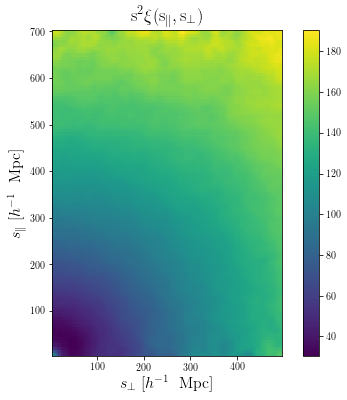

In [48]:
xy = np.meshgrid(x_bins_, y_bins_, indexing='ij')

s_square_bin = np.sqrt(xy[0]**2 + xy[1]**2)

fig, ax = subplots(1, figsize = (6,6))

a = ax.pcolormesh(xy[0], xy[1], C_ortho_para*s_square_bin**0.75)
#a = ax.pcolormesh(xy[0], xy[1], C_ortho_para)
ax.set_title(r"$\mathrm{s^2 \xi(s_{\parallel}, s_{\perp})}$", fontsize=18)
ax.set_xlabel(r'$s_{\perp} \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax.set_ylabel(r'$s_{\parallel} \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax.set_aspect('equal')
plt.colorbar(a, ax=ax, fraction=0.05, pad=0.06)

### Compute 1D autocorrelation function

In [15]:
a_l_δ_com = np.fft.rfftn(δ_ref_com)*(pred_size_Mpc/pred_size)**3.

C_s = ( (1/pred_size_Mpc)**3.*np.fft.irfftn(np.absolute(a_l_δ_com)**2.) )

Nbins = 100

xx = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L0) - 0.5*L0)
yy = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L1) - 0.5*L1)
zz = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L2) - 0.5*L2)

s_x = xx[:,None,None].repeat(pred_size,axis=1).repeat(pred_size,axis=2)
s_y = yy[None,:,None].repeat(pred_size,axis=0).repeat(pred_size,axis=2)
s_z = zz[None,None,:].repeat(pred_size,axis=0).repeat(pred_size,axis=1)

x = np.sqrt(s_x**2 + s_y**2 + s_z**2)

corr_1d_w, x_bins = np.histogram(x, bins=Nbins)
corr_1d, _ = np.histogram(x, weights=C_s, bins=Nbins)

corr_1d /= corr_1d_w

x_c = 0.5 * (x_bins[0:x_bins.size-1]+x_bins[1:])

### Visualize 1D autocorrelation function

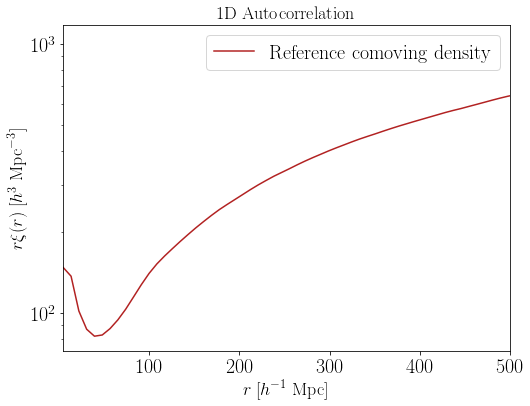

In [23]:
figure(figsize = (8, 6))

plot(x_c, corr_1d*x_c**1, color='firebrick', label=r'$\mathrm{Reference \ comoving \ density}$')

#xscale('log')
yscale('log')
title(r'$\mathrm{1D \ Autocorrelation}$', fontsize = 18)
xlabel(r'$r \; [h^{-1} \; \mathrm{Mpc}]$', fontsize = 18)
ylabel(r'$r \xi(r) \; [h^3 \; {\mathrm{Mpc}}^{-3}]$', fontsize = 18)
xlim([np.min(x_c), L0/2])#np.max(x_c)])
tick_params(labelsize = 20)
legend(fontsize = 20);

### Visualize jacobian of comoving-redshift transformation

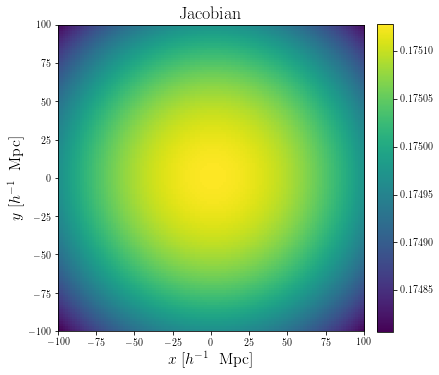

In [27]:
fig, ax = subplots(1, figsize = (6,8))

a = ax.imshow(grid_transform_ref[:,:,-1,3], origin="lower", extent=(-pred_size_Mpc/2,pred_size_Mpc/2,-pred_size_Mpc/2,pred_size_Mpc/2))#, vmin=0.8, vmax=1)
ax.set_title(r"$\mathrm{Jacobian}$", fontsize=18)
ax.set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax.set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
plt.colorbar(a, ax=ax, fraction=0.046, pad=0.04)

### Visualize comoving vs redshift-space representations of evolved density field

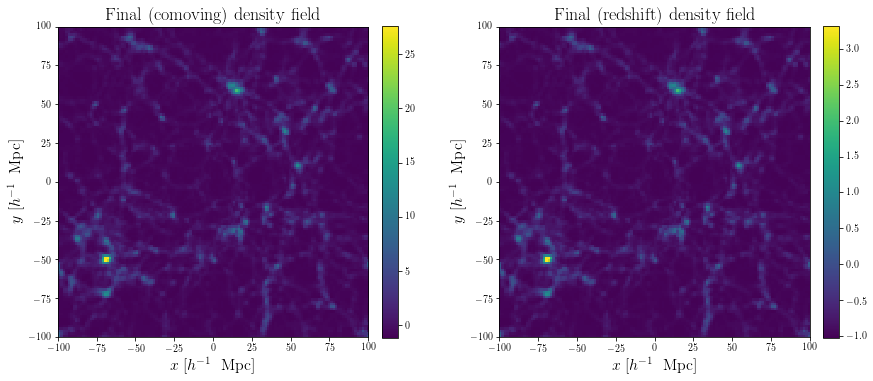

In [31]:
fig, ax = subplots(1, 2, figsize = (14,8))
subplots_adjust(wspace = 0.3, hspace = 0.0)

#a = ax[0].imshow(np.log(1 + δ_ref_com[:,:,int(pred_size/4)]), origin="lower", vmin=-3.5, vmax=0, extent=(-pred_size_Mpc/2,pred_size_Mpc/2,-pred_size_Mpc/2,pred_size_Mpc/2))
#b = ax[1].imshow(np.log(1 + δ_ref_z[:,:,int(pred_size/4)]), origin="lower", vmin=-3.5, vmax=0, extent=(-pred_size_Mpc/2,pred_size_Mpc/2,-pred_size_Mpc/2,pred_size_Mpc/2))

a = ax[0].imshow(δ_ref_com[:,:,-1], origin="lower", extent=(-pred_size_Mpc/2,pred_size_Mpc/2,-pred_size_Mpc/2,pred_size_Mpc/2))
b = ax[1].imshow(δ_ref_z[:,:,-1], origin="lower", extent=(-pred_size_Mpc/2,pred_size_Mpc/2,-pred_size_Mpc/2,pred_size_Mpc/2))
ax[0].set_title(r"$\mathrm{Final \ (comoving) \  density \ field}$", fontsize=18)
ax[0].set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax[0].set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax[1].set_title(r"$\mathrm{Final \ (redshift) \  density \ field}$", fontsize=18)
ax[1].set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax[1].set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
plt.colorbar(a, ax=ax[0], fraction=0.046, pad=0.04)
plt.colorbar(b, ax=ax[1], fraction=0.046, pad=0.04)

### Visualize power spectra (comoving vs redshift-space representations of evolved density field)

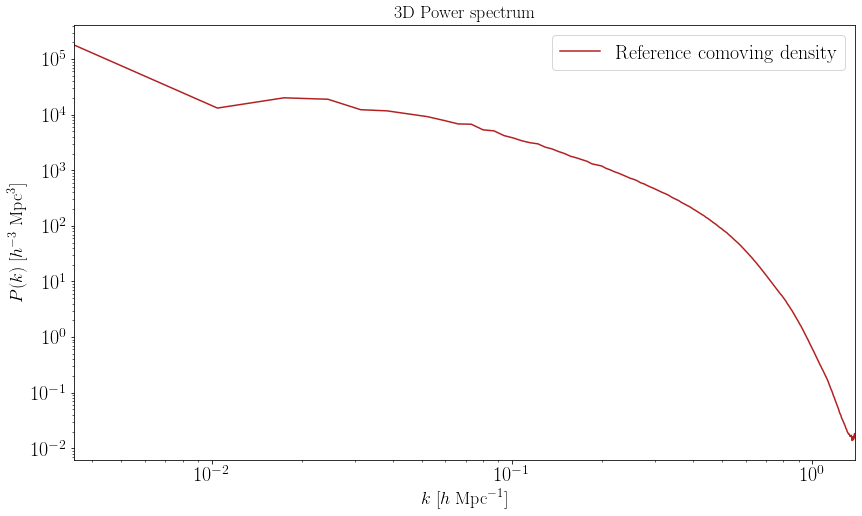

In [51]:
figure(figsize = (14, 8))

#plot(l_c, Pk_δ_mean, color='firebrick', label=r'$\mathrm{Reference \ high-res \ density}$')
#fill_between(l_c, Pk_δ_mean - Pk_δ_std, Pk_δ_mean + Pk_δ_std, facecolor="firebrick", edgecolor="darkslategrey", lw=0.75, alpha=0.55)

plot(l_c, Pk_δ_ref_com, color='firebrick', label=r'$\mathrm{Reference \ comoving \ density}$')
#plot(l_c, Pk_δ_ref, color='midnightblue', label=r'$\mathrm{Reference \ redshift \ density}$')

xscale('log')
yscale('log')
title(r'$\mathrm{3D \ Power \ spectrum}$', fontsize = 18)
xlabel(r'$k \; [h \; {\mathrm{Mpc}}^{-1}]$', fontsize = 18)
ylabel(r'$P(k) \; [h^{-3} \; {\mathrm{Mpc}}^{3}]$', fontsize = 18)
xlim([np.min(l_c), np.max(l_c)])
tick_params(labelsize = 20)
legend(fontsize = 20);

### Choose range of values for $\Omega_{\mathrm{m}}$ and $w_0$

In [ ]:
Nvalues = 25

Omega_m_list = np.linspace(0.15, 0.55, Nvalues)
w_0_list = np.linspace(-1.20, -0.8, Nvalues)

### Cosmological exploration

In [ ]:
def cosmo_main_loop(i,j):
    
    likelihood_Pk = np.zeros((Nvalues,Nvalues))
    likelihood_inf = np.zeros((Nvalues,Nvalues))
    
    theta_omega_m = Omega_m_list[i]
    theta_w_0 = w_0_list[j]
    
    grid_transform_i = update_coordinate_system(Omega_m=theta_omega_m, w_0=theta_w_0)
    δ_z_i = interpolate_3d(δ_ref_com, grid_transform_i)

    likelihood_Pk[i,j] = ((compute_power_spectrum(δ_z_i) - Pk_δ_ref)**2).sum()
    likelihood_inf[i,j] = ((δ_z_i - δ_ref_z)**2).sum()   
    
    return likelihood_Pk, likelihood_inf

executor = ProcessPoolExecutor(max_workers=4)
results = [executor.submit(cosmo_main_loop, i, j) for (i,j) in itertools.product(range(Nvalues),range(Nvalues))]

likelihood_Pk = np.zeros((Nvalues,Nvalues))
likelihood_inf = np.zeros((Nvalues,Nvalues))

for r in range(len(results)):
    likelihood_Pk += results[r].result()[0]
    likelihood_inf += results[r].result()[1]

In [ ]:
likelihood_grid = np.load("likelihood_grid_50.npz")

likelihood_Pk = likelihood_grid["likelihood_Pk"]
likelihood_inf = likelihood_grid["likelihood_inf"]

Nvalues = 50
Omega_m_list = np.linspace(0.15, 0.55, Nvalues)
w_0_list = np.linspace(-1.20, -0.8, Nvalues)
true_omega_m = 0.3089
true_w_0 = -1

In [ ]:
fig, ax = subplots(1, 2, figsize = (12,16))
subplots_adjust(wspace = 0.3, hspace = 0.0)

a = ax[0].imshow(-likelihood_Pk/likelihood_Pk.max(), origin="lower", extent=(Omega_m_list[0], Omega_m_list[-1], w_0_list[0], w_0_list[-1]), aspect="equal", interpolation="nearest", cmap="viridis_r", vmin=-1, vmax=0)
ax[0].set_title(r"$\mathrm{Likelihood} \; P(k)$", fontsize=18)
ax[0].scatter(true_omega_m, true_w_0, marker='*', s=100, color='gold', label=r'$\mathrm{true}$');
#ax.set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
#ax.set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax[0].set_xlabel(r'$\Omega_{\mathrm{m}}$', fontsize=16);
ax[0].set_ylabel(r'$w_0$', fontsize=16);
plt.colorbar(a, ax=ax[0], fraction=0.046, pad=0.04)

b = ax[1].imshow(-likelihood_inf/likelihood_inf.max(), origin="lower", extent=(Omega_m_list[0], Omega_m_list[-1], w_0_list[0], w_0_list[-1]), aspect="equal", interpolation="nearest", cmap="viridis_r", vmin=-1, vmax=0)
ax[1].set_title(r"$\mathrm{Likelihood \; per \; voxel}$", fontsize=18)
ax[1].scatter(true_omega_m, true_w_0, marker='*', s=100, color='gold', label=r'$\mathrm{true}$');
ax[1].set_xlabel(r'$\Omega_{\mathrm{m}}$', fontsize=16);
ax[1].set_ylabel(r'$w_0$', fontsize=16);
#ax.set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
#ax.set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
plt.colorbar(b, ax=ax[1], fraction=0.046, pad=0.04)

## List of tasks:

1) Compute and save $\delta_{\mathrm{z}}^{\mathrm{ref}}$ as `.npz`, which is the redshift-space representation of the central sim.

2) Use $\delta_{\mathrm{z}}^{\mathrm{ref}}$ to compute and save $P_k^{\mathrm{ref}}$ as `.npz`, which is the template reference power spectrum $P(k)$, for a given binning.

3) Build $\mathrm{main}$ function $\rightarrow$ loop over range of $\Omega_{\mathrm{m}}$ and $w_0$ (1 nested loop).

4) $\mathrm{main}$ function should take in central sim (both comoving & redshift), i.e. $\delta_{\mathrm{com}}^{\mathrm{ref}}$ and $\delta_{\mathrm{z}}^{\mathrm{ref}}$, and $P_k^{\mathrm{ref}}$, loop over cosmo params, then save the corresponding likelihood values only (keep overwriting density and power spectrum arrays) in a list, i.e. $\mathcal{L}_{(2)}$ and $\mathcal{L}_{(\infty)}$.

5) [TODO] Implement *remote observer approximation* ($z_r = z_z$, $c_0 = 0$, $c_1 = 0$, $c_2 = \mathrm{position \ of \ observer}$).

6) [TODO] Use Pylians to compute 2-point correlation function, which will replace all power spectrum computations above **OR** try 2d correlation plot

7) Use `seaborn` to plot joint and marginal likelihood distributions.